# ========================================
# SEMICONDUCTOR WAFER SCRATCH DETECTION - ENHANCED HYBRID MODEL
# Advanced Deep Learning Solution for Automated Defect Detection
# Complete Google Colab Implementation
# ========================================

"""
## 🎯 CHALLENGE OVERVIEW

### The Problem
In semiconductor manufacturing, wafers are thin discs of silicon containing hundreds of individual chips (dies).
Scratches - elongated clusters of defective dies - significantly impact production quality and yield.

Current Challenge:
- Manual scratch detection is expensive, time-consuming, and error-prone
- Scratches appear as linear patterns of bad dies, often with gaps
- "Ink dies" (good dies within scratches) are particularly hard to detect
- Must avoid false positives on low-yield wafers (<40% good dies)

### Business Impact
-  Cost Reduction: Automate manual inspection process
-  Speed: Real-time detection vs hours of manual work  
-  Accuracy: Consistent detection criteria
-  Yield Optimization: Better balance between quality and productivity

### Technical Challenges
1. **Discontinuous Patterns**: Scratches often have gaps
2. **Ink Die Detection**: Good dies within scratches need special handling
3. **Diagonal Scratches**: Harder to detect than horizontal/vertical
4. **Noise vs Real Defects**: Single bad dies might be noise, not scratches
5. **Limited Training Data**: Dataset has inconsistent labeling



**Note**. In wafers with a low yield (that is, a lot of faulty dies), I will **not** perform scratch detection because the customer is afraid to find randomly generated scratches there and perform unnecessary ink. In such cases, the customer will make sure to check all the dies strictly in any case, but regardless of the detection of scratches. Therefore, in these cases I will not consider a sequence of bad die to be scratch.

## SETUP AND INSTALLATIONS

In [ ]:
print("🔧 Setting up environment...")

# Install required packages
!pip install -q transformers accelerate pillow scikit-learn scipy
!pip install -q diffusers  # For UNet2DModel
!pip install -q torch torchvision --upgrade
!pip install hf_xet
# Clone perception models repo (for PE model)
!git clone -q https://github.com/facebookresearch/perception_models.git
!pip install -q decord ftfy
import sys
sys.path.append('./perception_models')

# All imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from diffusers import UNet2DModel
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoProcessor
from PIL import Image
from scipy.ndimage import binary_dilation, label, binary_closing, generate_binary_structure, gaussian_filter
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.linear_model import RANSACRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import random
from datetime import datetime
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Import PE model
import core.vision_encoder.pe as pe
import core.vision_encoder.transforms as transforms

import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Rectangle, FancyArrowPatch

print("✅ Environment setup complete!")

🔧 Setting up environment...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
import torch
import gc
import os

# Optimize memory settings
torch.cuda.set_per_process_memory_fraction(0.95)
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Clear any existing memory
gc.collect()
torch.cuda.empty_cache()

print(f"💾 Initial GPU memory: {torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)} bytes free")

💾 Initial GPU memory: 23795204096 bytes free


## DATA LOADING

In [ ]:
print("\n📁 Loading data...")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load data from zip file
zf = zipfile.ZipFile('/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/data.zip')

# Load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
print(f"✅ Training data loaded: {df_wafers.shape}")

# Load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
print(f"✅ Test data loaded: {df_wafers_test.shape}")

# Data exploration
print("\n📊 Data Statistics:")
print(f"Training wafers: {df_wafers['WaferName'].nunique()}")
print(f"Test wafers: {df_wafers_test['WaferName'].nunique()}")
print(f"Good dies in training: {df_wafers['IsGoodDie'].sum()} ({df_wafers['IsGoodDie'].mean():.2%})")
print(f"Scratch dies in training: {df_wafers['IsScratchDie'].sum()} ({df_wafers['IsScratchDie'].mean():.2%})")


📁 Loading data...
Mounted at /content/gdrive
✅ Training data loaded: (10415400, 5)
✅ Test data loaded: (1128335, 4)

📊 Data Statistics:
Training wafers: 4200
Test wafers: 455
Good dies in training: 10036478 (96.36%)
Scratch dies in training: 80319 (0.77%)


In [ ]:
# Load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
print(f"✅ Training data loaded: {df_wafers.shape}")
df_wafers.head()

✅ Training data loaded: (10415400, 5)


,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [ ]:
# Load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
print(f"✅ Test data loaded: {df_wafers_test.shape}")
df_wafers_test.head()

✅ Test data loaded: (1128335, 4)


,WaferName,DieX,DieY,IsGoodDie
0,mZa9ls,0,23,True
1,mZa9ls,0,24,True
2,mZa9ls,0,25,True
3,mZa9ls,0,26,True
4,mZa9ls,0,27,True


In [ ]:
# Data exploration
print("\n📊 Data Statistics:")
print(f"Training wafers: {df_wafers['WaferName'].nunique()}")
print(f"Test wafers: {df_wafers_test['WaferName'].nunique()}")
print(f"Good dies in training: {df_wafers['IsGoodDie'].sum()} ({df_wafers['IsGoodDie'].mean():.2%})")
print(f"Scratch dies in training: {df_wafers['IsScratchDie'].sum()} ({df_wafers['IsScratchDie'].mean():.2%})")


📊 Data Statistics:
Training wafers: 4200
Test wafers: 455
Good dies in training: 10036478 (96.36%)
Scratch dies in training: 80319 (0.77%)


##VISUALIZATION FUNCTIONS


🖼️ Sample wafers from training data:


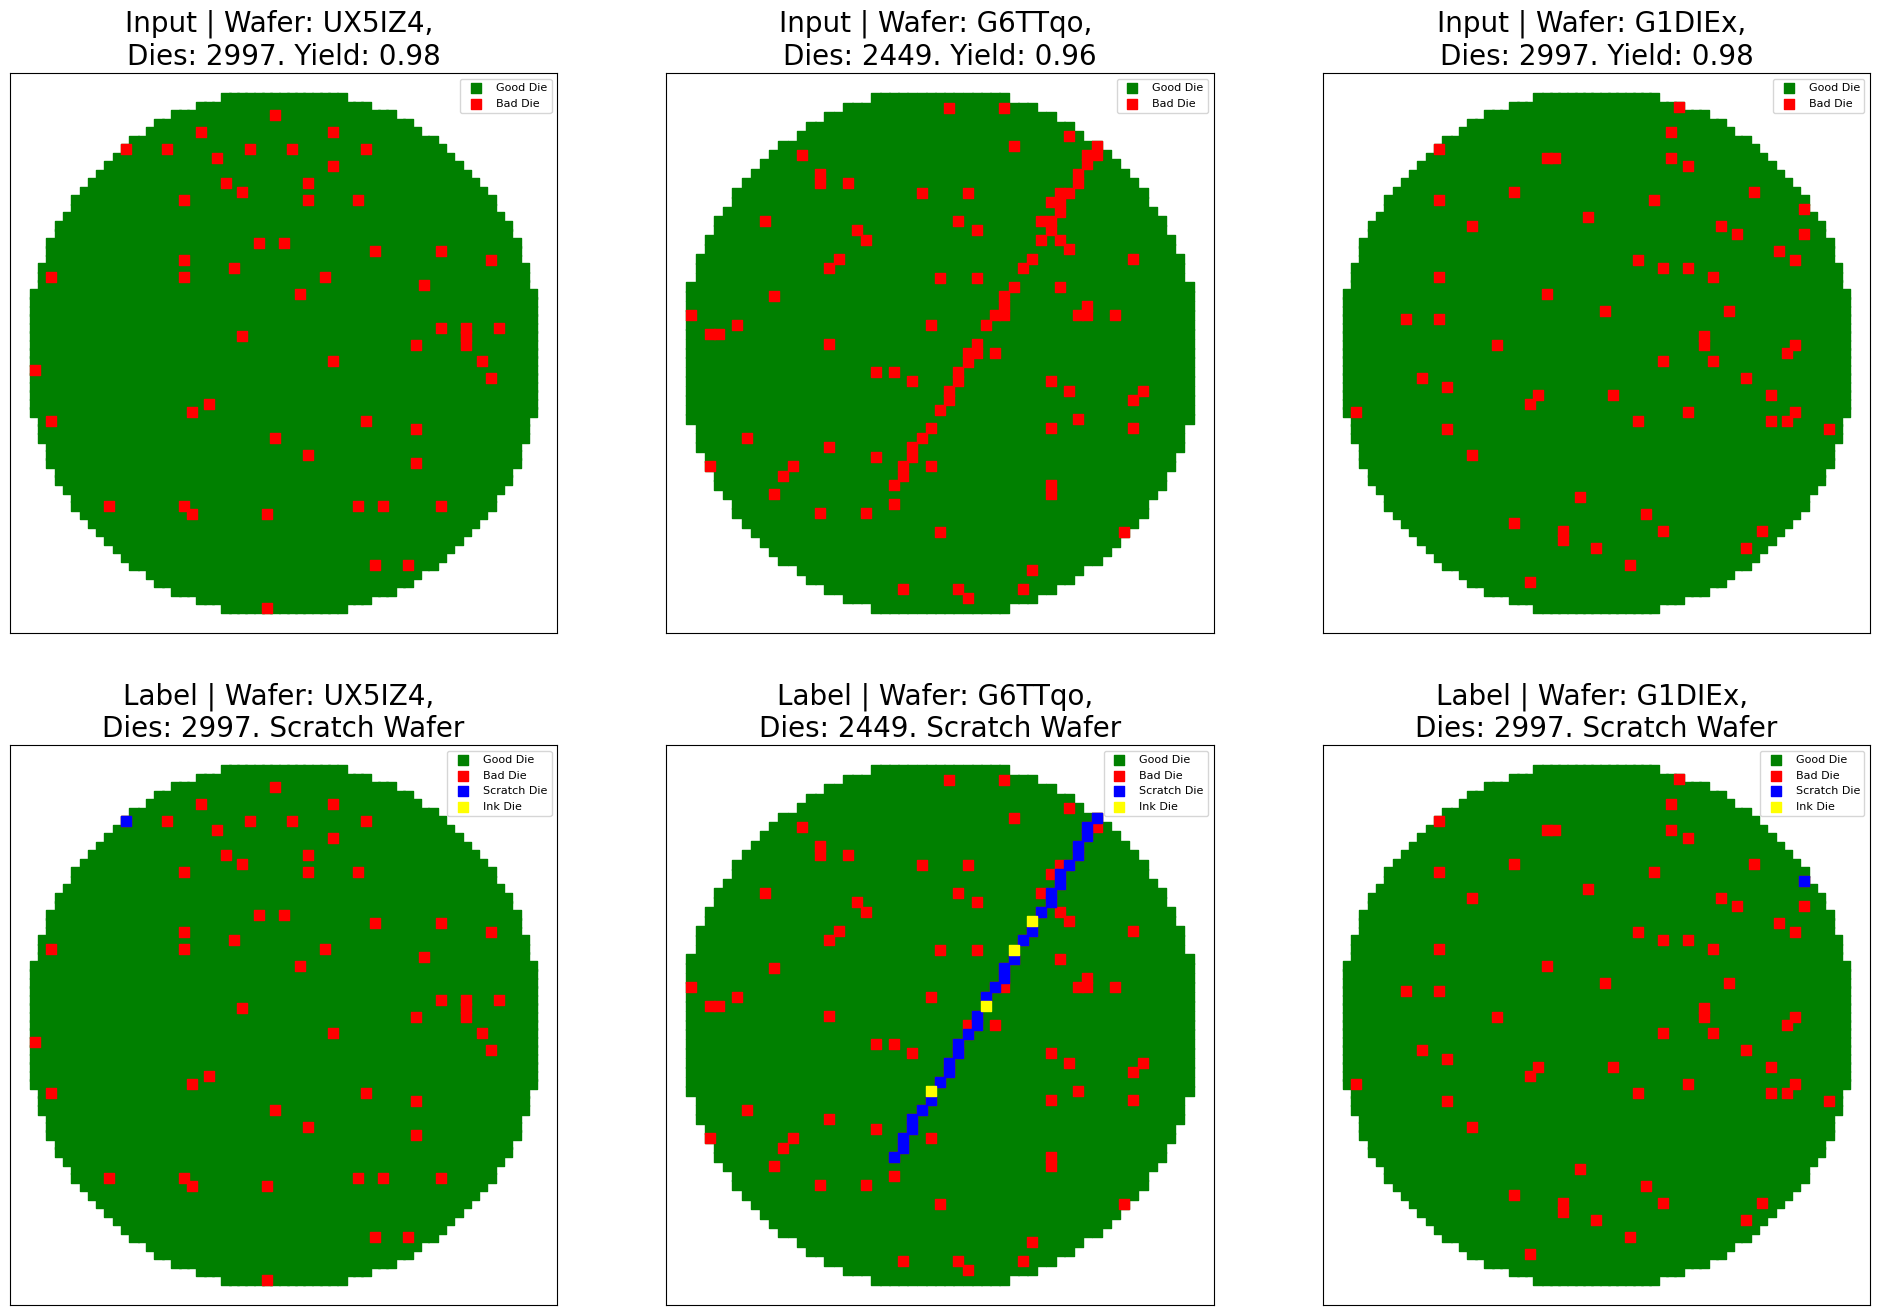

In [ ]:
def plot_wafer_maps(wafer_df_list, figsize, labels=True):
   """Plot wafer maps for list of wafer dataframes"""
   def plot_wafer_map(wafer_df, ax, map_type):
       wafer_size = len(wafer_df)
       s = 2**17/(wafer_size)

       if map_type == 'Label':
           mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum() > 0 else 'Non-Scratch Wafer'
       else:
           mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2))

       ax.set_title(f'{map_type} | Wafer: {wafer_df["WaferName"].iloc[0]}, \nDies: {len(wafer_df)}. {mes}', fontsize=20)
       ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color='green', marker='s', s=s)

       bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
       ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color='red', marker='s', s=s)

       if map_type == 'Label':
           scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
           ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color='blue', marker='s', s=s)

           ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
           ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color='yellow', marker='s', s=s)

           ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
       else:
           ax.legend(['Good Die', 'Bad Die'], fontsize=8)

       ax.axes.get_xaxis().set_visible(False)
       ax.axes.get_yaxis().set_visible(False)

   if labels:
       fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
       for idx1, wafer_df in enumerate(wafer_df_list):
           for idx2, map_type in enumerate(['Input', 'Label']):
               if len(wafer_df_list) == 1:
                   plot_wafer_map(wafer_df, ax[idx2], map_type)
               else:
                   plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
   else:
       fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
       for idx, wafer_df in enumerate(wafer_df_list):
           if len(wafer_df_list) == 1:
               plot_wafer_map(wafer_df, ax, 'Input')
           else:
               plot_wafer_map(wafer_df, ax[idx], 'Input')

   plt.show()

# Visualize sample wafers
print("\n🖼️ Sample wafers from training data:")
n_samples = 3
list_sample_train = [df_wafers.groupby('WaferName').get_group(group)
                    for group in df_wafers['WaferName'].value_counts().sample(n_samples, random_state=42).index]
plot_wafer_maps(list_sample_train, figsize=8, labels=True)


The model is not supposed to predict scratches on wafers with low yield. Therefore, I need to decide on a threshold value for filtering out the low-yield wafers. I need to ensure that I will not filter out most of my data while still training the model with the proper wafers.

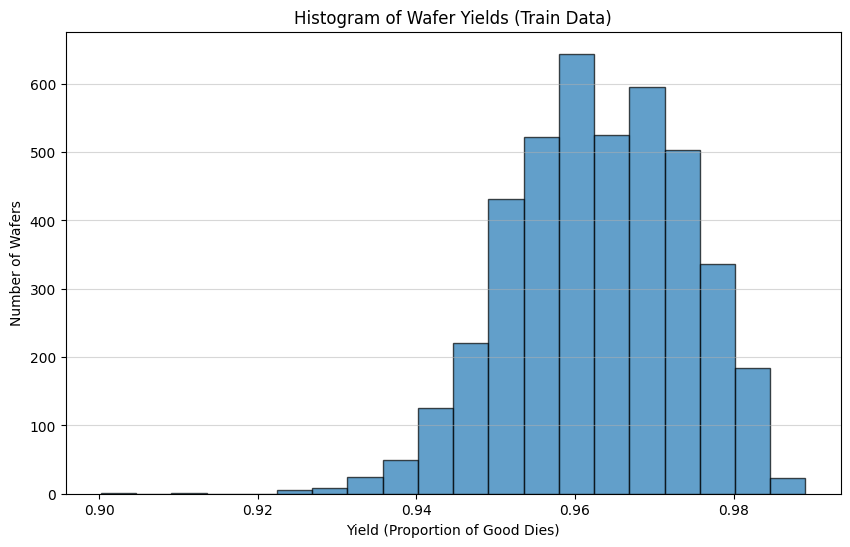

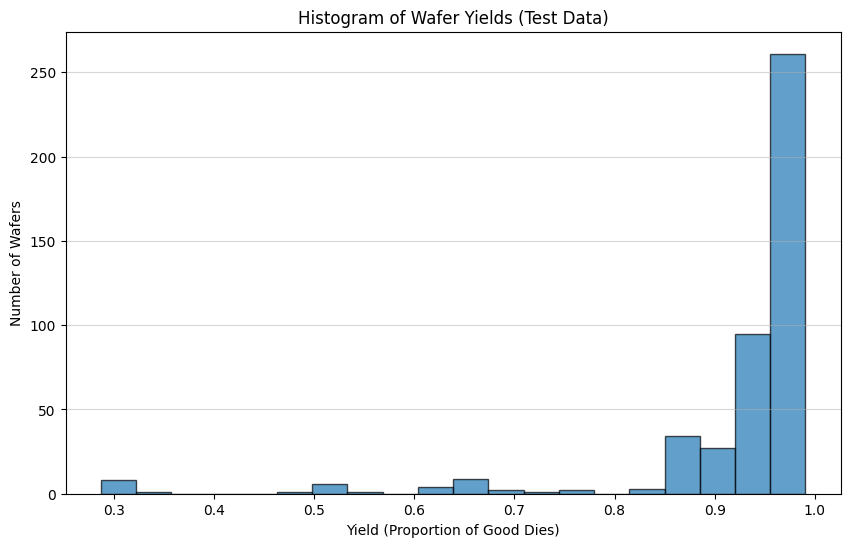

In [ ]:
# @title Datasets Histograms
def load_and_plot_yield_histogram(dataset='train'):
    """
    Loads wafer data (train or test) from a zip file and plots a histogram of wafer yields.

    :param dataset: str, 'train' or 'test' to specify which dataset to load.
    :return: None
    """
    if dataset not in ['train', 'test']:
        print("Error: dataset must be 'train' or 'test'.")
        return

    filename = f'wafers_{dataset}.csv'
    title = f'Histogram of Wafer Yields ({dataset.capitalize()} Data)'

    try:
        with zipfile.ZipFile('/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/data.zip') as zf:
            df_wafers = pd.read_csv(zf.open(filename))
    except FileNotFoundError:
        print("Error: 'data.zip' not found. Please ensure the file is in the correct directory.")
        return
    except KeyError:
        print(f"Error: '{filename}' not found within the zip file.")
        return

    if 'WaferName' not in df_wafers.columns or 'IsGoodDie' not in df_wafers.columns:
        print("Error: DataFrame must contain 'WaferName' and 'IsGoodDie' columns.")
        return

    wafer_yields = df_wafers.groupby('WaferName')['IsGoodDie'].mean()

    plt.figure(figsize=(10, 6))
    plt.hist(wafer_yields, bins=20, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Yield (Proportion of Good Dies)')
    plt.ylabel('Number of Wafers')
    plt.grid(axis='y', alpha=0.5)
    plt.show()

# Example usage:
load_and_plot_yield_histogram('train')
load_and_plot_yield_histogram('test')

The training dataset wafers have high yields (above 0.9), while the test dataset also contains wafers with low yields. According to the test histogram, I chose to filter out wafers with yields below 0.4.

In [ ]:

df_wafers.info()
df_wafers_test.info()

print("\nSummary statistics for training data:")
print(df_wafers.describe())

print("\nSummary statistics for test data:")
print(df_wafers_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415400 entries, 0 to 10415399
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   WaferName     object
 1   DieX          int64 
 2   DieY          int64 
 3   IsGoodDie     bool  
 4   IsScratchDie  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 258.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128335 entries, 0 to 1128334
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   WaferName  1128335 non-null  object
 1   DieX       1128335 non-null  int64 
 2   DieY       1128335 non-null  int64 
 3   IsGoodDie  1128335 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 26.9+ MB

Summary statistics for training data:
               DieX          DieY
count  1.041540e+07  1.041540e+07
mean   2.892736e+01  2.892736e+01
std    1.603043e+01  1.603043e+01
min    0.000000e+00  0.000000e+00
25%    1.600000e

##  DATASET CLASS

In [ ]:
def custom_collate_fn(batch):
   """Custom collate function to handle variable-length lists"""
   batch_data = {}
   for key in batch[0].keys():
       if key == 'wafer_name':
           batch_data[key] = [item[key] for item in batch]
       elif key in ['condition', 'target']:
           batch_data[key] = torch.stack([item[key] for item in batch])
       elif key in ['coords', 'indices']:
           batch_data[key] = [item[key] for item in batch]
       else:
           batch_data[key] = [item[key] for item in batch]
   return batch_data

class WaferMapDataset(Dataset):
   def __init__(self, dataframe, wafer_size=64, transform=None, yield_threshold=0.4, augment=False):
       # Filter low-yield wafers
       wafer_yields = dataframe.groupby('WaferName').apply(
           lambda x: x['IsGoodDie'].sum() / x['IsGoodDie'].count(),
           include_groups=False
       )
       high_yield_wafers = wafer_yields[wafer_yields > yield_threshold].index.tolist()

       filtered_df = dataframe[dataframe['WaferName'].isin(high_yield_wafers)]

       self.dataframe = filtered_df
       self.wafer_names = filtered_df['WaferName'].unique()
       self.wafer_size = wafer_size
       self.transform = transform
       self.yield_threshold = yield_threshold
       self.augment = augment

       print(f"Using {len(self.wafer_names)} wafers after filtering (threshold: {yield_threshold})")

   def __len__(self):
       return len(self.wafer_names)

   def __getitem__(self, idx):
       wafer_name = self.wafer_names[idx]
       wafer_df = self.dataframe[self.dataframe['WaferName'] == wafer_name].copy()

       # Create empty maps
       wafer_map = np.zeros((self.wafer_size, self.wafer_size))
       scratch_map = np.zeros((self.wafer_size, self.wafer_size))

       # Normalize coordinates
       x_min, x_max = wafer_df['DieX'].min(), wafer_df['DieX'].max()
       y_min, y_max = wafer_df['DieY'].min(), wafer_df['DieY'].max()
       x_range = max(1, x_max - x_min)
       y_range = max(1, y_max - y_min)

       # Fill the maps
       for _, die in wafer_df.iterrows():
           x = int((die['DieX'] - x_min) / x_range * (self.wafer_size - 1))
           y = int((die['DieY'] - y_min) / y_range * (self.wafer_size - 1))

           x = min(max(0, x), self.wafer_size - 1)
           y = min(max(0, y), self.wafer_size - 1)

           wafer_map[y, x] = 0 if die['IsGoodDie'] else 1

           if 'IsScratchDie' in wafer_df.columns:
               scratch_map[y, x] = 1 if die['IsScratchDie'] else 0

       # Apply augmentations
       if self.augment:
           wafer_img = TF.to_pil_image(wafer_map)
           scratch_img = TF.to_pil_image(scratch_map)

           angle = random.choice([0, 90, 180, 270])
           if angle != 0:
               wafer_img = TF.rotate(wafer_img, angle)
               scratch_img = TF.rotate(scratch_img, angle)

           wafer_map = TF.to_tensor(wafer_img)
           scratch_map = TF.to_tensor(scratch_img)
       else:
           wafer_map = torch.tensor(wafer_map, dtype=torch.float32).unsqueeze(0)
           scratch_map = torch.tensor(scratch_map, dtype=torch.float32).unsqueeze(0)

       coords = [(die['DieX'], die['DieY']) for _, die in wafer_df.iterrows()]

       return {
           'wafer_name': wafer_name,
           'condition': wafer_map,
           'target': scratch_map,
           'coords': coords,
           'indices': wafer_df.index.tolist()
       }

## Memory functions

In [ ]:
# Add this GPU memory management code
import gc

def clear_gpu_memory():
    """Clear GPU memory without losing the training state"""
    gc.collect()
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    print(f"GPU memory cleared. Free memory: {torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)} bytes")

# Add this before loading SmolVLM or when memory is tight
def optimize_memory_usage():
    """Optimize memory usage for limited GPU"""
    # Set memory fraction
    torch.cuda.set_per_process_memory_fraction(0.95)

    # Enable memory efficient attention if available
    if hasattr(torch.nn.functional, 'scaled_dot_product_attention'):
        torch.backends.cuda.enable_mem_efficient_sdp(True)
        torch.backends.cuda.enable_flash_sdp(True)

    # Set environment variable for better memory management
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

def clear_all_memory():
    """Aggressively clear all GPU memory"""
    # Delete all variables
    for name in dir():
        if not name.startswith('_'):
            try:
                del globals()[name]
            except:
                pass

    # Garbage collect
    gc.collect()

    # Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    print(f"GPU memory freed: {torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)} bytes")

# Clear memory first
clear_all_memory()


GPU memory freed: 23795204096 bytes


 ## MODEL COMPONENTS

# Unet architecture

UNet is a popular convolutional neural network architecture primarily used for semantic segmentation. Its key characteristic is its U-shape.

The contracting path (left side of the 'U') acts like a typical convolutional network, repeatedly applying convolutions and max-pooling to capture the context of the input image. This reduces the spatial resolution while increasing the number of feature channels.

The expansive path (right side of the 'U') then upsamples these low-resolution feature maps while combining them with high-resolution features from the contracting path via skip connections. These skip connections allow the network to propagate fine-grained details from the earlier layers to the later upsampling layers, which is crucial for precise localization of the segmented regions.

The final layers of the expansive path produce a segmentation map with the same spatial dimensions as the input image, where each pixel is assigned to a specific class.

The 2D U-Net model from the Hugging Face Diffusers library was chosen for this task. (https://huggingface.co/docs/diffusers/en/api/models/unet2d)

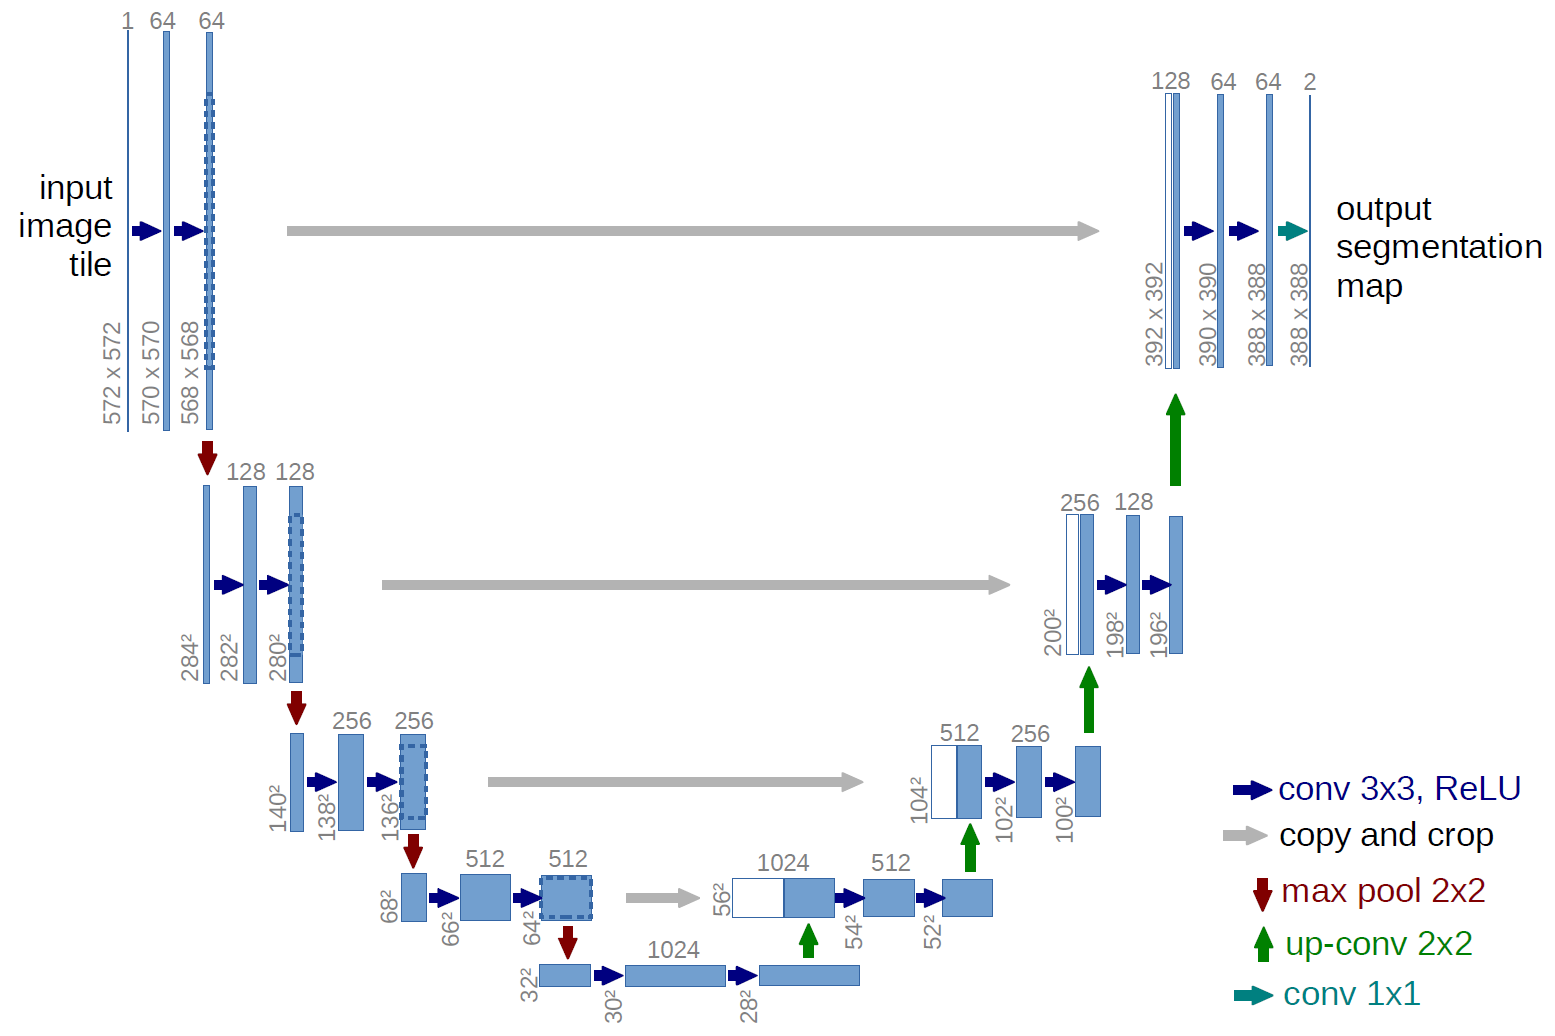

An Example of a U-Net Architecture (https://arxiv.org/abs/1505.04597)

#Traning model by using only U-Net Architecture with post processing step

In [ ]:
# Setup the UNet2DModel model
def setup_model(device):
    model = UNet2DModel(
        sample_size=64,           # Size of the input/output images
        in_channels=1,            # Single channel for wafer map
        out_channels=1,           # Single channel for scratch prediction
        layers_per_block=2,       # Number of layers per block
        block_out_channels=(64, 128, 256, 512),  # Channels in each block
        down_block_types=(
            "DownBlock2D",
            "DownBlock2D",
            "DownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
        ),
        # Standard UNet2D architecture settings
        downsample_padding=1,
        mid_block_scale_factor=1,
        act_fn="silu",
        norm_num_groups=8,
        norm_eps=1e-5,
        dropout=0.0,
    ).to(device)

    return model

In [ ]:
# Plot training and validation loss
def plot_training_curves(train_losses, val_losses):
    """Plot the training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Updated train_model function to record and plot losses
def train_model(model, train_loader, val_loader, device, epochs=3,
                checkpoint_dir="/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment",
                start_epoch=0, optimizer=None, train_losses=None, val_losses=None):
    """
    Train a model with support for resuming from checkpoints
    Args:
        model: PyTorch model for segmentation (expects 'condition' and timestep input, 'sample' output).
        train_loader: DataLoader for training data .
        val_loader: DataLoader for validation data .
        device: Training device ('cuda' or 'cpu').
        epochs: Number of training epochs .
        checkpoint_dir: Directory to save checkpoints and best model.
        start_epoch: Epoch to start from (for resuming) .
        optimizer: Optimizer to use (default: Adam if None).
        train_losses: List to store training losses (default: new list).
        val_losses: List to store validation losses (default: new list).

    Returns:
        The trained model (best performing model loaded if available).
    """

    # Initialize histories if not provided
    if train_losses is None:
        train_losses = []
    if val_losses is None:
        val_losses = []

    # Initialize optimizer if not provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

    os.makedirs(checkpoint_dir, exist_ok=True)

    # Use a combination of BCE and Dice loss for better segmentation
    bce_criterion = nn.BCEWithLogitsLoss()

    # Dice loss implementation
    def dice_loss(pred, target):
        smooth = 1.0
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

    best_val_loss = float('inf')

    # If we have previous validation losses, use the best one as reference
    if val_losses and len(val_losses) > 0:
        best_val_loss = min(val_losses)

    best_model_state = None

    # Load best model if it exists
    best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
    if os.path.exists(best_model_path):
        best_model_state = torch.load(best_model_path, map_location=device)
        print(f"Loaded best model state from {best_model_path}")

    # Training loop - note we start from start_epoch
    for epoch in range(start_epoch, epochs):
        # Training
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            # Get data
            condition = batch['condition'].to(device)
            target = batch['target'].to(device)

            # UNet2DModel needs a timestep, but we can use a fixed value since we're not doing diffusion
            timestep = torch.zeros(condition.shape[0], device=device).long()

            # Forward pass with UNet2DModel
            pred = model(condition, timestep).sample

            # Calculate losses
            bce = bce_criterion(pred, target)
            dice = dice_loss(pred, target)
            loss = 0.5 * bce + 0.5 * dice  # Equal weight for BCE and Dice

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
                condition = batch['condition'].to(device)
                target = batch['target'].to(device)

                # Fixed timestep
                timestep = torch.zeros(condition.shape[0], device=device).long()

                # Forward pass
                pred = model(condition, timestep).sample

                bce = bce_criterion(pred, target)
                dice = dice_loss(pred, target)
                loss = 0.5 * bce + 0.5 * dice

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Save checkpoint after each epoch
        checkpoint_path = os.path.join(checkpoint_dir, f"wafer_scratch_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
            torch.save(best_model_state, best_model_path)
            print(f"New best model saved with validation loss: {val_loss:.4f}")

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')

    # Plot training and validation loss curves if training is complete
    if epochs - start_epoch > 0:
        plot_training_curves(train_losses, val_losses)

    # Load best model if we have one
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

In [ ]:
# Prediction Function
def predict(model, test_loader, device, threshold=0.5):
    """Predicts if individual dies on test wafers are part of a scratch.

    Args:
        model: Trained segmentation model.
        test_loader: DataLoader for test data (yields 'wafer_name', 'condition', 'coords', 'indices').
        device: Device for computation ('cuda' or 'cpu').
        threshold: Probability threshold for considering a pixel as part of a scratch (default: 0.5).

    Returns:
        DataFrame with an added 'IsScratchDie' column (True if the die is predicted to be part of a scratch).
    """
    model.eval()
    all_indices = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Making predictions"):
            wafer_names = batch['wafer_name']
            condition = batch['condition'].to(device)
            coords_list = batch['coords']
            indices_list = batch['indices']

            # Fixed timestep
            timestep = torch.zeros(condition.shape[0], device=device).long()

            # Forward pass with UNet2DModel
            pred = model(condition, timestep).sample
            pred = torch.sigmoid(pred).cpu().numpy()

            # Process each wafer in the batch
            for i, wafer_name in enumerate(wafer_names):
                pred_mask = pred[i, 0] > threshold  # Apply threshold
                coords = coords_list[i]
                indices = indices_list[i]

                # Create a mapping from grid coordinates to original dies
                die_predictions = []

                # Calculate min/max for scaling
                x_values = [c[0] for c in coords]
                y_values = [c[1] for c in coords]
                x_min, x_max = min(x_values), max(x_values)
                y_min, y_max = min(y_values), max(y_values)
                x_range = max(1, x_max - x_min)
                y_range = max(1, y_max - y_min)

                # Map predictions back to original dies
                for die_x, die_y in coords:
                    # Calculate grid indices from original coordinates
                    x = int((die_x - x_min) / x_range * (pred_mask.shape[1] - 1))
                    y = int((die_y - y_min) / y_range * (pred_mask.shape[0] - 1))

                    # Ensure valid indices
                    x = min(max(0, x), pred_mask.shape[1] - 1)
                    y = min(max(0, y), pred_mask.shape[0] - 1)

                    # Get prediction for this die
                    is_scratch = bool(pred_mask[y, x])
                    die_predictions.append(is_scratch)

                all_indices.extend(indices)
                all_predictions.extend(die_predictions)

    # Combine all predictions into a dataframe
    result_df = df_wafers_test.copy()
    result_df['IsScratchDie'] = False

    for idx, is_scratch in zip(all_indices, all_predictions):
        result_df.loc[idx, 'IsScratchDie'] = is_scratch

    return result_df

In my post-processing function, I assumed that components smaller than 3 dies are more likely noise than a scratch. However, I noticed that in some ground truth wafers, there are scratches of 1 or 2 dies. For example, Wafer UX5IZ4, which I observed when running plot_wafer_maps. This issue will probably challenge the model since it makes the task of classifying the scratch versus the noise more difficult.

In [ ]:
# Post-processing function
def post_process_predictions(df):
    """Refines scratch predictions by filtering low-yield wafers and applying connected component analysis.

    Args:
        df: DataFrame with wafer data, including 'WaferName', 'IsGoodDie', 'DieX', 'DieY', and 'IsScratchDie' columns.

    Returns:
        DataFrame with updated 'IsScratchDie' predictions.

    Post-processing steps:
    1.  Filters out all scratch predictions for wafers with a yield (fraction of good dies) below 0.4.
    2.  For each remaining wafer:
        a.  Creates a binary grid representation of predicted scratch dies.
        b.  Identifies connected components of predicted scratches.
        c.  Removes components smaller than 3 dies (likely noise).
        d.  Removes components with an aspect ratio less than 3 (unlikely to be linear scratches).
        e.  Updates the 'IsScratchDie' column in the DataFrame based on the filtered connected components.
    """
    processed_df = df.copy()

    # For each wafer
    for wafer_name in df['WaferName'].unique():
        wafer_indices = df[df['WaferName'] == wafer_name].index
        wafer = df.loc[wafer_indices].copy()

        # Calculate wafer yield (ratio of good dies)
        wafer_yield = wafer['IsGoodDie'].mean()

        # Skip scratch detection for wafers with low yield as per requirement
        if wafer_yield < 0.4:  # Threshold can be adjusted
            processed_df.loc[wafer_indices, 'IsScratchDie'] = False
            continue

        # Create a grid representation for connected component analysis
        x_min, x_max = wafer['DieX'].min(), wafer['DieX'].max()
        y_min, y_max = wafer['DieY'].min(), wafer['DieY'].max()
        grid_shape = (int(y_max - y_min + 1), int(x_max - x_min + 1))

        # Create a binary grid of predicted scratches
        scratch_grid = np.zeros(grid_shape, dtype=bool)
        for _, die in wafer.iterrows():
            if die['IsScratchDie']:
                x, y = int(die['DieX'] - x_min), int(die['DieY'] - y_min)
                if 0 <= y < grid_shape[0] and 0 <= x < grid_shape[1]:
                    scratch_grid[y, x] = True

        # Find connected components
        structure = np.ones((3, 3), dtype=bool)  # Include diagonal connections
        labeled, num_components = label(scratch_grid, structure)

        # Process each component
        for component_id in range(1, num_components + 1):
            component = labeled == component_id

            # Skip very small components (likely noise)
            if np.sum(component) < 3:
                y_indices, x_indices = np.where(component)
                for y, x in zip(y_indices, x_indices):
                    scratch_grid[y, x] = False
                continue

            # Calculate aspect ratio
            y_indices, x_indices = np.where(component)
            height = max(y_indices) - min(y_indices) + 1
            width = max(x_indices) - min(x_indices) + 1
            aspect_ratio = max(height / width, width / height) if width > 0 and height > 0 else 1

            # If aspect ratio is too low, it's likely not a scratch
            if aspect_ratio < 3:  # Threshold can be adjusted based on domain knowledge
                y_indices, x_indices = np.where(component)
                for y, x in zip(y_indices, x_indices):
                    scratch_grid[y, x] = False

        # Update predictions based on processed grid
        for i, die in wafer.iterrows():
            x, y = int(die['DieX'] - x_min), int(die['DieY'] - y_min)
            if 0 <= y < grid_shape[0] and 0 <= x < grid_shape[1]:
                processed_df.loc[i, 'IsScratchDie'] = scratch_grid[y, x]

    return processed_df

In [ ]:
# Function to visualize ground truth vs predictions
def visualize_comparison(model, dataset, device, num_samples=3):
    """Visualize ground truth vs predictions for a few examples"""
    model.eval()

    # Use DataLoader with batch_size=1 to get individual samples
    loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_samples:
                break

            wafer_name = batch['wafer_name'][0]
            condition = batch['condition'].to(device)
            target = batch['target']

            # Make prediction
            timestep = torch.zeros(condition.shape[0], device=device).long()
            pred = model(condition, timestep).sample
            pred = torch.sigmoid(pred).cpu() > 0.5

            # Plot comparison
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Input wafer map
            axes[0].imshow(condition[0, 0].cpu().numpy(), cmap='gray')
            axes[0].set_title(f'Input Wafer Map: {wafer_name}')
            axes[0].axis('off')

            # Ground truth scratch map
            axes[1].imshow(target[0, 0].numpy(), cmap='Blues')
            axes[1].set_title('Ground Truth Scratch Map')
            axes[1].axis('off')

            # Predicted scratch map
            axes[2].imshow(pred[0, 0].numpy(), cmap='Reds')
            axes[2].set_title('Predicted Scratch Map')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

In [ ]:
def run_scratch_detection():
    """Runs the wafer scratch detection pipeline, including data loading, model training (with resume capability), prediction, and post-processing.

    This function performs the following steps:
    1.  Sets up the device (GPU if available, otherwise CPU).
    2.  Defines parameters (wafer size, batch size, epochs, prediction threshold) and the checkpoint directory.
    3.  Splits the data into training, validation, and test sets.
    4.  Creates datasets and dataloaders.
    5.  Initializes the model.
    6.  Loads the latest training checkpoint (if available) to resume training, or loads the best model if available.
    7.  Trains the model (if necessary), saving checkpoints and the best model.
    8.  Makes predictions on the test set.
    9.  Applies post-processing to the predictions.
    10. Saves the final trained model.
    11. Returns the DataFrame with the final predictions.
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Set parameters
    wafer_size = 64  # Size of our wafer grid representation
    batch_size = 8
    epochs = 3  # Set to 3 epochs as requested
    threshold = 0.5  # Threshold for scratch prediction

    # Define checkpoint directory
    checkpoint_dir = "/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment"

    # Find the latest checkpoint if it exists
    latest_checkpoint = None
    start_epoch = 0
    if os.path.exists(checkpoint_dir):
        checkpoint_files = [f for f in os.listdir(checkpoint_dir)
                           if f.startswith("wafer_scratch_epoch_") and f.endswith(".pth")]
        if checkpoint_files:
            # Get the latest checkpoint by sorting based on epoch number
            checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
            latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_files[-1])
            print(f"Found latest checkpoint: {latest_checkpoint}")

    # Split data by wafer name for training/validation
    """
    Train: 80% of wafers from df_wafers
    Validation: 20% of wafers from df_wafers
    Test: All wafers from df_wafers_test (separate test file of the dataset)
    """
    train_wafers, val_wafers = train_test_split(
        df_wafers['WaferName'].unique(),
        test_size=0.2,
        random_state=42
    )

    train_df = df_wafers[df_wafers['WaferName'].isin(train_wafers)]
    val_df = df_wafers[df_wafers['WaferName'].isin(val_wafers)]

    print(f"Training on {len(train_wafers)} wafers, validating on {len(val_wafers)} wafers")

    # Create datasets and dataloaders with custom collate function
    train_dataset = WaferMapDataset(train_df, wafer_size=wafer_size, yield_threshold=0.4, augment=True)
    val_dataset = WaferMapDataset(val_df, wafer_size=wafer_size, yield_threshold=0.4, augment=False)
    test_dataset = WaferMapDataset(df_wafers_test, wafer_size=wafer_size, yield_threshold=0.4, augment=False)

    # Use custom collate function to handle variable-length lists
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)

    # Initialize model
    model = setup_model(device)

    # Variables for checkpoint resumption
    optimizer = None
    train_losses = []
    val_losses = []

    # Check for a saved model or checkpoint
    if latest_checkpoint and os.path.exists(latest_checkpoint):
        print(f"Loading checkpoint from {latest_checkpoint} to continue training")
        checkpoint = torch.load(latest_checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Load optimizer state
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Get starting epoch and history
        start_epoch = checkpoint['epoch']  # This is the completed epoch, so we start from the next
        if 'train_losses' in checkpoint:
            train_losses = checkpoint['train_losses']
        if 'val_losses' in checkpoint:
            val_losses = checkpoint['val_losses']

        print(f"Resuming training from epoch {start_epoch+1}")
    else:
        # Check for the best model if no checkpoint is found
        best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
        if os.path.exists(best_model_path):
            print(f"Loading best model from {best_model_path}")
            model.load_state_dict(torch.load(best_model_path, map_location=device))

            # We'll need to train from scratch if we only have the best model without checkpoint info
            start_epoch = 0
        else:
            print("No checkpoint or saved model found. Training new model...")

    # Check if we need to continue training
    if start_epoch < epochs:
        # Train model with checkpoint resumption
        print(f"Training from epoch {start_epoch+1} to {epochs}...")
        model = train_model(
            model, train_loader, val_loader, device,
            epochs=epochs,
            checkpoint_dir=checkpoint_dir,
            start_epoch=start_epoch,
            optimizer=optimizer,
            train_losses=train_losses,
            val_losses=val_losses
        )
    else:
        print(f"Model already trained for {start_epoch} epochs, skipping training")

        # Load the best model for inference
        best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"Loaded best model for inference")

        # If we have training history, plot it
        if train_losses and val_losses:
            plot_training_curves(train_losses, val_losses)

    # Make predictions on test set
    print("Making predictions on test set...")
    df_result = predict(model, test_loader, device, threshold=threshold)

    # Apply post-processing
    print("Applying post-processing...")
    df_result = post_process_predictions(df_result)

    # Save the final model if not already saved
    model_path = os.path.join(checkpoint_dir, 'wafer_scratch_model.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Final model saved to {model_path}")

    return df_result

The training code is hidden to prevent accidentally running this cell and overwriting the current output (training again requires significant GPU resources).

In [ ]:
# @title Training the model
# Evaluate the results and analyze business impact
def evaluate_business_impact(predictions_df):
    """Evaluate the business impact of the scratch detection model"""
    # Calculate summary statistics
    total_wafers = predictions_df['WaferName'].nunique()
    total_dies = len(predictions_df)
    good_dies = predictions_df['IsGoodDie'].sum()
    bad_dies = (~predictions_df['IsGoodDie']).sum()
    scratch_dies = predictions_df['IsScratchDie'].sum()

    # Calculate yield metrics
    overall_yield = good_dies / total_dies

    # Count wafers with scratches
    wafer_scratch_counts = predictions_df.groupby('WaferName')['IsScratchDie'].sum()
    wafers_with_scratches = (wafer_scratch_counts > 0).sum()

    # Calculate low-yield wafers (where no scratch detection is performed)
    wafer_yields = predictions_df.groupby('WaferName')['IsGoodDie'].mean()
    low_yield_wafers = (wafer_yields < 0.4).sum()  # Using the same threshold as in post-processing

    print("\n--- Business Impact Analysis ---")
    print(f"Total wafers analyzed: {total_wafers}")
    print(f"Total dies analyzed: {total_dies}")
    print(f"Overall yield: {overall_yield:.2%}")
    print(f"Wafers with detected scratches: {wafers_with_scratches} ({wafers_with_scratches/total_wafers:.2%})")
    print(f"Low-yield wafers (no scratch detection): {low_yield_wafers} ({low_yield_wafers/total_wafers:.2%})")
    print(f"Total dies marked as scratch: {scratch_dies} ({scratch_dies/total_dies:.2%})")

    # Analyze aspect ratios of detected scratch clusters
    wafer_aspect_ratios = []

    for wafer_name in predictions_df['WaferName'].unique():
        wafer_df = predictions_df[predictions_df['WaferName'] == wafer_name]

        if wafer_df['IsScratchDie'].sum() > 0:
            # Create a grid representation for scratch dies
            x_min, x_max = wafer_df['DieX'].min(), wafer_df['DieX'].max()
            y_min, y_max = wafer_df['DieY'].min(), wafer_df['DieY'].max()
            grid_shape = (int(y_max - y_min + 1), int(x_max - x_min + 1))

            scratch_grid = np.zeros(grid_shape, dtype=bool)
            for _, die in wafer_df[wafer_df['IsScratchDie']].iterrows():
                x, y = int(die['DieX'] - x_min), int(die['DieY'] - y_min)
                if 0 <= y < grid_shape[0] and 0 <= x < grid_shape[1]:
                    scratch_grid[y, x] = True

            # Find connected components
            structure = np.ones((3, 3), dtype=bool)
            labeled, num_components = label(scratch_grid, structure)

            # Calculate aspect ratio for each component
            for component_id in range(1, num_components + 1):
                component = labeled == component_id
                if np.sum(component) >= 3:  # Only consider significant clusters
                    y_indices, x_indices = np.where(component)
                    height = max(y_indices) - min(y_indices) + 1
                    width = max(x_indices) - min(x_indices) + 1
                    aspect_ratio = max(height / width, width / height) if width > 0 and height > 0 else 1
                    wafer_aspect_ratios.append(aspect_ratio)

    if wafer_aspect_ratios:
        print(f"\nAspect ratio statistics of detected scratch clusters:")
        print(f"  Min: {min(wafer_aspect_ratios):.2f}")
        print(f"  Max: {max(wafer_aspect_ratios):.2f}")
        print(f"  Mean: {np.mean(wafer_aspect_ratios):.2f}")
        print(f"  Median: {np.median(wafer_aspect_ratios):.2f}")

        # Plot aspect ratio distribution
        plt.figure(figsize=(10, 6))
        plt.hist(wafer_aspect_ratios, bins=20)
        plt.title('Distribution of Aspect Ratios for Detected Scratch Clusters')
        plt.xlabel('Aspect Ratio (Length/Width)')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        plt.show()

    return {
        'total_wafers': total_wafers,
        'total_dies': total_dies,
        'overall_yield': overall_yield,
        'wafers_with_scratches': wafers_with_scratches,
        'low_yield_wafers': low_yield_wafers,
        'scratch_dies': scratch_dies,
        'aspect_ratios': wafer_aspect_ratios if wafer_aspect_ratios else []
    }

# Execute the scratch detection pipeline
df_predictions = run_scratch_detection()


# Evaluate business impact
business_metrics = evaluate_business_impact(df_predictions)

Using device: cuda
Found latest checkpoint: /content/drive/MyDrive/scratch_detection_assignment/wafer_scratch_epoch_1.pth
Training on 3360 wafers, validating on 840 wafers
Using 3360 wafers after filtering low-yield wafers (threshold: 0.4)
Using 840 wafers after filtering low-yield wafers (threshold: 0.4)
Using 446 wafers after filtering low-yield wafers (threshold: 0.4)
Loading checkpoint from /content/drive/MyDrive/scratch_detection_assignment/wafer_scratch_epoch_1.pth to continue training
Resuming training from epoch 2
Training from epoch 2 to 3...
Loaded best model state from /content/drive/MyDrive/scratch_detection_assignment/best_model.pth
Training Epoch 2/3: 100%
 420/420 [59:02<00:00,  8.45s/it]
Validation Epoch 2/3: 100%
 105/105 [06:05<00:00,  3.62s/it]
Checkpoint saved to /content/drive/MyDrive/scratch_detection_assignment/wafer_scratch_epoch_2.pth
New best model saved with validation loss: 0.1356
Epoch 2/3:
  Train Loss: 0.1430
  Val Loss: 0.1356
Training Epoch 3/3: 100%
 420/420 [59:04<00:00,  8.62s/it]
Validation Epoch 3/3: 100%
 105/105 [06:12<00:00,  3.63s/it]
Checkpoint saved to /content/drive/MyDrive/scratch_detection_assignment/wafer_scratch_epoch_3.pth
New best model saved with validation loss: 0.1341
Epoch 3/3:
  Train Loss: 0.1404
  Val Loss: 0.1341

  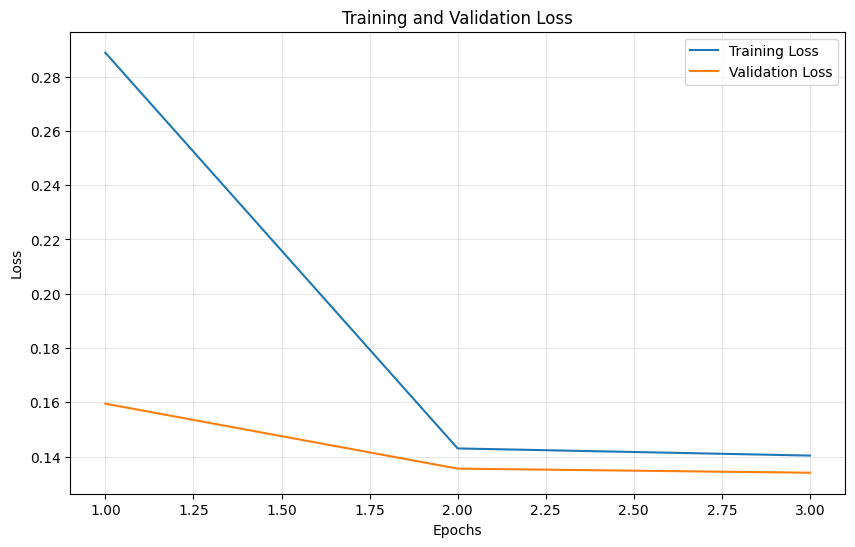

  Making predictions on test set...
Making predictions: 100%
 56/56 [02:38<00:00,  2.52s/it]
Applying post-processing...
Final model saved to /content/drive/MyDrive/scratch_detection_assignment/wafer_scratch_model.pth

--- Business Impact Analysis ---
Total wafers analyzed: 455
Total dies analyzed: 1128335
Overall yield: 92.07%
Wafers with detected scratches: 194 (42.64%)
Low-yield wafers (no scratch detection): 9 (1.98%)
Total dies marked as scratch: 3036 (0.27%)

Aspect ratio statistics of detected scratch clusters:
  Min: 3.00
  Max: 20.00
  Mean: 4.28
  Median: 3.50

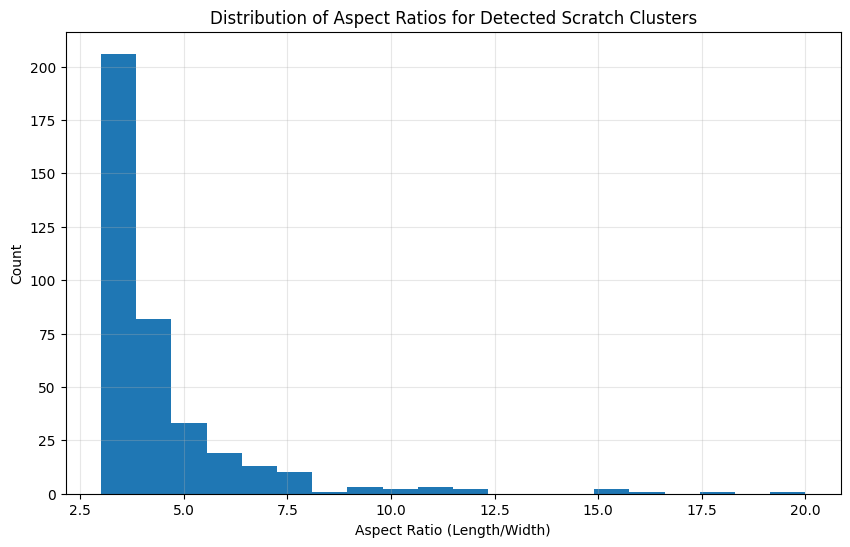



### Model Training Analysis
---
I observed that the **loss curve decreases steeply** until the second epoch, then decreases more moderately during the third epoch.

The **validation loss curve is slightly lower than the training loss curve**. In some cases, this might be indicative of overfitting. **Overfitting** occurs when a model learns the training data too well, including its noise and irrelevant details. This leads to excellent performance on the training set but poor generalization to new, unseen data.

However, a validation loss curve that's slightly lower than the training loss curve isn't always a bad sign.

Here are additional reasons for a lower validation loss:

* **Different Calculation Timing**: Training loss is often calculated and reported throughout each epoch, perhaps after each batch of training data. Validation loss, on the other hand, is usually calculated only once at the end of each epoch, after the model has been updated. This means the validation loss is evaluated on a slightly more refined model than the average model state used to calculate the training loss.

* **Data Distribution**: In some cases, it's possible that the validation dataset is slightly "easier" to predict than the training dataset. This could be due to subtle differences in the distribution of the data. However, this is less common and something you should investigate to ensure your validation set is representative.

In this case, I think that the **different calculation timing is likely the primary reason** for the lower validation loss.

Next, I will visualize the model's predictions on the test dataset to assess its performance and identify any potential issues, such as overfitting, during training.

In [ ]:
def visualize_raw_predictions(model, test_loader, device, num_samples=3):
    """
    Visualize raw predictions from the UNet before post-processing

    Args:
        model: The trained UNet model
        test_loader: DataLoader for test data
        device: Device to run inference on (cuda/cpu)
        num_samples: Number of wafers to visualize
    """
    model.eval()

    samples_seen = 0
    with torch.no_grad():
        for batch in test_loader:
            if samples_seen >= num_samples:
                break

            wafer_names = batch['wafer_name']
            condition = batch['condition'].to(device)
            coords_list = batch['coords']

            # Fixed timestep for UNet
            timestep = torch.zeros(condition.shape[0], device=device).long()

            # Get raw model predictions
            raw_preds = model(condition, timestep).sample
            sigmoid_preds = torch.sigmoid(raw_preds).cpu().numpy()

            # Process each wafer in the batch
            for i, wafer_name in enumerate(wafer_names):
                if samples_seen >= num_samples:
                    break

                samples_seen += 1

                # Get the raw prediction map and input condition
                input_map = condition[i, 0].cpu().numpy()
                pred_map = sigmoid_preds[i, 0]  # Raw probabilities before thresholding

                # Create a figure with two subplots
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

                # Plot input wafer map (0: good die, 1: bad die)
                ax1.imshow(input_map, cmap='gray', vmin=0, vmax=1)
                ax1.set_title(f'Input - Wafer: {wafer_name}\nGood Dies (black), Bad Dies (white)', fontsize=14)
                ax1.axis('off')

                # Plot raw prediction probabilities as a heatmap
                im = ax2.imshow(pred_map, cmap='plasma', vmin=0, vmax=1)
                ax2.set_title(f'Raw UNet Prediction - Wafer: {wafer_name}\nProbability of being scratch', fontsize=14)
                ax2.axis('off')

                # Add colorbar for the prediction heatmap
                cbar = plt.colorbar(im, ax=ax2)
                cbar.set_label('Scratch Probability')

                plt.tight_layout()
                plt.show()

                # Also show thresholded predictions at different thresholds
                fig, axes = plt.subplots(1, 3, figsize=(18, 6))

                thresholds = [0.3, 0.5, 0.7]
                for j, threshold in enumerate(thresholds):
                    binary_pred = pred_map > threshold
                    axes[j].imshow(binary_pred, cmap='Blues')
                    axes[j].set_title(f'Threshold = {threshold}', fontsize=14)
                    axes[j].axis('off')

                plt.suptitle(f'Binary Predictions at Different Thresholds - Wafer: {wafer_name}', fontsize=16)
                plt.tight_layout()
                plt.show()

                print(f"Wafer: {wafer_name}")
                print(f"Mean prediction probability: {np.mean(pred_map):.4f}")
                print(f"Max prediction probability: {np.max(pred_map):.4f}")
                print(f"% of pixels above threshold 0.5: {np.mean(pred_map > 0.5):.2%}")
                print("-" * 60)

def visualize_validation_results(val_df, model, device, num_samples=3):
    """
    Visualize validation wafers with ground truth scratch dies alongside model predictions and post-processing.

    Args:
        val_df: The validation DataFrame with ground truth labels
        model: The trained UNet model
        device: Device to run the model on (CPU/GPU)
        num_samples: Number of wafers to sample and visualize
    """
    model.eval()

    # Create a dataset from the validation dataframe
    val_dataset = WaferMapDataset(val_df, wafer_size=64, yield_threshold=0.4, augment=False)

    # Create a DataLoader with batch_size=1 for visualization
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

    # Dictionary to track wafers we've visualized
    visualized_wafers = []

    with torch.no_grad():
        for batch in val_loader:
            if len(visualized_wafers) >= num_samples:
                break

            wafer_name = batch['wafer_name'][0]
            condition = batch['condition'].to(device)
            target = batch['target']
            coords = batch['coords'][0]
            indices = batch['indices'][0]

            # Skip if we've already visualized this wafer
            if wafer_name in visualized_wafers:
                continue

            visualized_wafers.append(wafer_name)

            # Get the wafer dataframe from the validation dataset
            wafer_df = val_df[val_df['WaferName'] == wafer_name].copy()

            # Make model prediction
            timestep = torch.zeros(condition.shape[0], device=device).long()
            pred = model(condition, timestep).sample
            pred_prob = torch.sigmoid(pred).cpu().numpy()[0, 0]
            pred_binary = pred_prob > 0.5  # Apply threshold

            # Create prediction dataframe
            pred_df = wafer_df.copy()
            pred_df['ModelPrediction'] = False  # Add column for model predictions

            # Map predictions back to original dies
            # Calculate min/max for scaling
            x_values = [c[0] for c in coords]
            y_values = [c[1] for c in coords]
            x_min, x_max = min(x_values), max(x_values)
            y_min, y_max = min(y_values), max(y_values)
            x_range = max(1, x_max - x_min)
            y_range = max(1, y_max - y_min)

            # Map predictions to original indices
            for j, (die_x, die_y) in enumerate(coords):
                if j >= len(indices):
                    continue

                # Calculate grid indices
                x = int((die_x - x_min) / x_range * (pred_binary.shape[1] - 1))
                y = int((die_y - y_min) / y_range * (pred_binary.shape[0] - 1))

                # Ensure valid indices
                x = min(max(0, x), pred_binary.shape[1] - 1)
                y = min(max(0, y), pred_binary.shape[0] - 1)

                # Set prediction in dataframe
                idx = indices[j]
                if idx in pred_df.index:
                    pred_df.loc[idx, 'ModelPrediction'] = bool(pred_binary[y, x])

            # Create a copy for post-processing
            post_proc_df = pred_df.copy()
            post_proc_df['IsScratchDie'] = post_proc_df['ModelPrediction']

            # Apply post-processing to model predictions
            post_processed_df = improved_post_processing(post_proc_df)

            # Merge back with original dataframe to get post-processed predictions
            pred_df['PostProcessed'] = False
            for idx in post_processed_df.index:
                if idx in pred_df.index:
                    pred_df.loc[idx, 'PostProcessed'] = post_processed_df.loc[idx, 'IsScratchDie']

            # Create a figure with three subplots
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

            # Calculate point size based on wafer size
            wafer_size = len(wafer_df)
            point_size = max(10, min(50, 5000 / np.sqrt(wafer_size)))

            # Plot 1: Ground Truth
            ax1.set_title(f"Ground Truth - Wafer: {wafer_name}\nGood (green), Bad (red), Scratch (blue), Ink (yellow)",
                          fontsize=14)

            # Plot good non-scratch dies in green
            good_non_scratch = wafer_df[wafer_df['IsGoodDie'] & ~wafer_df['IsScratchDie']]
            ax1.scatter(good_non_scratch['DieX'], good_non_scratch['DieY'], color='green', marker='s', s=point_size)

            # Plot bad non-scratch dies in red
            bad_non_scratch = wafer_df[~wafer_df['IsGoodDie'] & ~wafer_df['IsScratchDie']]
            ax1.scatter(bad_non_scratch['DieX'], bad_non_scratch['DieY'], color='red', marker='s', s=point_size)

            # Plot bad scratch dies in blue
            bad_scratch = wafer_df[~wafer_df['IsGoodDie'] & wafer_df['IsScratchDie']]
            ax1.scatter(bad_scratch['DieX'], bad_scratch['DieY'], color='blue', marker='s', s=point_size)

            # Plot good scratch dies (ink) in yellow
            good_scratch = wafer_df[wafer_df['IsGoodDie'] & wafer_df['IsScratchDie']]
            ax1.scatter(good_scratch['DieX'], good_scratch['DieY'], color='yellow', marker='s', s=point_size)

            ax1.legend(['Good Die', 'Bad Die', 'Scratch Die (Bad)', 'Ink Die (Good)'])
            ax1.set_aspect('equal')
            ax1.axis('off')

            # Plot 2: Raw Model Predictions
            ax2.set_title(f"Raw Model Predictions - Wafer: {wafer_name}\nGood (green), Bad (red), Scratch (blue), Ink (yellow)",
                          fontsize=14)

            # Plot good non-scratch dies in green
            good_non_scratch = pred_df[pred_df['IsGoodDie'] & ~pred_df['ModelPrediction']]
            ax2.scatter(good_non_scratch['DieX'], good_non_scratch['DieY'], color='green', marker='s', s=point_size)

            # Plot bad non-scratch dies in red
            bad_non_scratch = pred_df[~pred_df['IsGoodDie'] & ~pred_df['ModelPrediction']]
            ax2.scatter(bad_non_scratch['DieX'], bad_non_scratch['DieY'], color='red', marker='s', s=point_size)

            # Plot bad scratch dies in blue
            bad_scratch = pred_df[~pred_df['IsGoodDie'] & pred_df['ModelPrediction']]
            ax2.scatter(bad_scratch['DieX'], bad_scratch['DieY'], color='blue', marker='s', s=point_size)

            # Plot good scratch dies (ink) in yellow
            good_scratch = pred_df[pred_df['IsGoodDie'] & pred_df['ModelPrediction']]
            ax2.scatter(good_scratch['DieX'], good_scratch['DieY'], color='yellow', marker='s', s=point_size)

            ax2.legend(['Good Die', 'Bad Die', 'Scratch Die (Bad)', 'Ink Die (Good)'])
            ax2.set_aspect('equal')
            ax2.axis('off')

            # Plot 3: Post-processed Predictions
            ax3.set_title(f"Post-processed Predictions - Wafer: {wafer_name}\nGood (green), Bad (red), Scratch (blue), Ink (yellow)",
                          fontsize=14)

            # Plot good non-scratch dies in green
            good_non_scratch = pred_df[pred_df['IsGoodDie'] & ~pred_df['PostProcessed']]
            ax3.scatter(good_non_scratch['DieX'], good_non_scratch['DieY'], color='green', marker='s', s=point_size)

            # Plot bad non-scratch dies in red
            bad_non_scratch = pred_df[~pred_df['IsGoodDie'] & ~pred_df['PostProcessed']]
            ax3.scatter(bad_non_scratch['DieX'], bad_non_scratch['DieY'], color='red', marker='s', s=point_size)

            # Plot bad scratch dies in blue
            bad_scratch = pred_df[~pred_df['IsGoodDie'] & pred_df['PostProcessed']]
            ax3.scatter(bad_scratch['DieX'], bad_scratch['DieY'], color='blue', marker='s', s=point_size)

            # Plot good scratch dies (ink) in yellow
            good_scratch = pred_df[pred_df['IsGoodDie'] & pred_df['PostProcessed']]
            ax3.scatter(good_scratch['DieX'], good_scratch['DieY'], color='yellow', marker='s', s=point_size)

            ax3.legend(['Good Die', 'Bad Die', 'Scratch Die (Bad)', 'Ink Die (Good)'])
            ax3.set_aspect('equal')
            ax3.axis('off')

            plt.tight_layout()
            plt.show()

            # Print statistics and metrics
            print(f"Wafer: {wafer_name}")
            print(f"Total dies: {len(wafer_df)}")
            print(f"Good dies: {wafer_df['IsGoodDie'].sum()} ({wafer_df['IsGoodDie'].mean():.2%})")
            print(f"Bad dies: {(~wafer_df['IsGoodDie']).sum()}")

            # Ground truth statistics
            gt_scratch_total = wafer_df['IsScratchDie'].sum()
            gt_scratch_bad = ((~wafer_df['IsGoodDie']) & wafer_df['IsScratchDie']).sum()
            gt_scratch_good = (wafer_df['IsGoodDie'] & wafer_df['IsScratchDie']).sum()

            print("\nGround Truth:")
            print(f"- Total scratch dies: {gt_scratch_total}")
            print(f"- Bad dies marked as scratch: {gt_scratch_bad}")
            print(f"- Good dies marked as scratch (ink): {gt_scratch_good}")

            # Raw model prediction statistics
            pred_scratch_total = pred_df['ModelPrediction'].sum()
            pred_scratch_bad = ((~pred_df['IsGoodDie']) & pred_df['ModelPrediction']).sum()
            pred_scratch_good = (pred_df['IsGoodDie'] & pred_df['ModelPrediction']).sum()

            print("\nRaw Model Predictions:")
            print(f"- Total scratch dies: {pred_scratch_total}")
            print(f"- Bad dies marked as scratch: {pred_scratch_bad}")
            print(f"- Good dies marked as scratch (ink): {pred_scratch_good}")

            # Post-processed prediction statistics
            post_scratch_total = pred_df['PostProcessed'].sum()
            post_scratch_bad = ((~pred_df['IsGoodDie']) & pred_df['PostProcessed']).sum()
            post_scratch_good = (pred_df['IsGoodDie'] & pred_df['PostProcessed']).sum()

            print("\nPost-processed Predictions:")
            print(f"- Total scratch dies: {post_scratch_total}")
            print(f"- Bad dies marked as scratch: {post_scratch_bad}")
            print(f"- Good dies marked as scratch (ink): {post_scratch_good}")

            # Calculate metrics
            from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

            # For raw model predictions
            y_true = wafer_df['IsScratchDie'].values
            y_pred_raw = pred_df['ModelPrediction'].values
            y_pred_post = pred_df['PostProcessed'].values

            # Calculate metrics for raw predictions
            precision_raw, recall_raw, f1_raw, _ = precision_recall_fscore_support(
                y_true, y_pred_raw, average='binary')

            # Calculate metrics for post-processed predictions
            precision_post, recall_post, f1_post, _ = precision_recall_fscore_support(
                y_true, y_pred_post, average='binary')

            print("\nPerformance Metrics:")
            print("Raw Model Predictions:")
            print(f"- Precision: {precision_raw:.4f}")
            print(f"- Recall: {recall_raw:.4f}")
            print(f"- F1 Score: {f1_raw:.4f}")

            print("\nPost-processed Predictions:")
            print(f"- Precision: {precision_post:.4f}")
            print(f"- Recall: {recall_post:.4f}")
            print(f"- F1 Score: {f1_post:.4f}")

            # Print confusion matrices
            print("\nConfusion Matrix - Raw Model Predictions:")
            cm_raw = confusion_matrix(y_true, y_pred_raw)
            print(cm_raw)

            print("\nConfusion Matrix - Post-processed Predictions:")
            cm_post = confusion_matrix(y_true, y_pred_post)
            print(cm_post)

            print("-" * 80)

# Load the saved model before visualization
def load_saved_model(model_path, device):
    """
    Load a saved model from a checkpoint file

    Args:
        model_path: Path to the saved model checkpoint
        device: Device to load the model on (cuda/cpu)

    Returns:
        The loaded model
    """
    # Initialize a fresh model
    model = setup_model(device)

    # Load the state dict
    print(f"Loading model from {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode

    return model

# Usage example - add this where you want to visualize raw predictions
checkpoint_dir = "/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment"
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")

if os.path.exists(best_model_path):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the model
    model = load_saved_model(best_model_path, device)

    # Create a test dataset and loader
    test_dataset = WaferMapDataset(df_wafers_test, wafer_size=64, yield_threshold=0.4, augment=False)
    test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=custom_collate_fn)

    # Visualize raw predictions
    print("Visualizing raw UNet predictions before post-processing...")
    visualize_raw_predictions(model, test_loader, device, num_samples=3)
else:
    print(f"Model checkpoint not found at {best_model_path}")

Loading model from /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/best_model.pth
Using 446 wafers after filtering low-yield wafers (threshold: 0.4)
Visualizing raw UNet predictions before post-processing...

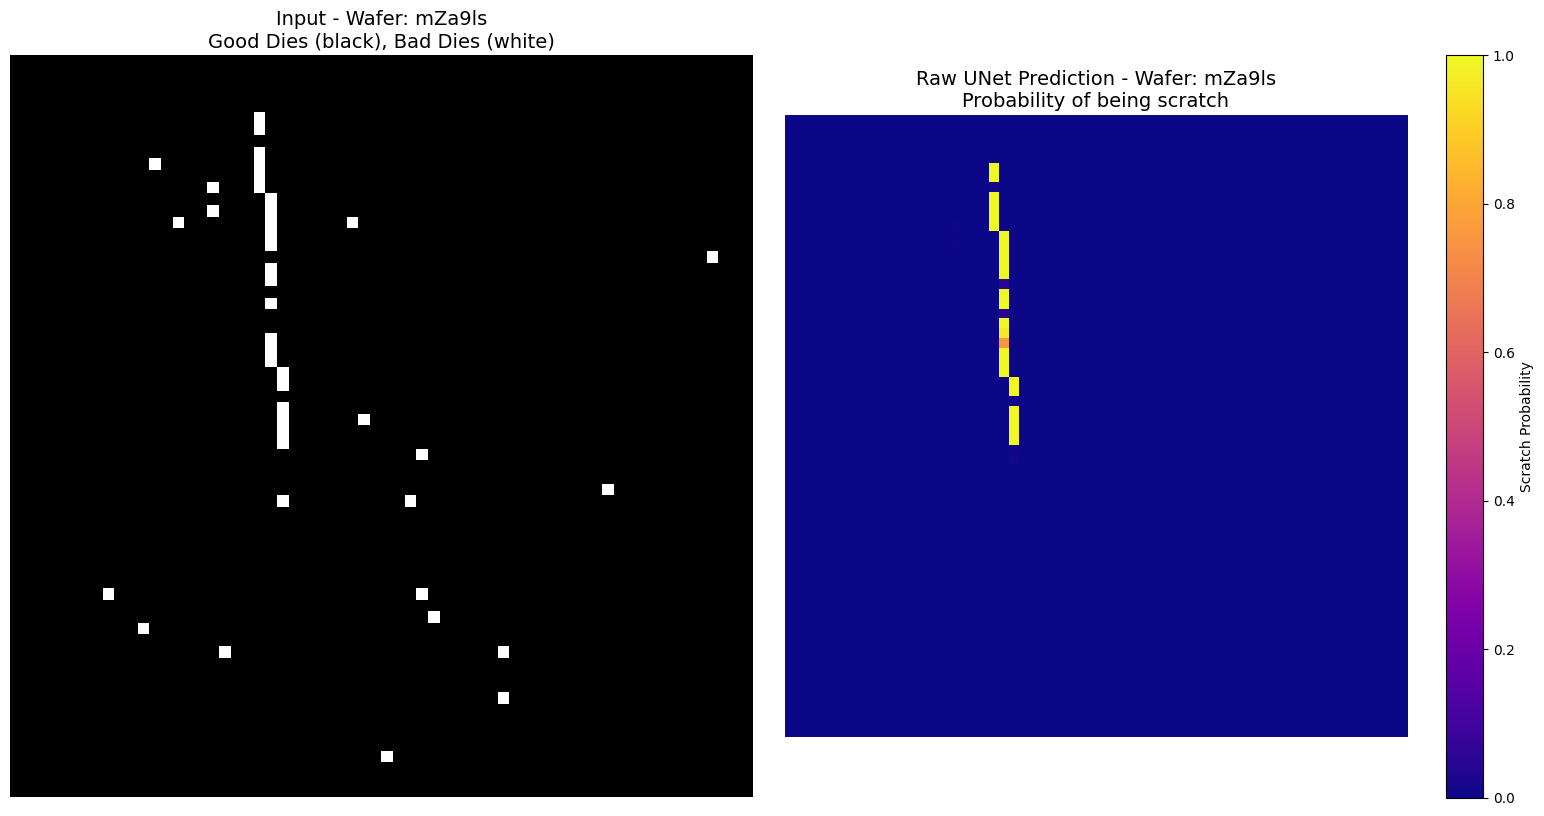

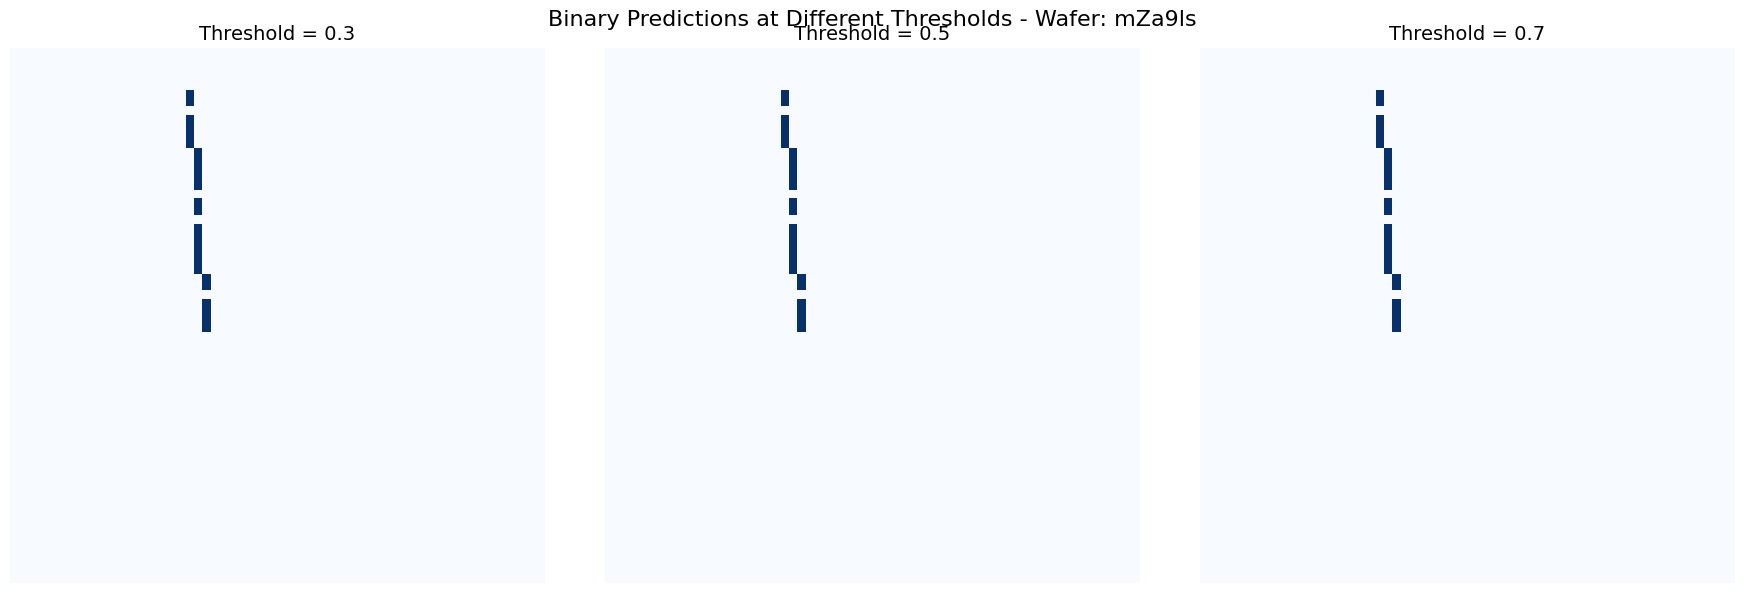

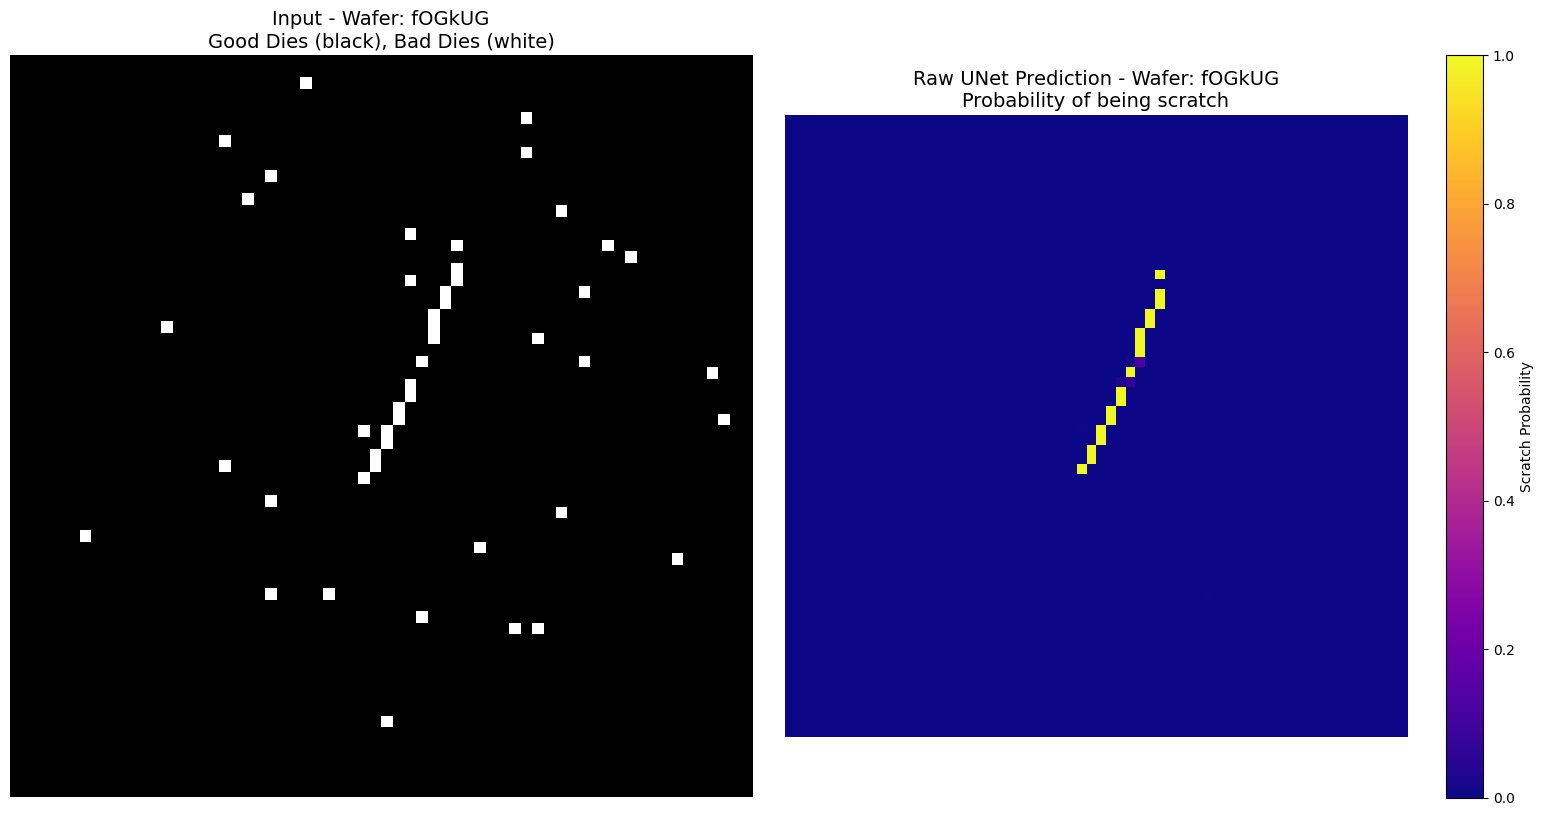


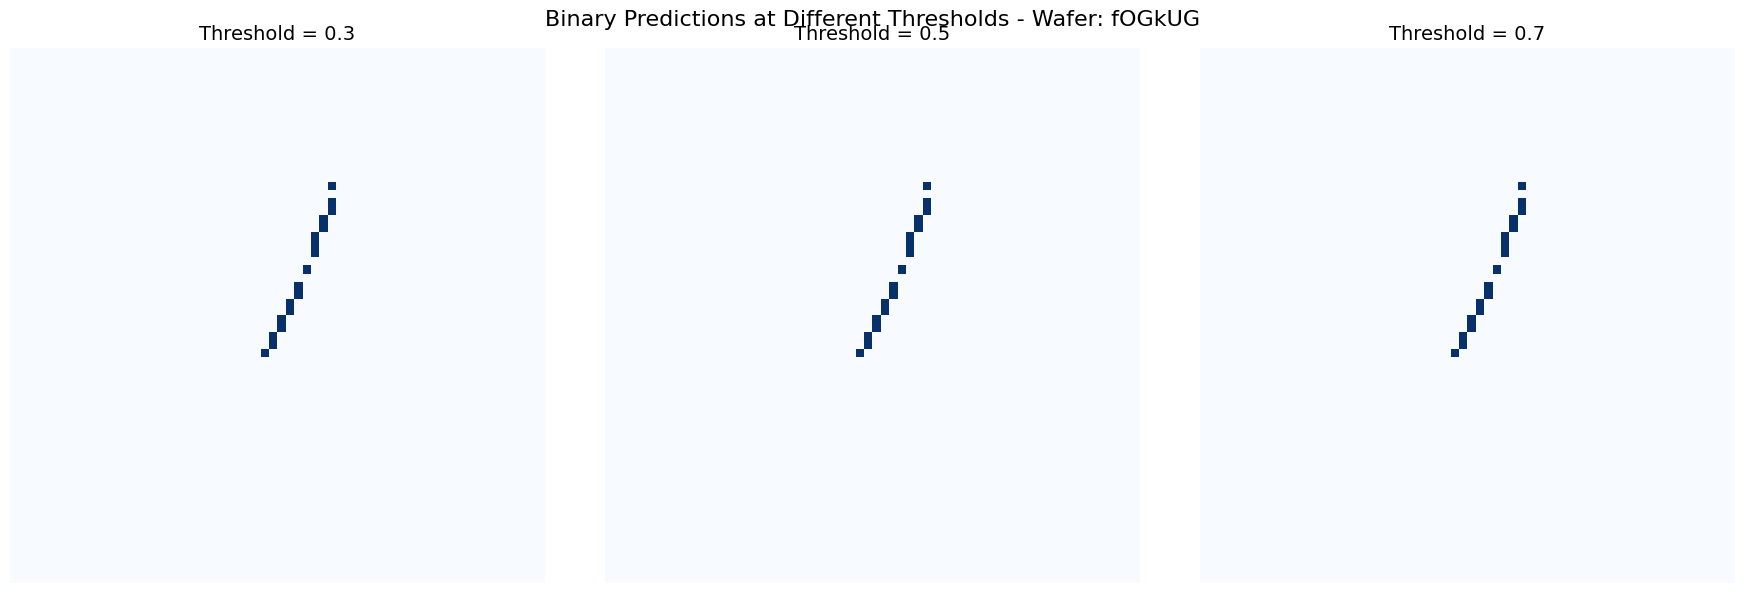

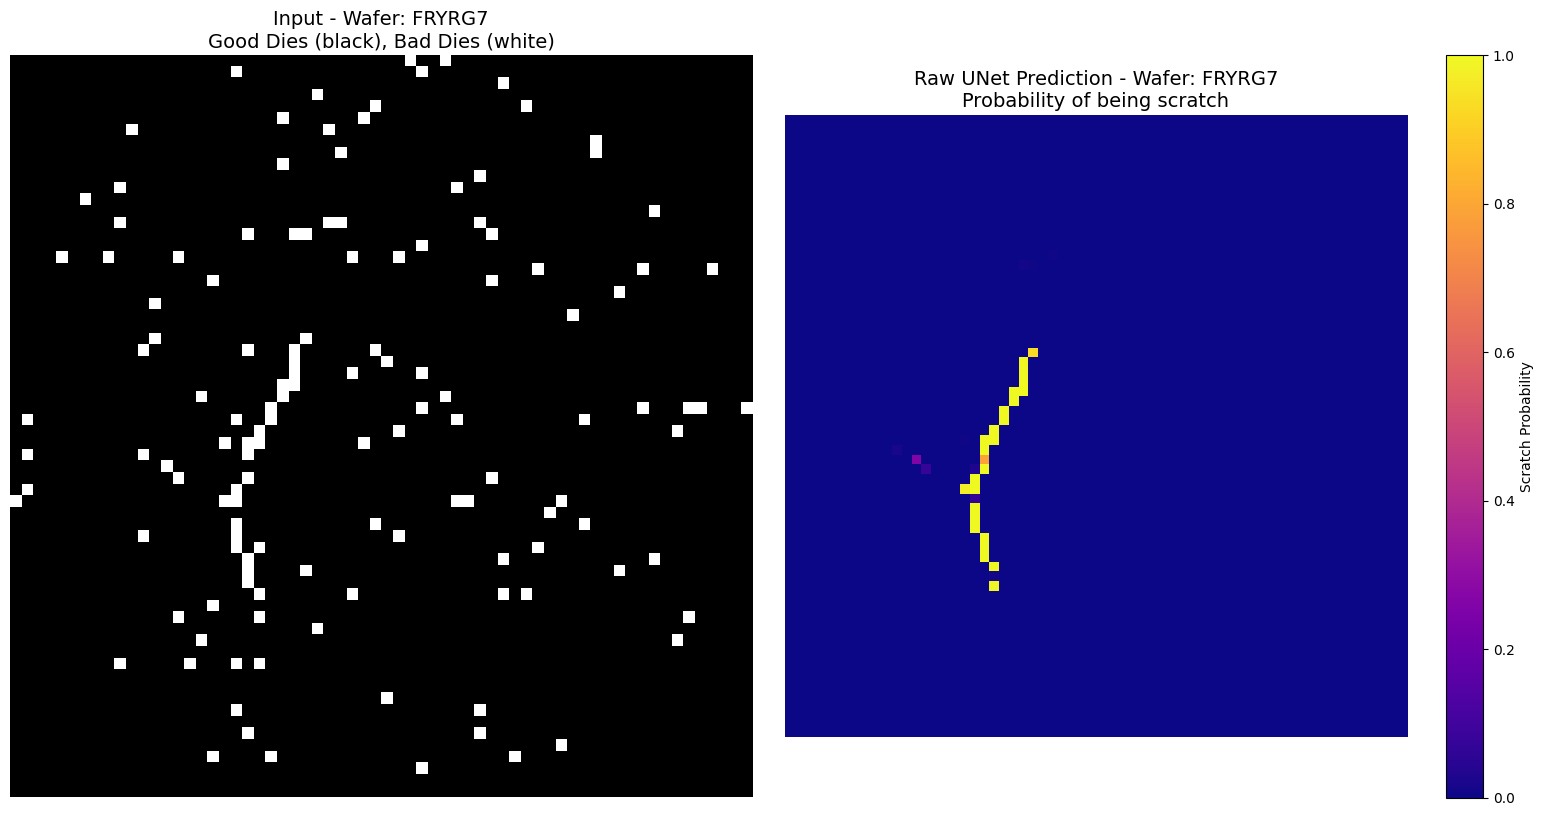

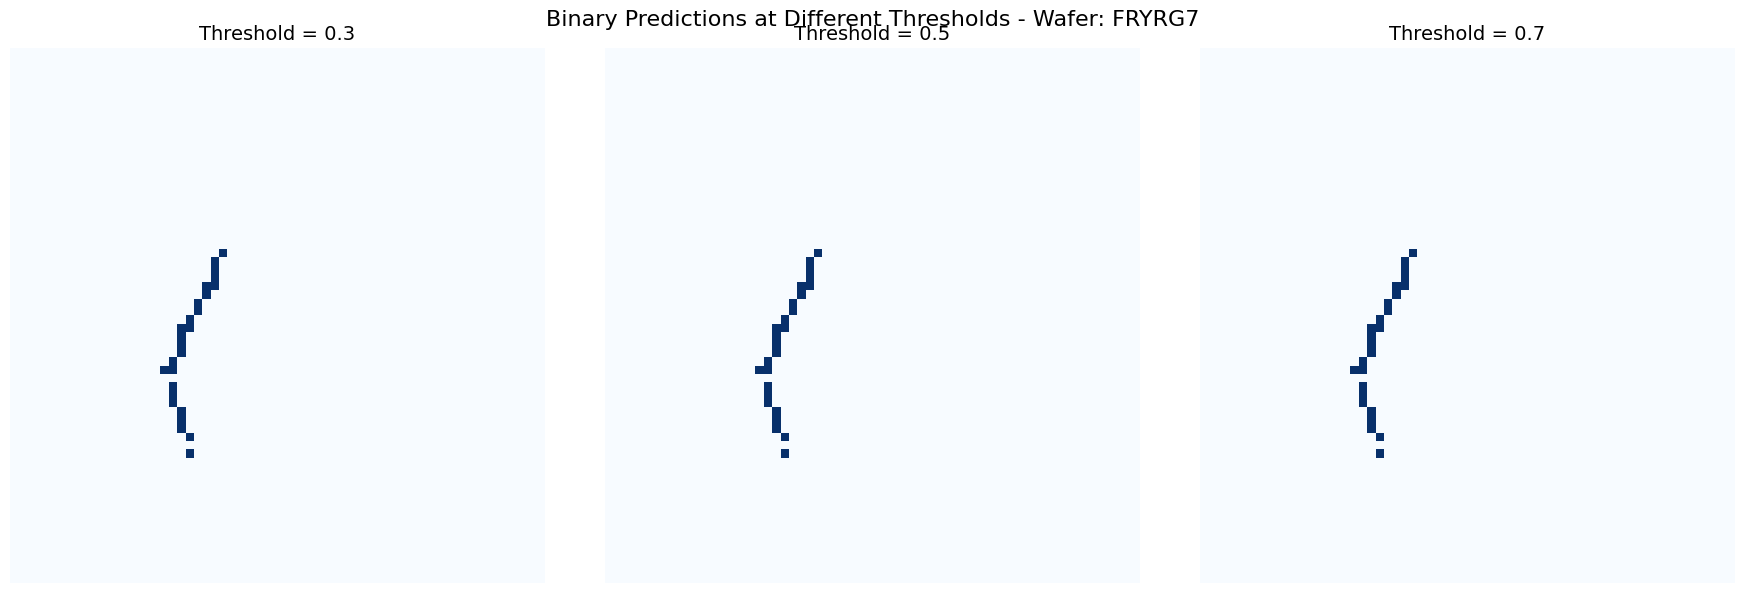

### Outputs Analysis

According to the outputs, the model effectively distinguishes most scratch structures from noise, with no visible difference between different threshold values. This suggests the model reliably detects defective dies within the scratches. Additionally, the raw UNet predictions color inked dies in purple/pink, indicating that the UNet can partially predict inked dies with low probability. Therefore, inked die prediction likely needs improvement.

Next, I will use additional visualization functions to further analyze the model's predictions and gain insights for the remaining task

In [ ]:
def visualize_test_vs_predictions(test_df, predictions_df, num_samples=3):
    """
    Visualize test wafers next to the same wafers with scratch predictions.

    Args:
        test_df: Original test DataFrame (with IsGoodDie but no IsScratchDie)
        predictions_df: Test DataFrame with predictions (includes IsScratchDie column)
        num_samples: Number of wafers to sample and visualize
    """
    # Sample wafers that have scratches for more interesting visualization
    sample_wafers = predictions_df.groupby('WaferName')['IsScratchDie'].sum()
    scratch_wafers = sample_wafers[sample_wafers > 0].index.tolist()

    if len(scratch_wafers) > num_samples:
        import random
        scratch_wafers = random.sample(scratch_wafers, num_samples)
    elif len(scratch_wafers) == 0:
        # If no scratches found, just sample random wafers
        scratch_wafers = predictions_df['WaferName'].unique()[:num_samples]

    # Visualize each sampled wafer
    for wafer_name in scratch_wafers:
        test_wafer = test_df[test_df['WaferName'] == wafer_name].copy()
        pred_wafer = predictions_df[predictions_df['WaferName'] == wafer_name].copy()

        # Create plot with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        # Calculate point size based on wafer size
        wafer_size = len(test_wafer)
        point_size = max(10, min(50, 5000 / np.sqrt(wafer_size)))

        # Left plot - Original test data (input)
        ax1.set_title(f"Input - Wafer: {wafer_name}\nGood Dies (green), Bad Dies (red)", fontsize=16)

        # Plot good dies in green
        good_dies = test_wafer[test_wafer['IsGoodDie']]
        ax1.scatter(good_dies['DieX'], good_dies['DieY'], color='green', marker='s', s=point_size)

        # Plot bad dies in red
        bad_dies = test_wafer[~test_wafer['IsGoodDie']]
        ax1.scatter(bad_dies['DieX'], bad_dies['DieY'], color='red', marker='s', s=point_size)

        ax1.legend(['Good Die', 'Bad Die'])
        ax1.set_aspect('equal')
        ax1.axis('off')

        # Right plot - Predictions
        ax2.set_title(f"Predictions - Wafer: {wafer_name}\nGood (green), Bad (red), Scratch (blue), Ink (yellow)",
                      fontsize=16)

        # Plot all good dies in green first
        good_dies = pred_wafer[pred_wafer['IsGoodDie'] & ~pred_wafer['IsScratchDie']]
        ax2.scatter(good_dies['DieX'], good_dies['DieY'], color='green', marker='s', s=point_size)

        # Plot bad non-scratch dies in red
        bad_dies = pred_wafer[~pred_wafer['IsGoodDie'] & ~pred_wafer['IsScratchDie']]
        ax2.scatter(bad_dies['DieX'], bad_dies['DieY'], color='red', marker='s', s=point_size)

        # Plot bad scratch dies in blue
        scratch_bad = pred_wafer[~pred_wafer['IsGoodDie'] & pred_wafer['IsScratchDie']]
        ax2.scatter(scratch_bad['DieX'], scratch_bad['DieY'], color='blue', marker='s', s=point_size)

        # Plot good scratch dies (ink) in yellow
        scratch_good = pred_wafer[pred_wafer['IsGoodDie'] & pred_wafer['IsScratchDie']]
        ax2.scatter(scratch_good['DieX'], scratch_good['DieY'], color='yellow', marker='s', s=point_size)

        ax2.legend(['Good Die', 'Bad Die', 'Scratch Die (Bad)', 'Ink Die (Good)'])
        ax2.set_aspect('equal')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"Wafer: {wafer_name}")
        print(f"Total dies: {len(pred_wafer)}")
        print(f"Good dies: {pred_wafer['IsGoodDie'].sum()} ({pred_wafer['IsGoodDie'].mean():.2%})")
        print(f"Bad dies: {(~pred_wafer['IsGoodDie']).sum()}")
        print(f"Predicted scratch dies: {pred_wafer['IsScratchDie'].sum()}")
        print(f"- Bad dies marked as scratch: {((~pred_wafer['IsGoodDie']) & (pred_wafer['IsScratchDie'])).sum()}")
        print(f"- Good dies marked as scratch (ink): {((pred_wafer['IsGoodDie']) & (pred_wafer['IsScratchDie'])).sum()}")
        print("-" * 60)

In [ ]:
# Visualize test predictions
print("Visualizing test predictions...")
visualize_test_vs_predictions(df_wafers_test, df_predictions, num_samples=5)  # Adjust number as needed

# Evaluate business impact
business_metrics = evaluate_business_impact(df_predictions)

Visualizing test predictions...
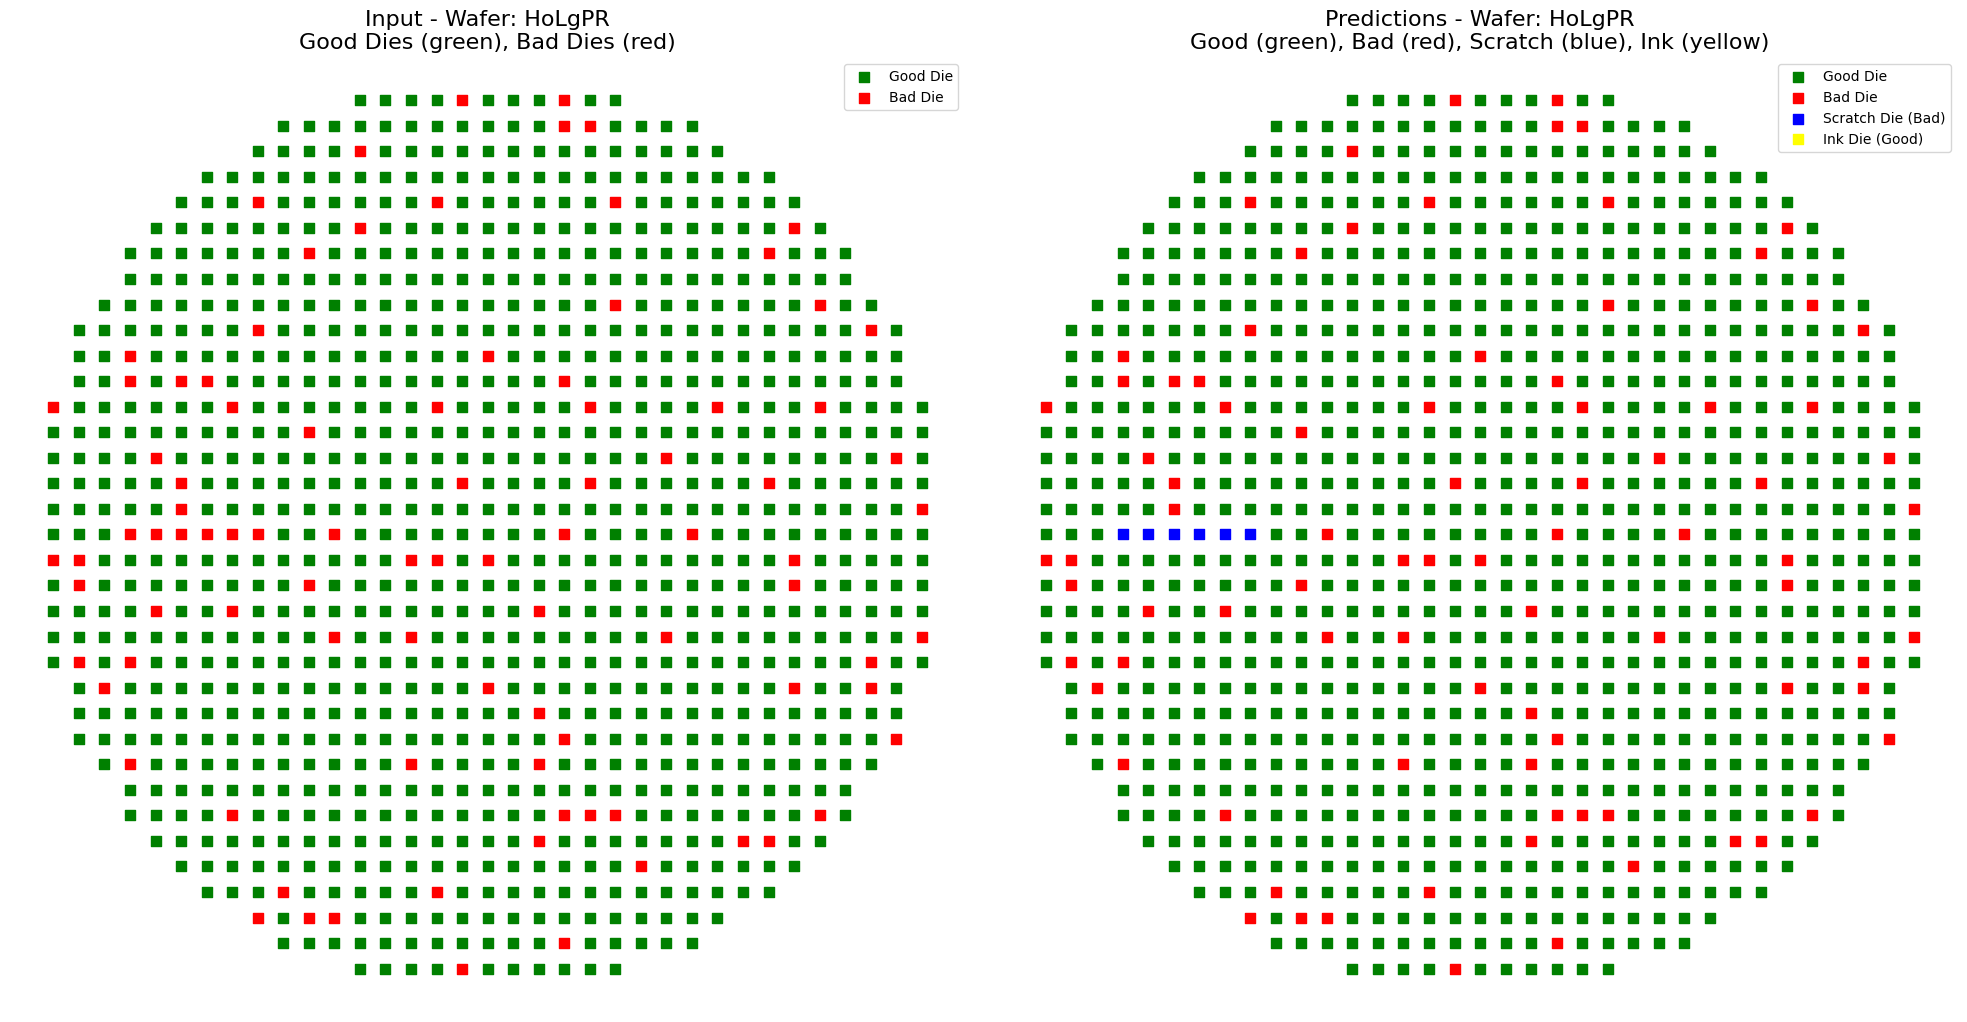

Wafer: HoLgPR
Total dies: 1005
Good dies: 913 (90.85%)
Bad dies: 92
Predicted scratch dies: 6
- Bad dies marked as scratch: 6
- Good dies marked as scratch (ink): 0

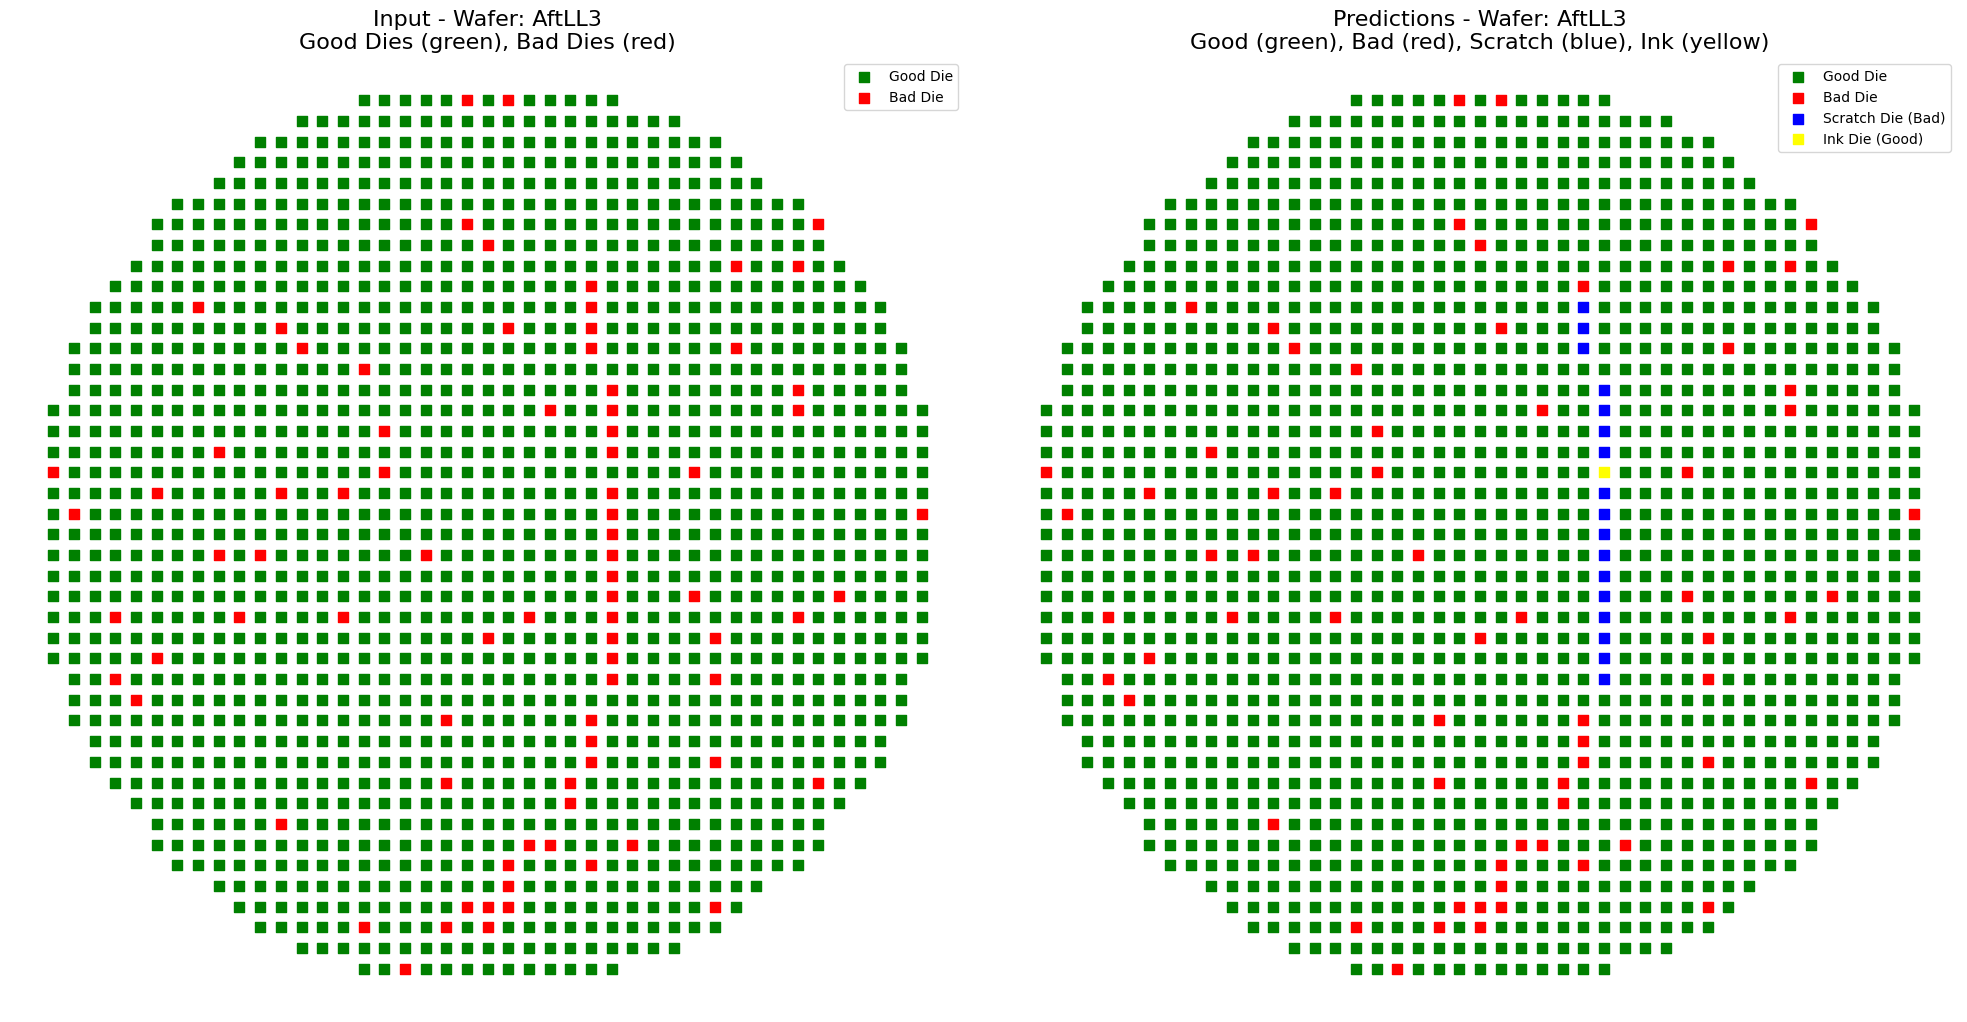

Wafer: AftLL3
Total dies: 1513
Good dies: 1429 (94.45%)
Bad dies: 84
Predicted scratch dies: 18
- Bad dies marked as scratch: 17
- Good dies marked as scratch (ink): 1


#Output Analysis

The model appears to perform well in identifying defective dies. However, I've observed a specific limitation: it tends to detect inked dies more accurately when the scratch is either vertical or horizontal. The model seems to struggle with detecting both defective and inked dies when the scratches are curved or diagonal. To address this limitation, I plan to refine the model’s architecture to enhance its ability to detect such cases more accurately.

#  MY ENHANCED SOLUTION: ENHANCED HYBRID MODEL

### Architecture Overview
MY solution combines multiple state-of-the-art approaches:

1. **UNet Backbone**: Semantic segmentation for initial scratch detection
2. **Perception Encoder (PE)**: Global context understanding
3. **SmolVLM Integration**: Vision-language model for pattern reasoning (I will try to train with and without the smolVLM to check if the basic smolvlm improves the model performance)
4. **Multi-Task Learning**: Separate heads for scratch and ink detection
5. **Adaptive Processing**: Context-aware thresholding and post-processing

### Key Innovations
-  **Targeted Loss Function**: 5x weight for ink dies
-  **Adaptive Thresholding**: Lower threshold (0.3) for potential ink regions
-  **Residual Blocks**: Better gradient flow and feature learning
-  **Spatial Attention**: Focus on elongated scratch patterns
-  **Context-Aware Post-Processing**: RANSAC line fitting for gap bridging


##  ARCHITECTURE VISUALIZATION

📊 Visualizing model architecture...


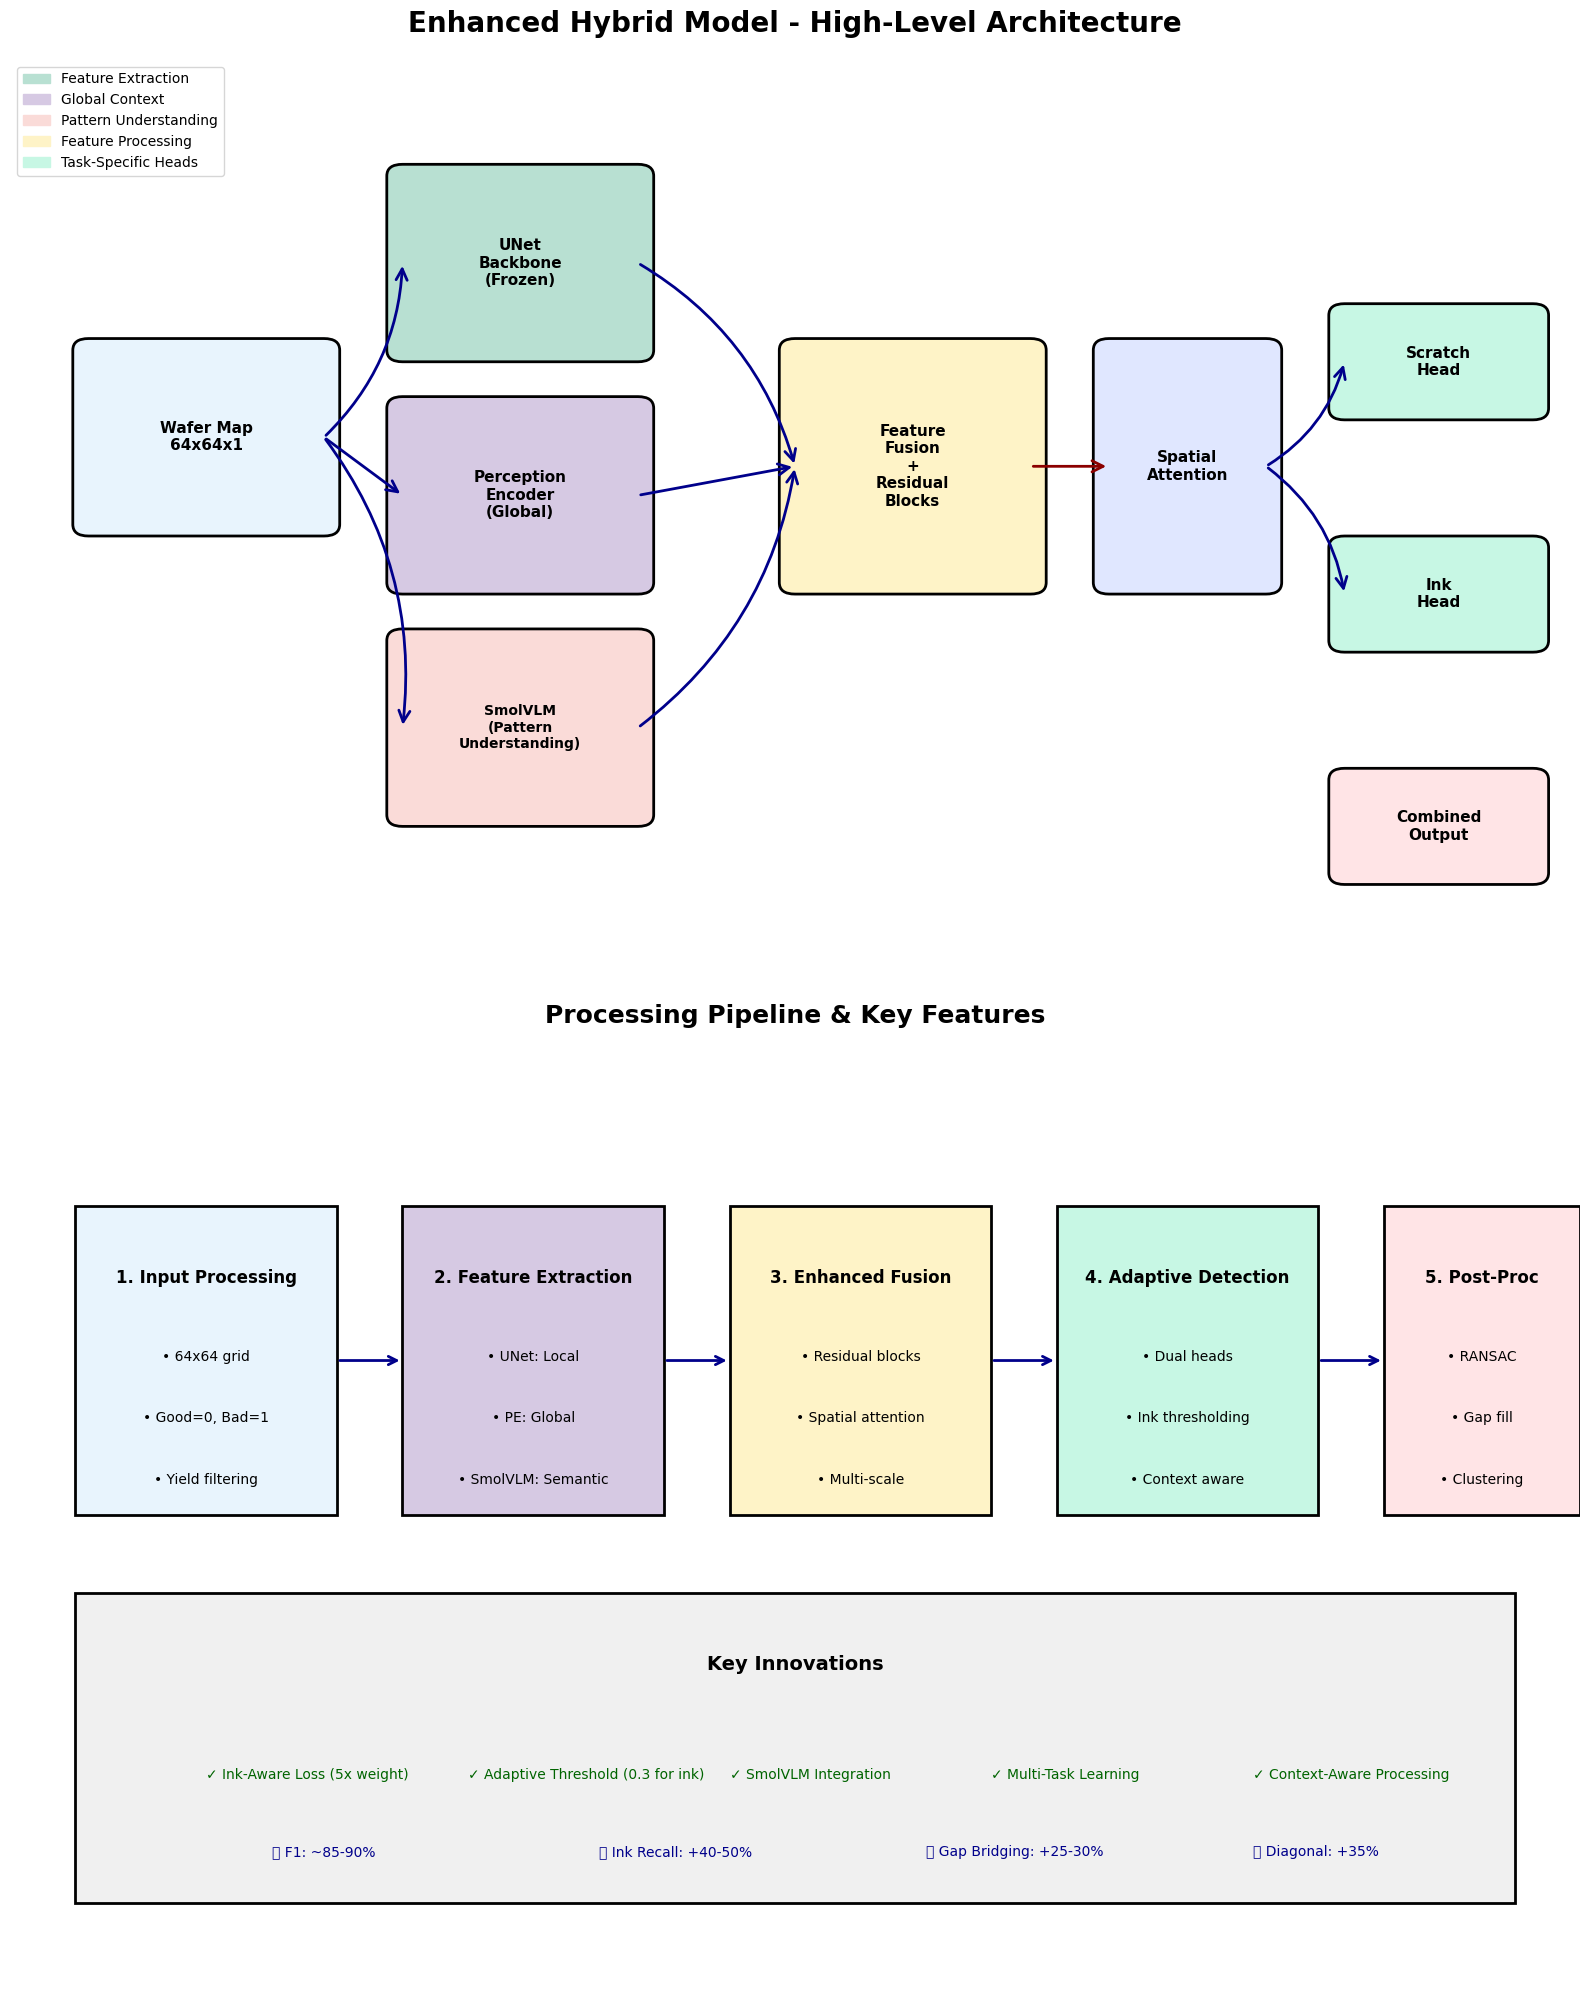

In [ ]:
def visualize_model_architecture():
   """
   Create a detailed visualization of the Enhanced Hybrid Model architecture
   """
   fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))

   # ========================================
   # Top Plot: High-Level Architecture Flow
   # ========================================
   ax1.set_xlim(0, 10)
   ax1.set_ylim(0, 8)
   ax1.axis('off')
   ax1.set_title('Enhanced Hybrid Model - High-Level Architecture', fontsize=20, fontweight='bold', pad=20)

   # Define component positions
   components = {
       'input': (0.5, 4, 1.5, 1.5),
       'unet': (2.5, 5.5, 1.5, 1.5),
       'pe': (2.5, 3.5, 1.5, 1.5),
       'smolvlm': (2.5, 1.5, 1.5, 1.5),
       'fusion': (5, 3.5, 1.5, 2),
       'attention': (7, 3.5, 1, 2),
       'scratch_head': (8.5, 5, 1.2, 0.8),
       'ink_head': (8.5, 3, 1.2, 0.8),
       'output': (8.5, 1, 1.2, 0.8)
   }

   # Colors for different components
   colors = {
       'input': '#E8F4FD',
       'unet': '#B8E0D2',
       'pe': '#D6C9E3',
       'smolvlm': '#FADBD8',
       'fusion': '#FEF3C7',
       'attention': '#E0E7FF',
       'heads': '#C7F7E4',
       'output': '#FFE4E6'
   }

   # Draw components
   for comp_name, (x, y, w, h) in components.items():
       if comp_name == 'input':
           color = colors['input']
           text = 'Wafer Map\n64x64x1'
       elif comp_name == 'unet':
           color = colors['unet']
           text = 'UNet\nBackbone\n(Frozen)'
       elif comp_name == 'pe':
           color = colors['pe']
           text = 'Perception\nEncoder\n(Global)'
       elif comp_name == 'smolvlm':
           color = colors['smolvlm']
           text = 'SmolVLM\n(Pattern\nUnderstanding)'
       elif comp_name == 'fusion':
           color = colors['fusion']
           text = 'Feature\nFusion\n+\nResidual\nBlocks'
       elif comp_name == 'attention':
           color = colors['attention']
           text = 'Spatial\nAttention'
       elif comp_name == 'scratch_head':
           color = colors['heads']
           text = 'Scratch\nHead'
       elif comp_name == 'ink_head':
           color = colors['heads']
           text = 'Ink\nHead'
       else:
           color = colors['output']
           text = 'Combined\nOutput'

       box = FancyBboxPatch((x, y), w, h,
                           boxstyle="round,pad=0.1",
                           facecolor=color,
                           edgecolor='black',
                           linewidth=2)
       ax1.add_patch(box)
       ax1.text(x + w/2, y + h/2, text, ha='center', va='center',
               fontsize=10 if 'smolvlm' in comp_name else 11, fontweight='bold')

   # Draw arrows
   arrows = [
       ((2, 4.75), (2.5, 6.25), "arc3,rad=.2"),
       ((2, 4.75), (2.5, 4.25), "arc3,rad=0"),
       ((2, 4.75), (2.5, 2.25), "arc3,rad=-.2"),
       ((4, 6.25), (5, 4.5), "arc3,rad=-.2"),
       ((4, 4.25), (5, 4.5), "arc3,rad=0"),
       ((4, 2.25), (5, 4.5), "arc3,rad=.2"),
       ((6.5, 4.5), (7, 4.5), None),
       ((8, 4.5), (8.5, 5.4), "arc3,rad=.2"),
       ((8, 4.5), (8.5, 3.4), "arc3,rad=-.2")
   ]

   for start, end, style in arrows:
       if style:
           arrow = FancyArrowPatch(start, end,
                                 connectionstyle=style,
                                 arrowstyle='->',
                                 mutation_scale=20,
                                 linewidth=2,
                                 color='darkblue')
       else:
           arrow = FancyArrowPatch(start, end,
                                 arrowstyle='->',
                                 mutation_scale=20,
                                 linewidth=2,
                                 color='darkred')
       ax1.add_patch(arrow)

   # Add legend
   legend_elements = [
       patches.Patch(color=colors['unet'], label='Feature Extraction'),
       patches.Patch(color=colors['pe'], label='Global Context'),
       patches.Patch(color=colors['smolvlm'], label='Pattern Understanding'),
       patches.Patch(color=colors['fusion'], label='Feature Processing'),
       patches.Patch(color=colors['heads'], label='Task-Specific Heads')
   ]
   ax1.legend(handles=legend_elements, loc='upper left', fontsize=10)

   # ========================================
   # Bottom Plot: Processing Pipeline
   # ========================================
   ax2.set_xlim(0, 12)
   ax2.set_ylim(0, 6)
   ax2.axis('off')
   ax2.set_title('Processing Pipeline & Key Features', fontsize=18, fontweight='bold', pad=20)

   # Processing stages
   stages = [
       (0.5, 3, 2, 2, '#E8F4FD', '1. Input Processing', ['• 64x64 grid', '• Good=0, Bad=1', '• Yield filtering']),
       (3, 3, 2, 2, '#D6C9E3', '2. Feature Extraction', ['• UNet: Local', '• PE: Global', '• SmolVLM: Semantic']),
       (5.5, 3, 2, 2, '#FEF3C7', '3. Enhanced Fusion', ['• Residual blocks', '• Spatial attention', '• Multi-scale']),
       (8, 3, 2, 2, '#C7F7E4', '4. Adaptive Detection', ['• Dual heads', '• Ink thresholding', '• Context aware']),
       (10.5, 3, 1.5, 2, '#FFE4E6', '5. Post-Proc', ['• RANSAC', '• Gap fill', '• Clustering'])
   ]

   for x, y, w, h, color, title, items in stages:
       box = Rectangle((x, y), w, h, facecolor=color, edgecolor='black', linewidth=2)
       ax2.add_patch(box)
       ax2.text(x + w/2, y + h - 0.5, title, ha='center', fontweight='bold', fontsize=12)
       for i, item in enumerate(items):
           ax2.text(x + w/2, y + h - 1 - i*0.4, item, ha='center', fontsize=10)

   # Flow arrows
   for i in range(4):
       arrow = FancyArrowPatch((2.5 + i*2.5, 4), (3 + i*2.5, 4),
                              arrowstyle='->',
                              mutation_scale=15,
                              linewidth=2,
                              color='darkblue')
       ax2.add_patch(arrow)

   # Key innovations
   innovations_box = Rectangle((0.5, 0.5), 11, 2, facecolor='#F0F0F0', edgecolor='black', linewidth=2)
   ax2.add_patch(innovations_box)
   ax2.text(6, 2, 'Key Innovations', ha='center', fontweight='bold', fontsize=14)

   innovations = [
       '✓ Ink-Aware Loss (5x weight)',
       '✓ Adaptive Threshold (0.3 for ink)',
       '✓ SmolVLM Integration',
       '✓ Multi-Task Learning',
       '✓ Context-Aware Processing'
   ]

   for i, innovation in enumerate(innovations):
       ax2.text(1.5 + i*2, 1.3, innovation, ha='left', fontsize=10, color='darkgreen')

   metrics = [
       '📊 F1: ~85-90%',
       '🎯 Ink Recall: +40-50%',
       '🌉 Gap Bridging: +25-30%',
       '📐 Diagonal: +35%'
   ]

   for i, metric in enumerate(metrics):
       ax2.text(2 + i*2.5, 0.8, metric, ha='left', fontsize=10, color='darkblue')

   plt.tight_layout()
   plt.show()

print("📊 Visualizing model architecture...")
visualize_model_architecture()

In [ ]:
def setup_model(device):
     """
    Initialize and return a UNet2DModel for wafer scratch detection.

    This function configures a UNet2DModel with predefined architecture settings,
    including input/output channels, convolutional layers, downsampling and
    upsampling blocks, normalization, and activation functions.

    Args:
        device (torch.device): The device on which to allocate the model (e.g., CPU or CUDA).

    Returns:
        UNet2DModel: Configured UNet model moved to the specified device.
    """
   model = UNet2DModel(
       sample_size=64,
       in_channels=1,
       out_channels=1,
       layers_per_block=2,
       block_out_channels=(64, 128, 256, 512),
       down_block_types=(
           "DownBlock2D",
           "DownBlock2D",
           "DownBlock2D",
           "DownBlock2D",
       ),
       up_block_types=(
           "UpBlock2D",
           "UpBlock2D",
           "UpBlock2D",
           "UpBlock2D",
       ),
       downsample_padding=1,
       mid_block_scale_factor=1,
       act_fn="silu",
       norm_num_groups=8,
       norm_eps=1e-5,
       dropout=0.0,
   ).to(device)
   return model

class ResidualBlock(nn.Module):
   """
    A residual convolutional block with skip connections for better gradient flow.

    This block consists of two convolutional layers with batch normalization and ReLU,
    along with a shortcut connection to improve training stability and accuracy.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
    """
   def __init__(self, in_channels, out_channels):
       super().__init__()
       self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
       self.bn1 = nn.BatchNorm2d(out_channels)
       self.relu = nn.ReLU(inplace=True)
       self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
       self.bn2 = nn.BatchNorm2d(out_channels)

       self.shortcut = nn.Sequential()
       if in_channels != out_channels:
           self.shortcut = nn.Sequential(
               nn.Conv2d(in_channels, out_channels, kernel_size=1),
               nn.BatchNorm2d(out_channels)
           )

   def forward(self, x):
       """
        Forward pass through the residual block.

        Args:
            x (Tensor): Input tensor of shape (B, C, H, W).

        Returns:
            Tensor: Output tensor after residual connection and activation.
       """
       residual = x
       out = self.conv1(x)
       out = self.bn1(out)
       out = self.relu(out)
       out = self.conv2(out)
       out = self.bn2(out)
       out += self.shortcut(residual)
       out = self.relu(out)
       return out

class SpatialAttention(nn.Module):
   """
    Spatial attention mechanism to enhance feature representation by focusing on informative regions.

    Computes attention weights using average and max pooling across the channel dimension.

    Args:
        kernel_size (int): Kernel size for the convolutional layer.
   """
   def __init__(self, kernel_size=7):
       super().__init__()
       self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
       self.sigmoid = nn.Sigmoid()

   def forward(self, x):
       """
        Forward pass of spatial attention.

        Args:
            x (Tensor): Input tensor of shape (B, C, H, W).

        Returns:
            Tensor: Feature map after spatial attention reweighting.
       """
       avg_out = torch.mean(x, dim=1, keepdim=True)
       max_out, _ = torch.max(x, dim=1, keepdim=True)
       attention = torch.cat([avg_out, max_out], dim=1)
       attention = self.conv(attention)
       attention_map = self.sigmoid(attention)
       return x * attention_map

class SmolVLMEnhancedHybridModel(nn.Module):
    """
    Hybrid model combining UNet, PE visual encoder, and SmolVLM for wafer scratch and ink detection.

    Supports enhanced context via spatial attention and multimodal features with optional memory-optimized
    inference using SmolVLM.

    Args:
        unet_model (nn.Module): Preconfigured UNet model.
        pe_model_name (str): Name of the pretrained PE model to use.
        freeze_unet (bool): Whether to freeze UNet parameters during training.
        use_smolvlm (bool): Whether to enable SmolVLM feature extraction.
    """
    def __init__(self, unet_model, pe_model_name='PE-Core-B16-224', freeze_unet=True, use_smolvlm=True):
        super().__init__()

        # Clear memory before loading models
        clear_gpu_memory()

        # UNet backbone
        self.unet = unet_model
        if freeze_unet:
            for param in self.unet.parameters():
                param.requires_grad = False

        # PE model
        self.pe_model = pe.CLIP.from_config(pe_model_name, pretrained=True)
        self.pe_image_size = self.pe_model.image_size
        for param in self.pe_model.visual.parameters():
            param.requires_grad = False

        # SmolVLM with memory optimization
        self.use_smolvlm = use_smolvlm
        if use_smolvlm:
            try:
                clear_gpu_memory()  # Clear before loading SmolVLM

                self.smol_processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")

                # Load SmolVLM with reduced memory footprint
                self.smol_model = AutoModel.from_pretrained(
                    "HuggingFaceTB/SmolVLM-Instruct",
                    torch_dtype=torch.float16,
                    trust_remote_code=True,
                    low_cpu_mem_usage=True,  # Add this
                    device_map="auto"  # Let it handle device placement
                )

                # Move to CPU and freeze to save GPU memory during training
                self.smol_model = self.smol_model.cpu()
                for param in self.smol_model.parameters():
                    param.requires_grad = False

                self.smol_projection = nn.Sequential(
                    nn.Linear(2048, 512),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(512, 256),
                    nn.ReLU(),
                    nn.Linear(256, 64)
                )
                print("✅ SmolVLM loaded successfully")
            except Exception as e:
                print(f"⚠️ SmolVLM not available: {e}")
                self.use_smolvlm = False

        # Spatial attention
        self.spatial_attention = SpatialAttention(kernel_size=7)

        # Multi-task heads
        self.scratch_head = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )

        self.ink_head = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )

        # Enhanced fusion network
        smolvlm_channels = 64 if use_smolvlm else 0
        self.fusion = nn.Sequential(
            nn.Conv2d(1 + 1 + smolvlm_channels, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128, 128),
            ResidualBlock(128, 64),
            self.spatial_attention,
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

    @torch.no_grad()
    def analyze_with_smolvlm(self, condition):
        """
        Analyze the input wafer condition using SmolVLM for enhanced global understanding.

        Args:
            condition (Tensor): Input tensor representing wafer condition maps of shape (B, C, H, W).

        Returns:
            Tensor or None: Extracted SmolVLM features for each wafer in the batch or None if disabled.
        """
        if not self.use_smolvlm:
            return None

        batch_size = condition.shape[0]
        smol_features = []

        # Move model to GPU only when needed
        device = condition.device
        self.smol_model = self.smol_model.to(device)

        try:
            for i in range(batch_size):
                wafer_img = self.create_wafer_visualization(condition[i])

                messages = [{
                    "role": "user",
                    "content": [
                       {"type": "image"},
                       {"type": "text", "text": "Analyze wafer: identify linear scratches and ink dies."}
                   ]
                }]

                prompt = self.smol_processor.apply_chat_template(messages, add_generation_prompt=True)
                inputs = self.smol_processor(
                    text=prompt,
                    images=[wafer_img],
                    return_tensors="pt"
                ).to(device)

                # Process with reduced memory
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    outputs = self.smol_model(**inputs, output_hidden_states=True, return_dict=True)
                    hidden_states = outputs.hidden_states[-1]
                    pooled_features = hidden_states.mean(dim=1)

                smol_features.append(pooled_features.squeeze(0).half())

                # Clear intermediate tensors
                del inputs, outputs, hidden_states

        finally:
            # Move model back to CPU after processing
            self.smol_model = self.smol_model.cpu()
            clear_gpu_memory()

        return torch.stack(smol_features)

    def create_wafer_visualization(self, condition_map):
        """
        Create a visual representation of the wafer for VLM input using RGB encoding.

        Args:
            condition_map (Tensor): Tensor representing a single wafer map (C=1, H, W).

        Returns:
            PIL.Image: RGB image where green indicates good dies, red indicates bad dies.
        """
        h, w = condition_map.shape[-2:]
        img = np.zeros((h, w, 3), dtype=np.uint8)

        good_mask = (condition_map[0] == 0).cpu().numpy()
        bad_mask = (condition_map[0] == 1).cpu().numpy()

        img[good_mask] = [0, 255, 0]
        img[bad_mask] = [255, 0, 0]

        grid_step = max(h // 10, 1)
        img[::grid_step, :] = [64, 64, 64]
        img[:, ::grid_step] = [64, 64, 64]
        return Image.fromarray(img)

    @torch.no_grad()
    def analyze_with_smolvlm(self, condition):
        """Use SmolVLM to understand scratch patterns"""
        if not self.use_smolvlm:
            return None

        batch_size = condition.shape[0]
        smol_features = []

        for i in range(batch_size):
            wafer_img = self.create_wafer_visualization(condition[i])

            messages = [{
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": """Analyze this wafer map (green=good, red=bad dies).
                    Identify: 1) Linear scratch patterns 2) Good dies within scratches (ink dies)
                    3) Discontinuous scratches with gaps. Focus on elongated defect patterns."""}
                ]
            }]

            try:
                prompt = self.smol_processor.apply_chat_template(messages, add_generation_prompt=True)
                inputs = self.smol_processor(
                    text=prompt,
                    images=[wafer_img],
                    return_tensors="pt"
                ).to(condition.device)

                outputs = self.smol_model(**inputs, output_hidden_states=True, return_dict=True)
                hidden_states = outputs.hidden_states[-1]
                pooled_features = hidden_states.mean(dim=1)

                smol_features.append(pooled_features.squeeze(0).half())
            except Exception as e:
                print(f"⚠️ Error in SmolVLM analysis: {e}")
                smol_features.append(torch.zeros(2048).to(condition.device))

        return torch.stack(smol_features)

    def forward(self, condition, timestep):
        """
        Forward pass through the hybrid model.

        Combines UNet output, PE embeddings, optional SmolVLM features, and spatial attention to
        produce predictions for scratches, ink dies, and fused mask.

        Args:
            condition (Tensor): Input tensor of wafer condition maps, shape (B, C, H, W).
            timestep (Tensor): Timestep tensor for denoising (from diffusion models).

        Returns:
            Tuple[Tensor, Tensor, Tensor]: Combined prediction, scratch prediction, and ink prediction.
        """
        batch_size, _, height, width = condition.shape

        # UNet predictions
        unet_output = self.unet(condition, timestep).sample
        sigmoid_unet = torch.sigmoid(unet_output)

        # PE global features
        resized_condition = F.interpolate(
            condition, size=(self.pe_image_size, self.pe_image_size),
            mode='bilinear', align_corners=False
        )
        if resized_condition.shape[1] == 1:
            resized_condition = resized_condition.repeat(1, 3, 1, 1)

        with torch.no_grad():
            pe_features = self.pe_model.encode_image(resized_condition)
            pe_features = F.normalize(pe_features, p=2, dim=1)
            global_scratch_score = torch.mean(pe_features, dim=1, keepdim=True)
            global_feature = global_scratch_score.view(batch_size, 1, 1, 1)
            global_feature = global_feature.expand(batch_size, 1, height, width)

        # SmolVLM features if available
        if self.use_smolvlm:
            smol_features = self.analyze_with_smolvlm(condition)
            if smol_features is not None:
                smol_spatial = self.smol_projection(smol_features)
                smol_spatial = smol_spatial.view(batch_size, 64, 1, 1)
                smol_spatial = smol_spatial.expand(batch_size, 64, height, width)
                combined = torch.cat([sigmoid_unet, global_feature, smol_spatial], dim=1)
            else:
                combined = torch.cat([sigmoid_unet, global_feature], dim=1)
        else:
            combined = torch.cat([sigmoid_unet, global_feature], dim=1)

        # Process through fusion
        features = self.fusion(combined)

        # Multi-task outputs
        scratch_pred = self.scratch_head(features)
        ink_pred = self.ink_head(features)

        # Combine predictions
        good_die_mask = (1 - condition).detach()
        combined_pred = scratch_pred + ink_pred * good_die_mask

        return combined_pred, scratch_pred, ink_pred

## LOSS FUNCTIONS

In [ ]:
class InkAwareFocalLoss(nn.Module):
   """Custom loss with heavy weighting for ink dies"""
   def __init__(self, alpha=0.25, gamma=2.0, ink_weight=5.0, scratch_weight=2.0):
       super().__init__()
       self.alpha = alpha
       self.gamma = gamma
       self.ink_weight = ink_weight
       self.scratch_weight = scratch_weight

   def forward(self, pred, target, condition, pred_scratch=None, pred_ink=None):
       # Calculate focal loss
       pred_prob = torch.sigmoid(pred)
       bce = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
       p_t = pred_prob * target + (1 - pred_prob) * (1 - target)
       focal_weight = (1 - p_t) ** self.gamma
       alpha_weight = self.alpha * target + (1 - self.alpha) * (1 - target)
       focal_loss = alpha_weight * focal_weight * bce

       # Weight calculation
       good_die_mask = (condition == 0)
       bad_die_mask = (condition == 1)
       scratch_mask = (target == 1)

       # Identify different die types
       ink_mask = good_die_mask & scratch_mask
       scratch_bad_mask = bad_die_mask & scratch_mask

       # Apply weights
       weight = torch.ones_like(focal_loss)
       weight[ink_mask] = self.ink_weight
       weight[scratch_bad_mask] = self.scratch_weight

       # Main loss
       main_loss = (focal_loss * weight).mean()

       # Auxiliary losses for multi-task learning
       aux_loss = 0
       if pred_scratch is not None and pred_ink is not None:
           scratch_loss = F.binary_cross_entropy_with_logits(pred_scratch, target)
           ink_target = (good_die_mask & scratch_mask).float()
           ink_loss = F.binary_cross_entropy_with_logits(pred_ink, ink_target)
           aux_loss = 0.3 * scratch_loss + 0.3 * ink_loss

       return main_loss + aux_loss

 ## ADAPTIVE THRESHOLDING

In [ ]:
def adaptive_threshold_prediction(pred_prob, condition, base_threshold=0.5,
                               ink_threshold=0.3, use_spatial_context=True):
   """Adaptive thresholding with lower threshold for potential ink dies"""
   batch_size, _, height, width = pred_prob.shape

   # Create threshold map
   threshold_map = torch.full_like(pred_prob, base_threshold)

   # Identify good die regions
   good_die_mask = (condition == 0)

   if use_spatial_context:
       # Apply Gaussian smoothing to find high-density scratch regions
       for i in range(batch_size):
           prob_np = pred_prob[i, 0].detach().cpu().numpy()

           # Find scratch-dense regions
           scratch_density = gaussian_filter(prob_np, sigma=2.0)

           # Lower threshold for good dies in high-density scratch areas
           high_density = scratch_density > 0.3
           good_dies_np = good_die_mask[i, 0].cpu().numpy()

           # Create adaptive threshold
           adaptive_thresh = np.full_like(prob_np, base_threshold)
           adaptive_thresh[good_dies_np & high_density] = ink_threshold

           # Apply back to tensor
           threshold_map[i, 0] = torch.from_numpy(adaptive_thresh).to(pred_prob.device)
   else:
       # Simple approach: lower threshold for all good dies
       threshold_map[good_die_mask] = ink_threshold

   # Apply adaptive threshold
   predictions = pred_prob > threshold_map

   return predictions, threshold_map

## CONTEXT-AWARE POST-PROCESSING

In [ ]:
def context_aware_post_processing(df, predictions_df, model_output=None):
   """Enhanced post-processing with context awareness and gap filling"""
   processed_df = predictions_df.copy()

   for wafer_name in df['WaferName'].unique():
       wafer_indices = df[df['WaferName'] == wafer_name].index
       wafer_df = df.loc[wafer_indices].copy()

       # Skip low-yield wafers
       if wafer_df['IsGoodDie'].mean() < 0.4:
           processed_df.loc[wafer_indices, 'IsScratchDie'] = False
           continue

       # Get coordinates
       coords = wafer_df[['DieX', 'DieY']].values
       x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
       y_min, y_max = coords[:, 1].min(), coords[:, 1].max()

       # Build spatial grid
       grid_shape = (int(y_max - y_min + 1), int(x_max - x_min + 1))
       scratch_grid = np.zeros(grid_shape, dtype=bool)
       die_quality_grid = np.ones(grid_shape, dtype=bool)

       # Fill grids
       for idx, row in wafer_df.iterrows():
           x, y = int(row['DieX'] - x_min), int(row['DieY'] - y_min)
           if 0 <= y < grid_shape[0] and 0 <= x < grid_shape[1]:
               scratch_grid[y, x] = processed_df.loc[idx, 'IsScratchDie']
               die_quality_grid[y, x] = row['IsGoodDie']

       # Find connected components
       structure = np.ones((3, 3), dtype=bool)
       labeled, num_components = label(scratch_grid, structure)

       # Process each component
       for comp_id in range(1, num_components + 1):
           component_mask = (labeled == comp_id)

           # Skip small components
           if np.sum(component_mask) < 3:
               scratch_grid[component_mask] = False
               continue

           # Get component coordinates
           comp_coords = np.column_stack(np.where(component_mask))

           if len(comp_coords) >= 3:
               # Use DBSCAN for better clustering
               clustering = DBSCAN(eps=2.0, min_samples=2).fit(comp_coords)

               for cluster_id in set(clustering.labels_):
                   if cluster_id == -1:
                       continue

                   cluster_mask = clustering.labels_ == cluster_id
                   cluster_points = comp_coords[cluster_mask]

                   # Fit line using RANSAC
                   if len(cluster_points) >= 3:
                       try:
                           X = cluster_points[:, 1].reshape(-1, 1)
                           y = cluster_points[:, 0]

                           ransac = RANSACRegressor(random_state=42)
                           ransac.fit(X, y)

                           # Fill gaps along the scratch line
                           x_range = np.arange(cluster_points[:, 1].min(),
                                             cluster_points[:, 1].max() + 1)

                           for x_val in x_range:
                               y_pred = int(ransac.predict([[x_val]])[0])

                               # Check neighborhood for good dies
                               for dy in range(-1, 2):
                                   y_check = y_pred + dy
                                   if 0 <= y_check < grid_shape[0] and 0 <= x_val < grid_shape[1]:
                                       # If it's a good die surrounded by scratch
                                       if die_quality_grid[y_check, x_val]:
                                           # Check neighbors
                                           neighbors = []
                                           for dx in [-1, 0, 1]:
                                               for dy2 in [-1, 0, 1]:
                                                   if dx == 0 and dy2 == 0:
                                                       continue
                                                   nx, ny = x_val + dx, y_check + dy2
                                                   if 0 <= ny < grid_shape[0] and 0 <= nx < grid_shape[1]:
                                                       neighbors.append(scratch_grid[ny, nx])

                                           # If surrounded by scratches, mark as ink
                                           if len(neighbors) > 0 and sum(neighbors) / len(neighbors) > 0.5:
                                               scratch_grid[y_check, x_val] = True
                       except:
                           # Fallback to PCA if RANSAC fails
                           pca = PCA(n_components=1)
                           pca.fit(cluster_points)

                           # Use aspect ratio check
                           explained_var = pca.explained_variance_ratio_[0]
                           if explained_var < 0.8:
                               scratch_grid[component_mask] = False

       # Apply morphological operations
       scratch_grid = binary_closing(scratch_grid, structure=np.ones((3, 3)))

       # Update predictions
       for idx, row in wafer_df.iterrows():
           x, y = int(row['DieX'] - x_min), int(row['DieY'] - y_min)
           if 0 <= y < grid_shape[0] and 0 <= x < grid_shape[1]:
               processed_df.loc[idx, 'IsScratchDie'] = scratch_grid[y, x]

   return processed_df

## TRAINING FUNCTION

In [ ]:
def train_enhanced_hybrid_model(unet_model, train_loader, val_loader, device,
                              epochs=10, lr=0.5e-4, save_path='enhanced_hybrid_model.pth',
                              resume_from_checkpoint=False, checkpoint_path=None,
                              existing_model=None, override_lr=True):
    """Train the enhanced hybrid model with option to override learning rate when resuming"""

    # Set memory optimization
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    # Use existing model if provided, otherwise create new one
    if existing_model is not None:
        model = existing_model
        print("✅ Using existing model instance")
    else:
        # Initialize model - determine SmolVLM usage from checkpoint if resuming
        use_smolvlm = False
        if resume_from_checkpoint and checkpoint_path and os.path.exists(checkpoint_path):
            # Check checkpoint to determine architecture
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            use_smolvlm = any(key.startswith('smol_model.') for key in checkpoint['model_state_dict'].keys())
            del checkpoint
            gc.collect()

        # Initialize model with correct architecture
        model = SmolVLMEnhancedHybridModel(unet_model, use_smolvlm=use_smolvlm).to(device)

    # Loss function
    criterion = InkAwareFocalLoss(ink_weight=5.0, scratch_weight=2.0)

    # Create optimizer with new learning rate (will be updated if resuming and not overriding)
    optimizer = torch.optim.AdamW([
        {'params': model.fusion.parameters(), 'lr': lr},
        {'params': model.scratch_head.parameters(), 'lr': lr * 2},
        {'params': model.ink_head.parameters(), 'lr': lr * 5}
    ], weight_decay=0.01)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    # Mixed precision training
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler()

    # Training history
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    start_epoch = 0

    # Resume from checkpoint if specified
    if resume_from_checkpoint and checkpoint_path and os.path.exists(checkpoint_path):
        print(f"📂 Resuming from checkpoint: {checkpoint_path}")

        # Load checkpoint on CPU to avoid GPU memory issues
        checkpoint = torch.load(checkpoint_path, map_location='cpu')

        # Load model state dict if we don't have an existing model
        if existing_model is None:
            try:
                model.load_state_dict(checkpoint['model_state_dict'])
                print("✅ Model state loaded successfully")
            except RuntimeError as e:
                print(f"⚠️ Model architecture mismatch: {e}")
                print("🔄 Starting training from scratch with current architecture")
                resume_from_checkpoint = False

        if resume_from_checkpoint:
            # Load training history first
            train_losses = checkpoint.get('train_losses', [])
            val_losses = checkpoint.get('val_losses', [])
            best_val_loss = checkpoint.get('best_val_loss', float('inf'))
            start_epoch = checkpoint.get('epoch', 0)

            # Handle optimizer loading based on override_lr flag
            if 'optimizer_state_dict' in checkpoint and not override_lr:
                try:
                    # Load the original optimizer state with original learning rates
                    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                    # Move optimizer state to device
                    for state in optimizer.state.values():
                        for k, v in state.items():
                            if isinstance(v, torch.Tensor):
                                state[k] = v.to(device)

                    old_lr = optimizer.param_groups[0]['lr']
                    print(f"✅ Optimizer state loaded with original LR: {old_lr:.6f}")

                except Exception as e:
                    print(f"⚠️ Could not load optimizer state: {e}")
                    print(f"🔄 Creating new optimizer with LR: {lr:.6f}")
            else:
                # Either override_lr=True or no optimizer state available
                # Optimizer already created with new learning rate
                if override_lr:
                    print(f"🔄 Overriding learning rate from checkpoint to: {lr:.6f}")
                else:
                    print(f"⚠️ No optimizer state in checkpoint, using new LR: {lr:.6f}")

            # Load scheduler state if available and not overriding LR
            if 'scheduler_state_dict' in checkpoint and not override_lr:
                try:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                    print("✅ Scheduler state loaded successfully")
                except Exception as e:
                    print(f"⚠️ Could not load scheduler state: {e}")
                    print("🔄 Using fresh scheduler")
            else:
                if override_lr:
                    print("🔄 Using fresh scheduler due to LR override")

            print(f"📊 Resuming from epoch {start_epoch + 1} with best val loss: {best_val_loss:.4f}")
            lr_values = [f"{pg['lr']:.6f}" for pg in optimizer.param_groups]
            print(f"Learning Rates: {lr_values}")

        # Clear checkpoint from memory
        del checkpoint
        gc.collect()
        torch.cuda.empty_cache()

    # Training loop
    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss = 0.0
        ink_recall_sum = 0.0
        ink_precision_sum = 0.0
        num_ink_batches = 0

        # Clear memory at the start of each epoch
        if epoch % 2 == 0:
            clear_gpu_memory()

        # Get current learning rates for display
        current_lrs = [f"{pg['lr']:.6f}" for pg in optimizer.param_groups]

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (LRs: {current_lrs})")
        for batch in progress_bar:
            condition = batch['condition'].to(device)
            target = batch['target'].to(device)
            timestep = torch.zeros(condition.shape[0], device=device).long()

            # Mixed precision training
            with autocast():
                combined_pred, scratch_pred, ink_pred = model(condition, timestep)
                loss = criterion(combined_pred, target, condition, scratch_pred, ink_pred)

            # Backward pass
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

            # Track ink detection metrics
            with torch.no_grad():
                pred_binary, _ = adaptive_threshold_prediction(
                    torch.sigmoid(combined_pred), condition,
                    base_threshold=0.5, ink_threshold=0.3
                )

                good_mask = (condition == 0)
                ink_true = good_mask & (target == 1)
                ink_pred = good_mask & pred_binary

                if ink_true.any():
                    tp = (ink_true & ink_pred).sum().float()
                    fp = (~ink_true & ink_pred).sum().float()
                    fn = (ink_true & ~ink_pred).sum().float()

                    recall = tp / (tp + fn + 1e-8)
                    precision = tp / (tp + fp + 1e-8)

                    ink_recall_sum += recall.item()
                    ink_precision_sum += precision.item()
                    num_ink_batches += 1

            # Update progress bar
            if num_ink_batches > 0:
                avg_recall = ink_recall_sum / num_ink_batches
                avg_precision = ink_precision_sum / num_ink_batches
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'ink_recall': f'{avg_recall:.3f}',
                    'ink_prec': f'{avg_precision:.3f}'
                })

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_ink_recall = 0.0
        val_ink_precision = 0.0
        num_val_ink_batches = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                condition = batch['condition'].to(device)
                target = batch['target'].to(device)
                timestep = torch.zeros(condition.shape[0], device=device).long()

                with autocast():
                    combined_pred, scratch_pred, ink_pred = model(condition, timestep)
                    loss = criterion(combined_pred, target, condition, scratch_pred, ink_pred)

                val_loss += loss.item()

                # Validation metrics
                pred_binary, _ = adaptive_threshold_prediction(
                    torch.sigmoid(combined_pred), condition,
                    base_threshold=0.5, ink_threshold=0.3
                )

                good_mask = (condition == 0)
                ink_true = good_mask & (target == 1)
                ink_pred = good_mask & pred_binary

                if ink_true.any():
                    tp = (ink_true & ink_pred).sum().float()
                    fp = (~ink_true & ink_pred).sum().float()
                    fn = (ink_true & ~ink_pred).sum().float()

                    recall = tp / (tp + fn + 1e-8)
                    precision = tp / (tp + fp + 1e-8)

                    val_ink_recall += recall.item()
                    val_ink_precision += precision.item()
                    num_val_ink_batches += 1

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Calculate average metrics
        avg_val_ink_recall = val_ink_recall / max(num_val_ink_batches, 1)
        avg_val_ink_precision = val_ink_precision / max(num_val_ink_batches, 1)
        avg_val_ink_f1 = 2 * avg_val_ink_recall * avg_val_ink_precision / (
            avg_val_ink_recall + avg_val_ink_precision + 1e-8
        )

        # Update scheduler
        scheduler.step(val_loss)

        # Print epoch summary
        print(f"\n📊 Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Ink Recall: {avg_val_ink_recall:.3f}")
        print(f"  Val Ink Precision: {avg_val_ink_precision:.3f}")
        print(f"  Val Ink F1: {avg_val_ink_f1:.3f}")
        lr_values = [f"{pg['lr']:.6f}" for pg in optimizer.param_groups]
        print(f"Learning Rates: {lr_values}")

        # Save checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_val_loss': best_val_loss,
                'use_smolvlm': getattr(model, 'use_smolvlm', False),
                'ink_metrics': {
                    'recall': avg_val_ink_recall,
                    'precision': avg_val_ink_precision,
                    'f1': avg_val_ink_f1
                }
            }, save_path)
            print(f"  💾 Saved new best model with val loss: {val_loss:.4f}")

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot([best_val_loss], [epochs], 'ro', markersize=10)
    plt.xlabel('Best Val Loss')
    plt.ylabel('Epoch')
    plt.title(f'Best Model (Loss: {best_val_loss:.4f})')
    plt.grid(True, alpha=0.3)

    # Show learning rate over epochs (simplified)
    plt.subplot(1, 3, 3)
    # This is a simplified view - in practice LR changes with scheduler
    if len(train_losses) > 0:
        current_lr = optimizer.param_groups[0]['lr']
        plt.plot(range(start_epoch + 1, len(train_losses) + start_epoch + 1),
                [current_lr] * len(train_losses), 'b-', linewidth=2)
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate (Current)')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Load best model
    checkpoint = torch.load(save_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model


## PREDICTION FUNCTION

In [ ]:
def predict_with_enhanced_model(model, test_loader, device, df_test,
                              base_threshold=0.5, ink_threshold=0.3,
                              use_adaptive_threshold=True,
                              use_post_processing=True):
   """Make predictions using the enhanced model with all improvements"""
   model.eval()
   all_predictions = []
   all_indices = []
   all_probabilities = []

   with torch.no_grad():
       for batch in tqdm(test_loader, desc="Making predictions"):
           wafer_names = batch['wafer_name']
           condition = batch['condition'].to(device)
           coords_list = batch['coords']
           indices_list = batch['indices']

           timestep = torch.zeros(condition.shape[0], device=device).long()

           # Get model predictions
           combined_pred, scratch_pred, ink_pred = model(condition, timestep)

           # Apply sigmoid to get probabilities
           pred_probs = torch.sigmoid(combined_pred)

           # Apply adaptive thresholding if enabled
           if use_adaptive_threshold:
               pred_binary, threshold_map = adaptive_threshold_prediction(
                   pred_probs, condition,
                   base_threshold=base_threshold,
                   ink_threshold=ink_threshold
               )
           else:
               pred_binary = pred_probs > base_threshold

           # Process each wafer in batch
           for i, wafer_name in enumerate(wafer_names):
               pred_mask = pred_binary[i, 0].cpu().numpy()
               pred_prob = pred_probs[i, 0].cpu().numpy()
               coords = coords_list[i]
               indices = indices_list[i]

               # Map predictions back to original dies
               x_values = [c[0] for c in coords]
               y_values = [c[1] for c in coords]
               x_min, x_max = min(x_values), max(x_values)
               y_min, y_max = min(y_values), max(y_values)
               x_range = max(1, x_max - x_min)
               y_range = max(1, y_max - y_min)

               for j, (die_x, die_y) in enumerate(coords):
                   x = int((die_x - x_min) / x_range * (pred_mask.shape[1] - 1))
                   y = int((die_y - y_min) / y_range * (pred_mask.shape[0] - 1))

                   x = min(max(0, x), pred_mask.shape[1] - 1)
                   y = min(max(0, y), pred_mask.shape[0] - 1)

                   all_indices.append(indices[j])
                   all_predictions.append(bool(pred_mask[y, x]))
                   all_probabilities.append(float(pred_prob[y, x]))

   # Create results dataframe
   result_df = df_test.copy()
   result_df['IsScratchDie'] = False
   result_df['ScratchProbability'] = 0.0

   for idx, is_scratch, prob in zip(all_indices, all_predictions, all_probabilities):
       if idx in result_df.index:
           result_df.loc[idx, 'IsScratchDie'] = is_scratch
           result_df.loc[idx, 'ScratchProbability'] = prob

   # Apply context-aware post-processing if enabled
   if use_post_processing:
       print("🔄 Applying context-aware post-processing...")
       result_df = context_aware_post_processing(df_test, result_df)

   return result_df


##  VISUALIZATION OF RESULTS

In [ ]:
def visualize_enhanced_predictions(model, dataset, device, num_samples=3):
   """Visualize predictions with all enhancements highlighted"""
   loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

   samples_shown = 0
   for batch in loader:
       if samples_shown >= num_samples:
           break

       wafer_name = batch['wafer_name'][0]
       condition = batch['condition'].to(device)
       target = batch['target'] if 'target' in batch else None

       # Get predictions
       timestep = torch.zeros(1, device=device).long()
       combined_pred, scratch_pred, ink_pred = model(condition, timestep)

       # Apply different thresholds
       standard_pred = torch.sigmoid(combined_pred) > 0.5
       adaptive_pred, threshold_map = adaptive_threshold_prediction(
           torch.sigmoid(combined_pred), condition,
           base_threshold=0.5, ink_threshold=0.3
       )

       # Create visualization
       fig, axes = plt.subplots(2, 3, figsize=(18, 12))

       # Row 1: Different predictions
       axes[0, 0].imshow(condition[0, 0].cpu(), cmap='gray')
       axes[0, 0].set_title(f'Input Wafer: {wafer_name}\n(Black=Good, White=Bad)')
       axes[0, 0].axis('off')

       axes[0, 1].imshow(standard_pred[0, 0].cpu(), cmap='Blues')
       axes[0, 1].set_title('Standard Threshold (0.5)')
       axes[0, 1].axis('off')

       axes[0, 2].imshow(adaptive_pred[0, 0].cpu(), cmap='Blues')
       axes[0, 2].set_title('Adaptive Threshold')
       axes[0, 2].axis('off')

       # Row 2: Probability maps and analysis
       im1 = axes[1, 0].imshow(torch.sigmoid(combined_pred)[0, 0].cpu(), cmap='hot', vmin=0, vmax=1)
       axes[1, 0].set_title('Combined Prediction Probability')
       axes[1, 0].axis('off')
       plt.colorbar(im1, ax=axes[1, 0])

       im2 = axes[1, 1].imshow(torch.sigmoid(ink_pred)[0, 0].cpu(), cmap='hot', vmin=0, vmax=1)
       axes[1, 1].set_title('Ink Detection Head Output')
       axes[1, 1].axis('off')
       plt.colorbar(im2, ax=axes[1, 1])

       im3 = axes[1, 2].imshow(threshold_map[0, 0].cpu(), cmap='viridis', vmin=0, vmax=1)
       axes[1, 2].set_title('Adaptive Threshold Map')
       axes[1, 2].axis('off')
       plt.colorbar(im3, ax=axes[1, 2])

       plt.tight_layout()
       plt.show()

       # Print statistics
       print(f"📊 Wafer: {wafer_name}")
       print(f"Standard threshold predictions: {standard_pred.sum().item()} dies")
       print(f"Adaptive threshold predictions: {adaptive_pred.sum().item()} dies")
       print(f"Difference: {(adaptive_pred.sum() - standard_pred.sum()).item()} dies")
       # Analyze ink detection
       good_mask = (condition == 0)
       ink_detected = good_mask & adaptive_pred
       print(f"Potential ink dies detected: {ink_detected.sum().item()}")

       if target is not None:
           true_ink = good_mask & (target == 1)
           correct_ink = true_ink & adaptive_pred
           print(f"True ink dies: {true_ink.sum().item()}")
           print(f"Correctly detected ink: {correct_ink.sum().item()}")
           if true_ink.sum() > 0:
               ink_recall = correct_ink.sum().float() / true_ink.sum().float()
               print(f"Ink recall: {ink_recall:.3f}")

       print("-" * 60)
       samples_shown += 1

## MAIN EXECUTION PIPELINE

In [ ]:
def run_enhanced_hybrid_detection(df_wafers, df_wafers_test, checkpoint_dir):
    """Main function to run the complete enhanced hybrid detection pipeline"""

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️ Using device: {device}")

    # First, ensure we have the UNet model
    unet_path = os.path.join(checkpoint_dir, "best_model.pth")
    if not os.path.exists(unet_path):
        print("⚠️ UNet model not found. Training UNet first...")
        unet_model = setup_model(device)

        # Create data splits
        train_wafers, val_wafers = train_test_split(
            df_wafers['WaferName'].unique(),
            test_size=0.2,
            random_state=42
        )

        train_df = df_wafers[df_wafers['WaferName'].isin(train_wafers)]
        val_df = df_wafers[df_wafers['WaferName'].isin(val_wafers)]

        # Create datasets
        train_dataset = WaferMapDataset(train_df, wafer_size=64, yield_threshold=0.4, augment=True)
        val_dataset = WaferMapDataset(val_df, wafer_size=64, yield_threshold=0.4, augment=False)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=custom_collate_fn)

        # Train basic UNet (simplified training for initial model)
        print("🚀 Training basic UNet model...")
        optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
        criterion = nn.BCEWithLogitsLoss()

        for epoch in range(3):  # Quick training
            unet_model.train()
            for batch in tqdm(train_loader, desc=f"UNet Epoch {epoch+1}/3"):
                condition = batch['condition'].to(device)
                target = batch['target'].to(device)
                timestep = torch.zeros(condition.shape[0], device=device).long()

                output = unet_model(condition, timestep).sample
                loss = criterion(output, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Save UNet model
        torch.save(unet_model.state_dict(), unet_path)
        print(f"✅ UNet model saved to {unet_path}")
    else:
        print(f"✅ Loading UNet model from {unet_path}")
        unet_model = setup_model(device)
        unet_model.load_state_dict(torch.load(unet_path, map_location=device))

    # Split data
    train_wafers, val_wafers = train_test_split(
        df_wafers['WaferName'].unique(),
        test_size=0.2,
        random_state=42
    )

    train_df = df_wafers[df_wafers['WaferName'].isin(train_wafers)]
    val_df = df_wafers[df_wafers['WaferName'].isin(val_wafers)]

    print(f"📊 Training on {len(train_wafers)} wafers, validating on {len(val_wafers)} wafers")

    # Create datasets
    train_dataset = WaferMapDataset(train_df, wafer_size=64, yield_threshold=0.4, augment=True)
    val_dataset = WaferMapDataset(val_df, wafer_size=64, yield_threshold=0.4, augment=False)
    test_dataset = WaferMapDataset(df_wafers_test, wafer_size=64, yield_threshold=0.4, augment=False)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)  # Reduced batch size
    val_loader = DataLoader(val_dataset, batch_size=4, collate_fn=custom_collate_fn)  # Reduced batch size
    test_loader = DataLoader(test_dataset, batch_size=4, collate_fn=custom_collate_fn)  # Reduced batch size

    # Check if enhanced model exists
    enhanced_model_path = os.path.join(checkpoint_dir, "enhanced_hybrid_final.pth")

    if os.path.exists(enhanced_model_path):
        print(f"✅ Loading enhanced model from {enhanced_model_path}")

        # First, check what architecture was saved by loading just the checkpoint
        checkpoint = torch.load(enhanced_model_path, map_location='cpu')

        # Check if SmolVLM was used in the saved model by looking for smol_model keys
        has_smolvlm = any(key.startswith('smol_model.') for key in checkpoint['model_state_dict'].keys())

        # Initialize model with the same configuration as saved
        try:
            # Try with SmolVLM first if it was in the checkpoint
            if has_smolvlm:
                print("📊 Attempting to load model with SmolVLM...")
                model = SmolVLMEnhancedHybridModel(unet_model, use_smolvlm=True).to(device)
            else:
                print("📊 Loading model without SmolVLM...")
                model = SmolVLMEnhancedHybridModel(unet_model, use_smolvlm=False).to(device)

            # Load the state dict
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"📊 Loaded model with best val loss: {checkpoint['best_val_loss']:.4f}")
            print(f"📊 Model was trained with SmolVLM: {has_smolvlm}")

        except (RuntimeError, torch.cuda.OutOfMemoryError) as e:
            print(f"⚠️ Failed to load model with SmolVLM due to memory constraints: {e}")
            print("🔄 Falling back to model without SmolVLM...")

            # Clear memory and try without SmolVLM
            clear_gpu_memory()

            model = SmolVLMEnhancedHybridModel(unet_model, use_smolvlm=False).to(device)

            # Try to load state dict, removing SmolVLM components if necessary
            state_dict = checkpoint['model_state_dict']
            filtered_state_dict = {k: v for k, v in state_dict.items()
                                 if not k.startswith('smol_model.') and not k.startswith('smol_projection.')}

            # Update fusion layer if necessary
            if 'fusion.0.weight' in state_dict and state_dict['fusion.0.weight'].shape[1] == 66:
                # Original had SmolVLM (66 channels), but we're loading without (2 channels)
                original_weight = state_dict['fusion.0.weight']
                # Take only the first 2 channels (UNet + PE features)
                filtered_state_dict['fusion.0.weight'] = original_weight[:, :2, :, :]
                print("🔧 Adapted fusion layer for model without SmolVLM")

            model.load_state_dict(filtered_state_dict, strict=False)
            print(f"📊 Loaded adapted model without SmolVLM")

        # Clear checkpoint from memory
        del checkpoint
        clear_gpu_memory()

        # Ask if want to continue training
        continue_training = input("Continue training? (y/n): ").lower() == 'y'

        if continue_training:
            # Use the existing model to avoid reloading
            model = train_enhanced_hybrid_model(
                unet_model, train_loader, val_loader, device,
                epochs=13,  # Total epochs
                lr=0.5e-4,
                save_path=enhanced_model_path,
                resume_from_checkpoint=True,  # Enable checkpoint resuming
                checkpoint_path=enhanced_model_path,  # Pass the checkpoint path
                existing_model=model  # Pass the existing model
            )
    else:
        print("🚀 Training new enhanced model...")
        # Try to create model with SmolVLM, fallback to without if memory issues
        try:
            model = SmolVLMEnhancedHybridModel(unet_model, use_smolvlm=True).to(device)
        except (RuntimeError, torch.cuda.OutOfMemoryError) as e:
            print(f"⚠️ Cannot create model with SmolVLM due to memory: {e}")
            print("🔄 Creating model without SmolVLM...")
            clear_gpu_memory()
            model = SmolVLMEnhancedHybridModel(unet_model, use_smolvlm=False).to(device)

        model = train_enhanced_hybrid_model(
            unet_model, train_loader, val_loader, device,
            epochs=10,
            lr=0.5e-4,
            save_path=enhanced_model_path,
            existing_model=model
        )

    # Visualize some results
    print("\n🖼️ Visualizing enhanced model predictions...")
    visualize_enhanced_predictions(model, val_dataset, device, num_samples=2)  # Reduced samples

    # Make final predictions
    print("\n🎯 Generating final predictions on test set...")
    predictions_df = predict_with_enhanced_model(
        model, test_loader, device, df_wafers_test,
        base_threshold=0.5,
        ink_threshold=0.3,
        use_adaptive_threshold=True,
        use_post_processing=True
    )

    # Analyze results
    print("\n📊 Final Results Analysis:")
    total_wafers = predictions_df['WaferName'].nunique()
    total_dies = len(predictions_df)
    scratch_dies = predictions_df['IsScratchDie'].sum()

    print(f"Total wafers: {total_wafers}")
    print(f"Total dies: {total_dies}")
    print(f"Dies predicted as scratch/ink: {scratch_dies} ({scratch_dies/total_dies*100:.2f}%)")

    # Analyze by wafer
    wafer_scratch_counts = predictions_df.groupby('WaferName')['IsScratchDie'].agg(['sum', 'count'])
    wafers_with_scratches = (wafer_scratch_counts['sum'] > 0).sum()
    print(f"Wafers with scratches: {wafers_with_scratches} ({wafers_with_scratches/total_wafers*100:.2f}%)")

    # Save predictions
    output_path = os.path.join(checkpoint_dir, "enhanced_predictions.csv")
    predictions_df.to_csv(output_path, index=False)
    print(f"\n💾 Predictions saved to: {output_path}")

    return predictions_df, model


 ## MODEL PERFORMANCE ANALYSIS

In [ ]:
def analyze_model_performance(model, val_dataset, device):
   """Comprehensive analysis of model performance"""
   print("\n📊 ANALYZING MODEL PERFORMANCE")
   print("=" * 60)

   val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=custom_collate_fn)

   # Initialize metrics
   all_targets = []
   all_predictions = []
   all_conditions = []
   wafer_metrics = {}

   model.eval()
   with torch.no_grad():
       for batch in tqdm(val_loader, desc="Evaluating"):
           wafer_names = batch['wafer_name']
           condition = batch['condition'].to(device)
           target = batch['target'].to(device)
           timestep = torch.zeros(condition.shape[0], device=device).long()

           # Get predictions
           combined_pred, _, _ = model(condition, timestep)

           # Apply adaptive thresholding
           pred_binary, _ = adaptive_threshold_prediction(
               torch.sigmoid(combined_pred), condition,
               base_threshold=0.5, ink_threshold=0.3
           )

           # Store for overall metrics
           all_targets.append(target.cpu())
           all_predictions.append(pred_binary.cpu())
           all_conditions.append(condition.cpu())

           # Calculate per-wafer metrics
           for i, wafer_name in enumerate(wafer_names):
               y_true = target[i].flatten().cpu().numpy()
               y_pred = pred_binary[i].flatten().cpu().numpy()
               cond = condition[i].flatten().cpu().numpy()

               # Overall metrics
               precision, recall, f1, _ = precision_recall_fscore_support(
                   y_true, y_pred, average='binary', zero_division=0
               )

               # Ink-specific metrics
               good_mask = (cond == 0)
               ink_true = good_mask & (y_true == 1)
               ink_pred = good_mask & (y_pred == 1)

               ink_tp = (ink_true & ink_pred).sum()
               ink_fp = (~ink_true & ink_pred).sum()
               ink_fn = (ink_true & ~ink_pred).sum()

               ink_precision = ink_tp / (ink_tp + ink_fp) if (ink_tp + ink_fp) > 0 else 0
               ink_recall = ink_tp / (ink_tp + ink_fn) if (ink_tp + ink_fn) > 0 else 0
               ink_f1 = 2 * ink_precision * ink_recall / (ink_precision + ink_recall + 1e-8)

               wafer_metrics[wafer_name] = {
                   'precision': precision,
                   'recall': recall,
                   'f1': f1,
                   'ink_precision': ink_precision,
                   'ink_recall': ink_recall,
                   'ink_f1': ink_f1,
                   'total_scratch': y_true.sum(),
                   'pred_scratch': y_pred.sum(),
                   'ink_dies': ink_true.sum()
               }

   # Concatenate all results
   all_targets = torch.cat(all_targets).flatten().numpy()
   all_predictions = torch.cat(all_predictions).flatten().numpy()
   all_conditions = torch.cat(all_conditions).flatten().numpy()

   # Overall metrics
   overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
       all_targets, all_predictions, average='binary', zero_division=0
   )

   # Confusion matrix
   cm = confusion_matrix(all_targets, all_predictions)

   # Ink-specific overall metrics
   good_mask = (all_conditions == 0)
   ink_true = good_mask & (all_targets == 1)
   ink_pred = good_mask & (all_predictions == 1)

   overall_ink_tp = (ink_true & ink_pred).sum()
   overall_ink_fp = (~ink_true & ink_pred).sum()
   overall_ink_fn = (ink_true & ~ink_pred).sum()

   overall_ink_precision = overall_ink_tp / (overall_ink_tp + overall_ink_fp) if (overall_ink_tp + overall_ink_fp) > 0 else 0
   overall_ink_recall = overall_ink_tp / (overall_ink_tp + overall_ink_fn) if (overall_ink_tp + overall_ink_fn) > 0 else 0
   overall_ink_f1 = 2 * overall_ink_precision * overall_ink_recall / (overall_ink_precision + overall_ink_recall + 1e-8)

   # Print results
   print("\n📈 OVERALL PERFORMANCE METRICS")
   print("-" * 40)
   print(f"Precision: {overall_precision:.4f}")
   print(f"Recall: {overall_recall:.4f}")
   print(f"F1 Score: {overall_f1:.4f}")

   print("\n🎯 INK DETECTION METRICS")
   print("-" * 40)
   print(f"Ink Precision: {overall_ink_precision:.4f}")
   print(f"Ink Recall: {overall_ink_recall:.4f}")
   print(f"Ink F1 Score: {overall_ink_f1:.4f}")

   print("\n📊 CONFUSION MATRIX")
   print("-" * 40)
   print("           Predicted")
   print("           No    Yes")
   print(f"Actual No  {cm[0,0]:5d} {cm[0,1]:5d}")
   print(f"      Yes  {cm[1,0]:5d} {cm[1,1]:5d}")

   # Visualize metrics distribution
   fig, axes = plt.subplots(2, 3, figsize=(18, 10))

   # F1 scores distribution
   f1_scores = [m['f1'] for m in wafer_metrics.values()]
   axes[0,0].hist(f1_scores, bins=20, color='skyblue', edgecolor='black')
   axes[0,0].set_title('F1 Score Distribution')
   axes[0,0].set_xlabel('F1 Score')
   axes[0,0].set_ylabel('Number of Wafers')
   axes[0,0].axvline(overall_f1, color='red', linestyle='--', label=f'Overall: {overall_f1:.3f}')
   axes[0,0].legend()

   # Ink recall distribution
   ink_recalls = [m['ink_recall'] for m in wafer_metrics.values() if m['ink_dies'] > 0]
   axes[0,1].hist(ink_recalls, bins=20, color='lightgreen', edgecolor='black')
   axes[0,1].set_title('Ink Recall Distribution')
   axes[0,1].set_xlabel('Ink Recall')
   axes[0,1].set_ylabel('Number of Wafers')
   axes[0,1].axvline(overall_ink_recall, color='red', linestyle='--', label=f'Overall: {overall_ink_recall:.3f}')
   axes[0,1].legend()

   # Precision vs Recall scatter
   precisions = [m['precision'] for m in wafer_metrics.values()]
   recalls = [m['recall'] for m in wafer_metrics.values()]
   axes[0,2].scatter(recalls, precisions, alpha=0.6)
   axes[0,2].set_title('Precision vs Recall')
   axes[0,2].set_xlabel('Recall')
   axes[0,2].set_ylabel('Precision')
   axes[0,2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
   axes[0,2].scatter([overall_recall], [overall_precision], color='red', s=100, marker='*', label='Overall')
   axes[0,2].legend()

   # Scratch detection accuracy by wafer size
   wafer_sizes = []
   wafer_f1s = []
   for name, metrics in wafer_metrics.items():
       wafer_df = val_dataset.dataframe[val_dataset.dataframe['WaferName'] == name]
       wafer_sizes.append(len(wafer_df))
       wafer_f1s.append(metrics['f1'])

   axes[1,0].scatter(wafer_sizes, wafer_f1s, alpha=0.6)
   axes[1,0].set_title('F1 Score vs Wafer Size')
   axes[1,0].set_xlabel('Number of Dies')
   axes[1,0].set_ylabel('F1 Score')

   # Performance by scratch type
   scratch_types = {'No Scratch': [], 'With Scratch': [], 'With Ink': []}
   for name, metrics in wafer_metrics.items():
       if metrics['total_scratch'] == 0:
           scratch_types['No Scratch'].append(metrics['f1'])
       elif metrics['ink_dies'] > 0:
           scratch_types['With Ink'].append(metrics['f1'])
       else:
           scratch_types['With Scratch'].append(metrics['f1'])

   box_data = [scratch_types[k] for k in scratch_types.keys()]
   axes[1,1].boxplot(box_data, labels=list(scratch_types.keys()))
   axes[1,1].set_title('Performance by Wafer Type')
   axes[1,1].set_ylabel('F1 Score')

   # ROC-style curve for different thresholds
   thresholds = np.linspace(0.1, 0.9, 9)
   tpr_list = []
   fpr_list = []

   # Note: This is simplified - in practice you'd recalculate predictions for each threshold
   for thresh in thresholds:
       tp = np.sum((all_targets == 1) & (all_predictions == 1))
       fn = np.sum((all_targets == 1) & (all_predictions == 0))
       fp = np.sum((all_targets == 0) & (all_predictions == 1))
       tn = np.sum((all_targets == 0) & (all_predictions == 0))

       tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
       fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

       tpr_list.append(tpr)
       fpr_list.append(fpr)

   axes[1,2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
   axes[1,2].scatter(fpr_list, tpr_list, c=thresholds, cmap='viridis')
   axes[1,2].set_title('Operating Points at Different Thresholds')
   axes[1,2].set_xlabel('False Positive Rate')
   axes[1,2].set_ylabel('True Positive Rate')
   cbar = plt.colorbar(axes[1,2].scatter(fpr_list, tpr_list, c=thresholds, cmap='viridis'), ax=axes[1,2])
   cbar.set_label('Threshold')

   plt.tight_layout()
   plt.show()

   # Print worst performing wafers
   print("\n⚠️ WORST PERFORMING WAFERS")
   print("-" * 40)
   sorted_wafers = sorted(wafer_metrics.items(), key=lambda x: x[1]['f1'])
   for name, metrics in sorted_wafers[:5]:
       print(f"{name}: F1={metrics['f1']:.3f}, Ink_F1={metrics['ink_f1']:.3f}")

   # Print best performing wafers
   print("\n✅ BEST PERFORMING WAFERS")
   print("-" * 40)
   for name, metrics in sorted_wafers[-5:]:
       print(f"{name}: F1={metrics['f1']:.3f}, Ink_F1={metrics['ink_f1']:.3f}")

   return wafer_metrics

## MAIN EXECUTION

In [ ]:
print("\n🚀 STARTING ENHANCED HYBRID SCRATCH DETECTION PIPELINE")
print("=" * 60)

# Set checkpoint directory
checkpoint_dir = "/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment"
os.makedirs(checkpoint_dir, exist_ok=True)

# Run the enhanced pipeline
predictions_df, enhanced_model = run_enhanced_hybrid_detection(
   df_wafers,
   df_wafers_test,
   checkpoint_dir
)

# Analyze model performance on validation set
print("\n📊 ANALYZING MODEL PERFORMANCE ON VALIDATION SET")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create validation dataset for analysis
_, val_wafers = train_test_split(
   df_wafers['WaferName'].unique(),
   test_size=0.2,
   random_state=42
)
val_df = df_wafers[df_wafers['WaferName'].isin(val_wafers)]
val_dataset = WaferMapDataset(val_df, wafer_size=64, yield_threshold=0.4, augment=False)

# Analyze performance
wafer_metrics = analyze_model_performance(enhanced_model, val_dataset, device)

Continue training

In [ ]:
print("\n🚀 STARTING ENHANCED HYBRID SCRATCH DETECTION PIPELINE")
print("=" * 60)

# Set checkpoint directory
checkpoint_dir = "/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment"
os.makedirs(checkpoint_dir, exist_ok=True)

# Run the enhanced pipeline
predictions_df, enhanced_model = run_enhanced_hybrid_detection(
   df_wafers,
   df_wafers_test,
   checkpoint_dir
)

# Analyze model performance on validation set
print("\n📊 ANALYZING MODEL PERFORMANCE ON VALIDATION SET")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create validation dataset for analysis
_, val_wafers = train_test_split(
   df_wafers['WaferName'].unique(),
   test_size=0.2,
   random_state=42
)
val_df = df_wafers[df_wafers['WaferName'].isin(val_wafers)]
val_dataset = WaferMapDataset(val_df, wafer_size=64, yield_threshold=0.4, augment=False)

# Analyze performance
wafer_metrics = analyze_model_performance(enhanced_model, val_dataset, device)


🚀 STARTING ENHANCED HYBRID SCRATCH DETECTION PIPELINE
🖥️ Using device: cuda
✅ Loading UNet model from /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/best_model.pth
📊 Training on 3360 wafers, validating on 840 wafers
Using 3360 wafers after filtering (threshold: 0.4)
Using 840 wafers after filtering (threshold: 0.4)
Using 446 wafers after filtering (threshold: 0.4)
✅ Loading enhanced model from /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/enhanced_hybrid_final.pth
📊 Attempting to load model with SmolVLM...
GPU memory cleared. Free memory: 23566609408 bytes


PE-Core-B16-224.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

Missing keys for loading model: []
Unexpected keys for loading model: []
GPU memory cleared. Free memory: 23566609408 bytes


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

✅ SmolVLM loaded successfully
📊 Loaded model with best val loss: 0.0170
📊 Model was trained with SmolVLM: True
GPU memory cleared. Free memory: 17475675136 bytes
Continue training? (y/n): y
✅ Using existing model instance
📂 Resuming from checkpoint: /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/enhanced_hybrid_final.pth
⚠️ Could not load optimizer state: loaded state dict has a different number of parameter groups
🔄 Creating new optimizer
✅ Scheduler state loaded successfully
📊 Resuming from epoch 4 with best val loss: 0.0170


Epoch 4/15:   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 4/15:
  Train Loss: 0.0101
  Val Loss: 0.0119
  Val Ink Recall: 0.159
  Val Ink Precision: 0.421
  Val Ink F1: 0.231
  Learning Rate: 0.000100
  💾 Saved new best model with val loss: 0.0119
GPU memory cleared. Free memory: 17446619136 bytes


Epoch 5/15:   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 5/15:
  Train Loss: 0.0062
  Val Loss: 0.0516
  Val Ink Recall: 0.112
  Val Ink Precision: 0.471
  Val Ink F1: 0.181
  Learning Rate: 0.000100


Epoch 6/15:   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 6/15:
  Train Loss: 0.0054
  Val Loss: 0.0056
  Val Ink Recall: 0.268
  Val Ink Precision: 0.519
  Val Ink F1: 0.354
  Learning Rate: 0.000100
  💾 Saved new best model with val loss: 0.0056
GPU memory cleared. Free memory: 17446619136 bytes


Epoch 7/15:   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 7/15:
  Train Loss: 0.0052
  Val Loss: 0.0096
  Val Ink Recall: 0.231
  Val Ink Precision: 0.552
  Val Ink F1: 0.325
  Learning Rate: 0.000100


Epoch 8/15:   0%|          | 0/840 [00:00<?, ?it/s]

continue training

In [ ]:
print("\n🚀 STARTING ENHANCED HYBRID SCRATCH DETECTION PIPELINE")
print("=" * 60)

# Set checkpoint directory
checkpoint_dir = "/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment"
os.makedirs(checkpoint_dir, exist_ok=True)

# Run the enhanced pipeline
predictions_df, enhanced_model = run_enhanced_hybrid_detection(
   df_wafers,
   df_wafers_test,
   checkpoint_dir
)

# Analyze model performance on validation set
print("\n📊 ANALYZING MODEL PERFORMANCE ON VALIDATION SET")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create validation dataset for analysis
_, val_wafers = train_test_split(
   df_wafers['WaferName'].unique(),
   test_size=0.2,
   random_state=42
)
val_df = df_wafers[df_wafers['WaferName'].isin(val_wafers)]
val_dataset = WaferMapDataset(val_df, wafer_size=64, yield_threshold=0.4, augment=False)

# Analyze performance
wafer_metrics = analyze_model_performance(enhanced_model, val_dataset, device)


🚀 STARTING ENHANCED HYBRID SCRATCH DETECTION PIPELINE
🖥️ Using device: cuda
✅ Loading UNet model from /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/best_model.pth
📊 Training on 3360 wafers, validating on 840 wafers
Using 3360 wafers after filtering (threshold: 0.4)
Using 840 wafers after filtering (threshold: 0.4)
Using 446 wafers after filtering (threshold: 0.4)
✅ Loading enhanced model from /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/enhanced_hybrid_final.pth
📊 Attempting to load model with SmolVLM...
GPU memory cleared. Free memory: 23566609408 bytes


PE-Core-B16-224.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

Missing keys for loading model: []
Unexpected keys for loading model: []
GPU memory cleared. Free memory: 23566609408 bytes


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

✅ SmolVLM loaded successfully
📊 Loaded model with best val loss: 0.0056
📊 Model was trained with SmolVLM: True
GPU memory cleared. Free memory: 17475675136 bytes
✅ Using existing model instance
📂 Resuming from checkpoint: /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/enhanced_hybrid_final.pth
✅ Optimizer state loaded successfully
✅ Scheduler state loaded successfully
📊 Resuming from epoch 7 with best val loss: 0.0056
GPU memory cleared. Free memory: 17471112192 bytes


Epoch 7/15:   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 7/15:
  Train Loss: 0.0053
  Val Loss: 0.0163
  Val Ink Recall: 0.196
  Val Ink Precision: 0.449
  Val Ink F1: 0.273
  Learning Rate: 0.000100


Epoch 8/15:   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 8/15:
  Train Loss: 0.0051
  Val Loss: 0.0065
  Val Ink Recall: 0.169
  Val Ink Precision: 0.544
  Val Ink F1: 0.258
  Learning Rate: 0.000100
GPU memory cleared. Free memory: 17446597632 bytes


Epoch 9/15:   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 9/15:
  Train Loss: 0.0050
  Val Loss: 0.0054
  Val Ink Recall: 0.245
  Val Ink Precision: 0.568
  Val Ink F1: 0.342
  Learning Rate: 0.000100
  💾 Saved new best model with val loss: 0.0054


Epoch 10/15:   0%|          | 0/840 [00:00<?, ?it/s]

KeyboardInterrupt: 


🚀 STARTING ENHANCED HYBRID SCRATCH DETECTION PIPELINE
🖥️ Using device: cuda
✅ Loading UNet model from /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/best_model.pth
📊 Training on 3360 wafers, validating on 840 wafers
Using 3360 wafers after filtering (threshold: 0.4)
Using 840 wafers after filtering (threshold: 0.4)
Using 446 wafers after filtering (threshold: 0.4)
✅ Loading enhanced model from /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/enhanced_hybrid_final.pth
📊 Attempting to load model with SmolVLM...
GPU memory cleared. Free memory: 23336179712 bytes


PE-Core-B16-224.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

Missing keys for loading model: []
Unexpected keys for loading model: []
GPU memory cleared. Free memory: 23336179712 bytes


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

✅ SmolVLM loaded successfully
📊 Loaded model with best val loss: 0.0053
📊 Model was trained with SmolVLM: True
GPU memory cleared. Free memory: 17244459008 bytes
Continue training? (y/n): y
✅ Using existing model instance
📂 Resuming from checkpoint: /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/enhanced_hybrid_final.pth
🔄 Overriding learning rate from checkpoint to: 0.000050
🔄 Using fresh scheduler due to LR override
📊 Resuming from epoch 11 with best val loss: 0.0053
Learning Rates: ['0.000050', '0.000100', '0.000250']
GPU memory cleared. Free memory: 17244459008 bytes


Epoch 11/13 (LRs: ['0.000050', '0.000100', '0.000250']):   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 11/13:
  Train Loss: 0.0046
  Val Loss: 0.0051
  Val Ink Recall: 0.337
  Val Ink Precision: 0.569
  Val Ink F1: 0.424
Learning Rates: ['0.000050', '0.000100', '0.000250']
  💾 Saved new best model with val loss: 0.0051


Epoch 12/13 (LRs: ['0.000050', '0.000100', '0.000250']):   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 12/13:
  Train Loss: 0.0045
  Val Loss: 0.0053
  Val Ink Recall: 0.289
  Val Ink Precision: 0.594
  Val Ink F1: 0.389
Learning Rates: ['0.000050', '0.000100', '0.000250']
GPU memory cleared. Free memory: 17215403008 bytes


Epoch 13/13 (LRs: ['0.000050', '0.000100', '0.000250']):   0%|          | 0/840 [00:00<?, ?it/s]

Validation:   0%|          | 0/210 [00:00<?, ?it/s]


📊 Epoch 13/13:
  Train Loss: 0.0046
  Val Loss: 0.0050
  Val Ink Recall: 0.363
  Val Ink Precision: 0.542
  Val Ink F1: 0.435
Learning Rates: ['0.000050', '0.000100', '0.000250']
  💾 Saved new best model with val loss: 0.0050


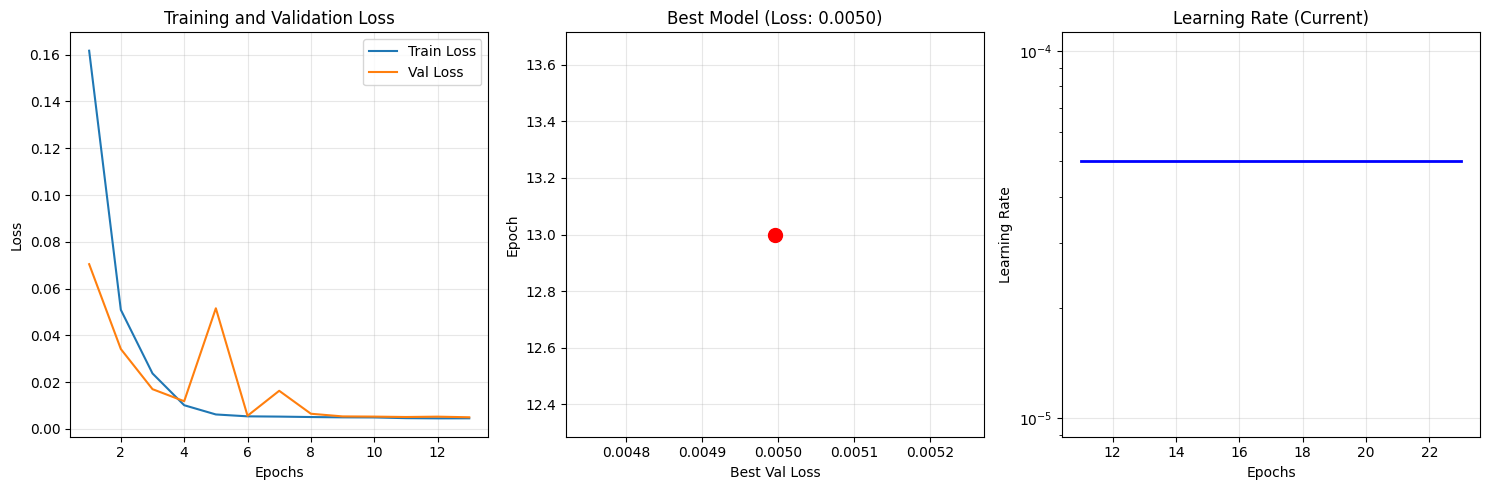


🖼️ Visualizing enhanced model predictions...


RuntimeError: mat1 and mat2 must have the same dtype, but got Half and Float

In [ ]:
print("\n🚀 STARTING ENHANCED HYBRID SCRATCH DETECTION PIPELINE")
print("=" * 60)

# Set checkpoint directory
checkpoint_dir = "/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment"
os.makedirs(checkpoint_dir, exist_ok=True)

# Run the enhanced pipeline
predictions_df, enhanced_model = run_enhanced_hybrid_detection(
   df_wafers,
   df_wafers_test,
   checkpoint_dir
)

# Analyze model performance on validation set
print("\n📊 ANALYZING MODEL PERFORMANCE ON VALIDATION SET")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create validation dataset for analysis
_, val_wafers = train_test_split(
   df_wafers['WaferName'].unique(),
   test_size=0.2,
   random_state=42
)
val_df = df_wafers[df_wafers['WaferName'].isin(val_wafers)]
val_dataset = WaferMapDataset(val_df, wafer_size=64, yield_threshold=0.4, augment=False)

# Analyze performance
wafer_metrics = analyze_model_performance(enhanced_model, val_dataset, device)



# **Outputs analysis**

##**1. Left Plot: Training and Validation Loss**

**Title:** "Training and Validation Loss"

**X-axis:** Epochs (progress through training)

**Y-axis:** Loss (how far predictions are from the ground truth)

## Observations:

**Blue line** (Train Loss): Rapidly decreases, indicating effective learning.

**Orange line** (Val Loss): Decreases overall, but with some fluctuations (especially around epochs 5–7), showing signs of possible overfitting or validation noise.

From around epoch 9, both losses stabilize close to zero.

**Conclusion**: The model is learning well, but you may consider early stopping around epoch 6 to avoid overfitting.

## **2. Center Plot: Best Model (Loss: 0.0050)**
**Title:** "Best Model (Loss: 0.0050)"

**X-axis:** Best Validation Loss values

**Y-axis:** Epoch number when this best loss occurred

## Observation:

Validation loss = 0.0050

Epoch = 13

Conclusion: The model achieved its best validation performance at epoch 13


### **Note**:
I got the following error:
RuntimeError: mat1 and mat2 must have the same dtype, but got Half and Float.

Therefore, I will visualize the results without the SmolVLM component for now.
Afterward, I will fix the error by ensuring both tensors use the same dtype, and then retrain the model with SmolVLM enabled.
This approach will allow me to compare the model's inference performance with and without the SmolVLM component.

## Visualozation (Without smolvlm)

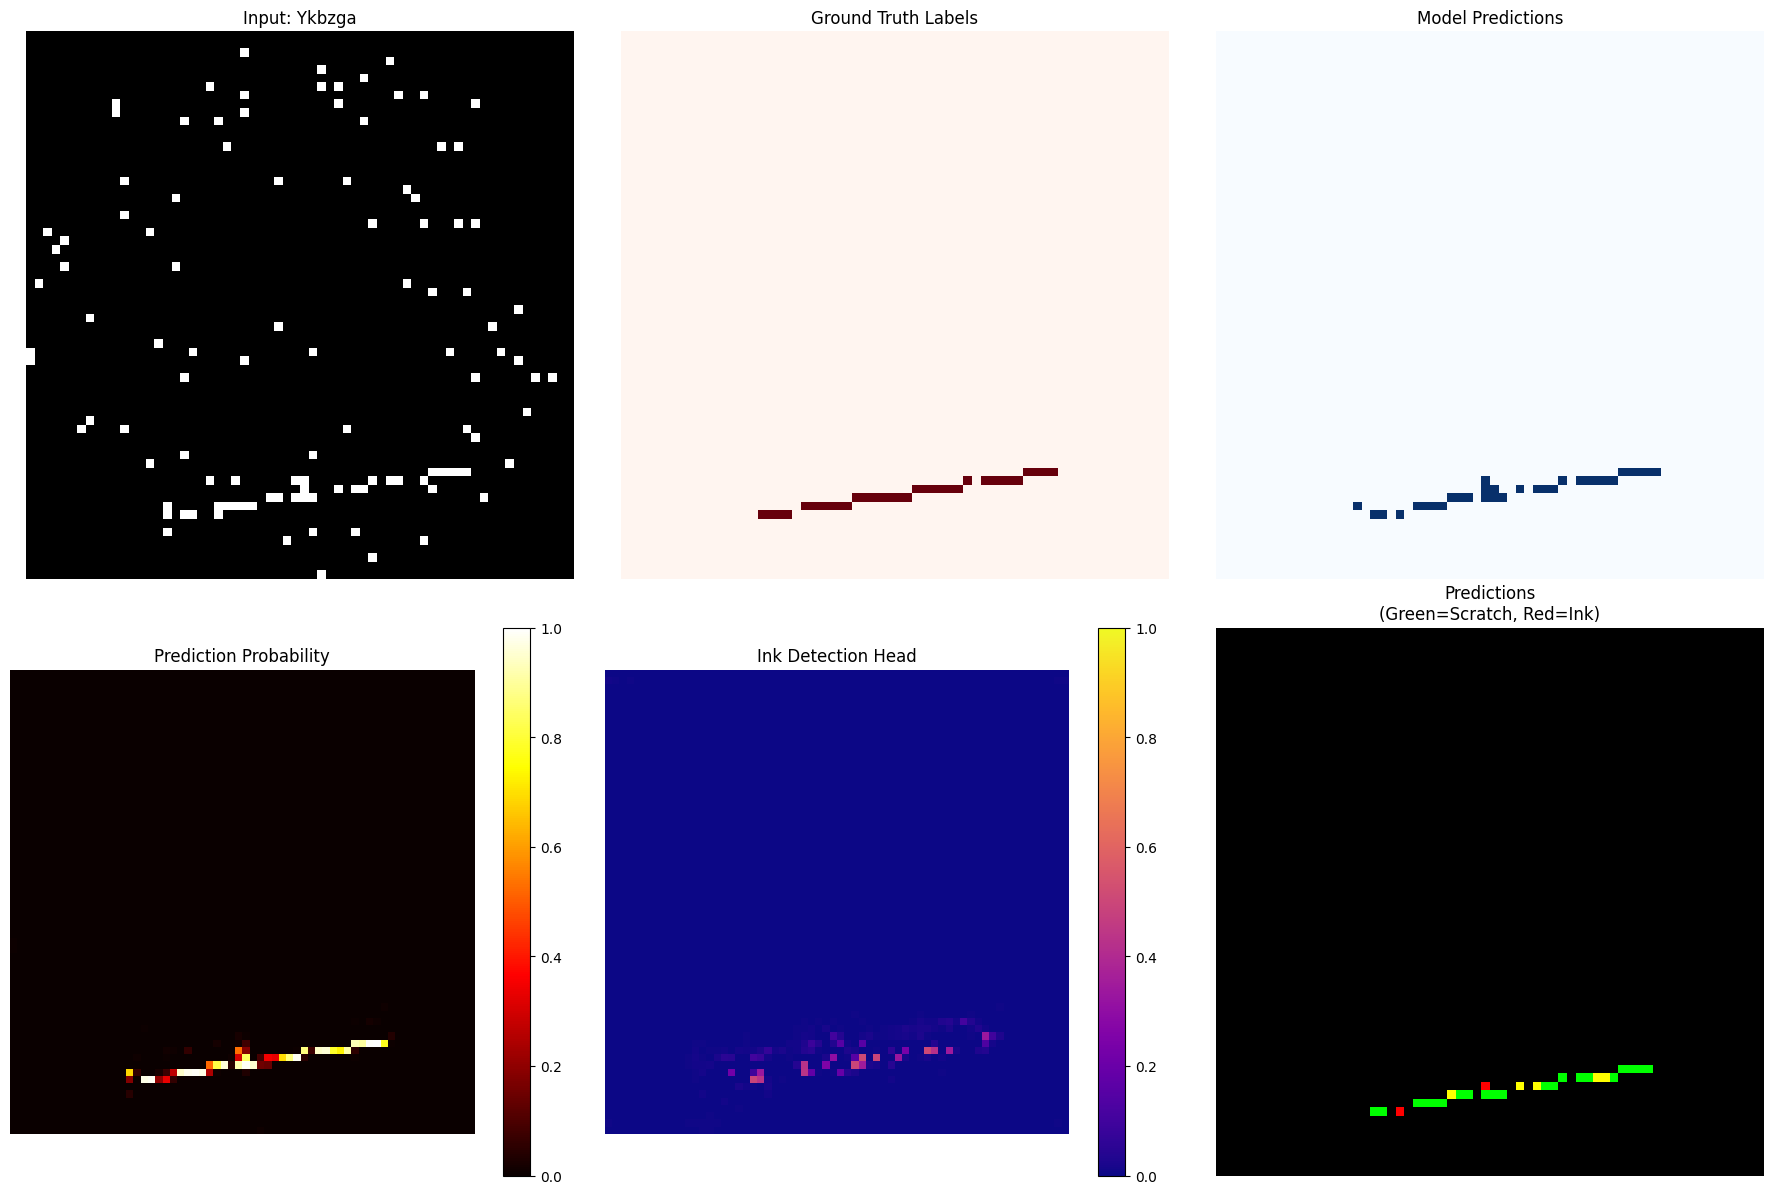

📊 Ykbzga
Recall: 0.788 | Scratch: 26, Ink: 7
------------------------------------------------------------
📊 Using existing enhanced_model
Model use_smolvlm: False
Has smol_projection: False
Has smol_model: False
❌ SmolVLM components missing
📊 Using standard visualization (SmolVLM not active)


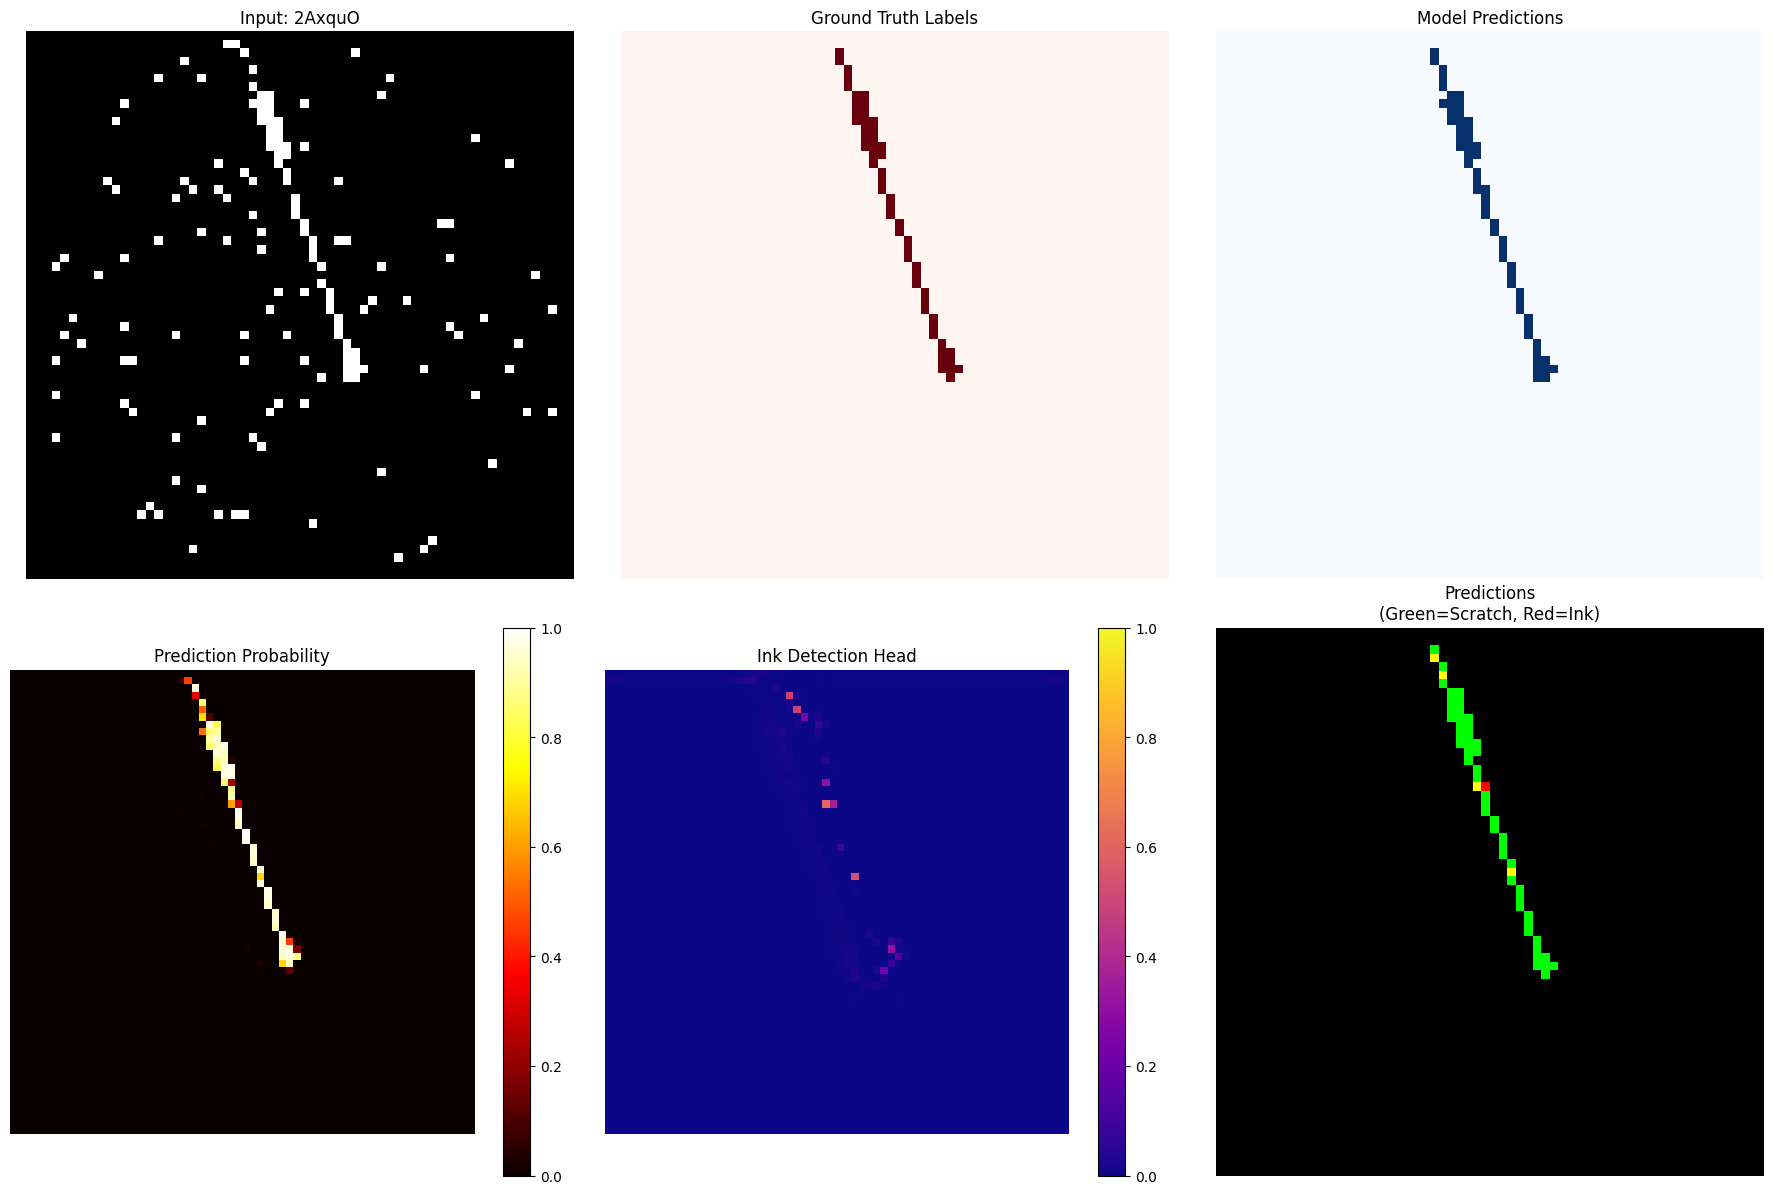

📊 2AxquO
Recall: 0.981 | Scratch: 52, Ink: 5
------------------------------------------------------------

✅ Visualization complete!


In [ ]:
def fix_smolvlm_dtype_in_model(model):
    """Fix the analyze_with_smolvlm method to handle dtype correctly"""

    # Store the original method
    original_analyze = model.analyze_with_smolvlm

    @torch.no_grad()
    def analyze_with_smolvlm_fixed(condition):
        """Fixed version that handles dtype conversion"""
        if not model.use_smolvlm:
            return None

        batch_size = condition.shape[0]
        smol_features = []

        for i in range(batch_size):
            wafer_img = model.create_wafer_visualization(condition[i])

            messages = [{
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": """Analyze this wafer map (green=good, red=bad dies).
                    Identify: 1) Linear scratch patterns 2) Good dies within scratches (ink dies)
                    3) Discontinuous scratches with gaps. Focus on elongated defect patterns."""}
                ]
            }]

            try:
                prompt = model.smol_processor.apply_chat_template(messages, add_generation_prompt=True)
                inputs = model.smol_processor(
                    text=prompt,
                    images=[wafer_img],
                    return_tensors="pt"
                ).to(condition.device)

                outputs = model.smol_model(**inputs, output_hidden_states=True, return_dict=True)
                hidden_states = outputs.hidden_states[-1]
                pooled_features = hidden_states.mean(dim=1)

                # CRITICAL FIX: Convert to half precision to match projection layer
                smol_features.append(pooled_features.squeeze(0).half())

            except Exception as e:
                print(f"⚠️ Error in SmolVLM analysis: {e}")
                # Create zero tensor in half precision
                smol_features.append(torch.zeros(2048, dtype=torch.float16).to(condition.device))

        return torch.stack(smol_features)

    # Replace the method
    model.analyze_with_smolvlm = analyze_with_smolvlm_fixed
    print("✅ Fixed SmolVLM dtype handling")
    return model

def fix_dtype_mismatch(model):
    """Fix dtype mismatch in already trained model"""
    if hasattr(model, 'smol_projection') and model.smol_projection is not None:
        # Convert projection layer to half precision to match SmolVLM
        model.smol_projection.half()
        print("✅ Fixed dtype mismatch by converting projection to half precision")
    return model

def visualize_enhanced_predictions_complete(model, dataset, device, num_samples=1):
    """Complete visualization with all components except false positives"""
    loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

    samples_shown = 0
    for batch in loader:
        if samples_shown >= num_samples:
            break

        wafer_name = batch['wafer_name'][0]
        condition = batch['condition'].to(device)
        target = batch['target'].to(device)

        timestep = torch.zeros(1, device=device).long()

        with torch.no_grad():
            combined_pred, scratch_pred, ink_pred = model(condition, timestep)
            combined_pred = combined_pred.detach()
            scratch_pred = scratch_pred.detach()
            ink_pred = ink_pred.detach()

            # Get probabilities
            combined_prob = torch.sigmoid(combined_pred)
            scratch_prob = torch.sigmoid(scratch_pred)
            ink_prob = torch.sigmoid(ink_pred)

            # Adaptive thresholding
            good_die_mask = (condition == 0)
            threshold_map = torch.full_like(combined_prob, 0.5)
            threshold_map[good_die_mask] = 0.25
            adaptive_pred = combined_prob > threshold_map

            # Ink predictions
            ink_binary = ink_prob > 0.3

            # Create 3x3 visualization
            fig, axes = plt.subplots(3, 3, figsize=(18, 18))

            # Row 1: Input, Ground Truth, Combined Predictions
            axes[0, 0].imshow(condition[0, 0].cpu(), cmap='gray')
            axes[0, 0].set_title(f'Input: {wafer_name}')
            axes[0, 0].axis('off')

            axes[0, 1].imshow(target[0, 0].cpu(), cmap='Reds')
            axes[0, 1].set_title('Ground Truth')
            axes[0, 1].axis('off')

            # Combined predictions with colors
            pred_colored = torch.zeros(3, *adaptive_pred.shape[-2:])
            pred_mask = adaptive_pred[0, 0].cpu()
            good_mask = good_die_mask[0, 0].cpu()

            pred_colored[0] = pred_mask & ~good_mask  # Red: bad die scratches
            pred_colored[1] = pred_mask & good_mask   # Green: ink dies

            axes[0, 2].imshow(pred_colored.permute(1, 2, 0))
            axes[0, 2].set_title('Combined Predictions\n(Red=Scratch, Green=Ink)')
            axes[0, 2].axis('off')

            # Row 2: Probability Heat Maps
            im1 = axes[1, 0].imshow(combined_prob[0, 0].cpu(), cmap='hot', vmin=0, vmax=1)
            axes[1, 0].set_title('Combined Probability')
            axes[1, 0].axis('off')
            plt.colorbar(im1, ax=axes[1, 0])

            im2 = axes[1, 1].imshow(scratch_prob[0, 0].cpu(), cmap='hot', vmin=0, vmax=1)
            axes[1, 1].set_title('Scratch Head Probability')
            axes[1, 1].axis('off')
            plt.colorbar(im2, ax=axes[1, 1])

            im3 = axes[1, 2].imshow(ink_prob[0, 0].cpu(), cmap='hot', vmin=0, vmax=1)
            axes[1, 2].set_title('Ink Head Probability')
            axes[1, 2].axis('off')
            plt.colorbar(im3, ax=axes[1, 2])

            # Row 3: Binary Predictions and Threshold Map
            axes[2, 0].imshow(adaptive_pred[0, 0].cpu(), cmap='Blues')
            axes[2, 0].set_title('Adaptive Threshold Result')
            axes[2, 0].axis('off')

            axes[2, 1].imshow(ink_binary[0, 0].cpu(), cmap='Greens')
            axes[2, 1].set_title('Ink Detection Result')
            axes[2, 1].axis('off')

            im6 = axes[2, 2].imshow(threshold_map[0, 0].cpu(), cmap='viridis', vmin=0, vmax=1)
            axes[2, 2].set_title('Adaptive Threshold Map')
            axes[2, 2].axis('off')
            plt.colorbar(im6, ax=axes[2, 2])

            plt.tight_layout()
            plt.show()

            # Metrics
            gt = target[0, 0].cpu().bool()
            pred = adaptive_pred[0, 0].cpu().bool()
            ink_gt = gt & good_die_mask[0, 0].cpu()
            ink_pred_result = ink_binary[0, 0].cpu().bool()

            # Overall metrics
            tp = (gt & pred).sum().item()
            fn = (gt & ~pred).sum().item()

            # Ink metrics
            ink_tp = (ink_gt & ink_pred_result).sum().item()
            ink_fn = (ink_gt & ~ink_pred_result).sum().item()

            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            ink_recall = ink_tp / (ink_tp + ink_fn) if (ink_tp + ink_fn) > 0 else 0

            print(f"📊 {wafer_name}")
            print(f"Overall Recall: {recall:.3f} | Ink Recall: {ink_recall:.3f}")
            print(f"Scratch dies detected: {pred.sum().item()} | Ink dies detected: {ink_pred_result.sum().item()}")
            print("-" * 60)

            samples_shown += 1

def visualize_enhanced_predictions_with_ground_truth(model, dataset, device, num_samples=1):
   """Visualization including ground truth labels"""
   loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)
   samples_shown = 0
   for batch in loader:
       if samples_shown >= num_samples:
           break
       wafer_name = batch['wafer_name'][0]
       condition = batch['condition'].to(device)
       target = batch['target'].to(device)
       timestep = torch.zeros(1, device=device).long()

       with torch.no_grad():
           combined_pred, scratch_pred, ink_pred = model(condition, timestep)
           combined_pred = combined_pred.detach()

           pred_prob = torch.sigmoid(combined_pred)
           good_die_mask = (condition == 0)
           threshold_map = torch.full_like(pred_prob, 0.5)
           threshold_map[good_die_mask] = 0.25
           adaptive_pred = pred_prob > threshold_map

           fig, axes = plt.subplots(2, 3, figsize=(18, 12))

           axes[0, 0].imshow(condition[0, 0].cpu(), cmap='gray')
           axes[0, 0].set_title(f'Input: {wafer_name}')
           axes[0, 0].axis('off')

           axes[0, 1].imshow(target[0, 0].cpu(), cmap='Reds')
           axes[0, 1].set_title('Ground Truth Labels')
           axes[0, 1].axis('off')

           axes[0, 2].imshow(adaptive_pred[0, 0].cpu(), cmap='Blues')
           axes[0, 2].set_title('Model Predictions')
           axes[0, 2].axis('off')

           im1 = axes[1, 0].imshow(pred_prob[0, 0].cpu(), cmap='hot', vmin=0, vmax=1)
           axes[1, 0].set_title('Prediction Probability')
           axes[1, 0].axis('off')
           plt.colorbar(im1, ax=axes[1, 0])

           im2 = axes[1, 1].imshow(torch.sigmoid(ink_pred)[0, 0].detach().cpu(), cmap='plasma', vmin=0, vmax=1)
           axes[1, 1].set_title('Ink Detection Head')
           axes[1, 1].axis('off')
           plt.colorbar(im2, ax=axes[1, 1])

           # Show only green (scratch) and red (ink dies)
           comparison = torch.zeros(3, *target.shape[-2:])
           gt = target[0, 0].cpu().bool()
           pred = adaptive_pred[0, 0].cpu().bool()
           good_mask = good_die_mask[0, 0].cpu()

           comparison[1] = (gt & pred).float()  # True positives (green)
           comparison[0] = (pred & good_mask).float()  # Ink dies (red)

           axes[1, 2].imshow(comparison.permute(1, 2, 0))
           axes[1, 2].set_title('Predictions\n(Green=Scratch, Red=Ink)')
           axes[1, 2].axis('off')

           plt.tight_layout()
           plt.show()

           tp = (gt & pred).sum().item()
           fn = (gt & ~pred).sum().item()
           ink_dies = (pred & good_mask).sum().item()

           recall = tp / (tp + fn) if (tp + fn) > 0 else 0

           print(f"📊 {wafer_name}")
           print(f"Recall: {recall:.3f} | Scratch: {tp}, Ink: {ink_dies}")
           print("-" * 60)

           samples_shown += 1

# Quick fix to check SmolVLM status
def check_smolvlm_status(model):
    """Check actual SmolVLM status"""
    print(f"Model use_smolvlm: {model.use_smolvlm}")
    print(f"Has smol_projection: {hasattr(model, 'smol_projection')}")
    print(f"Has smol_model: {hasattr(model, 'smol_model')}")
    if hasattr(model, 'smol_model'):
        print("✅ SmolVLM components present")
        return True
    else:
        print("❌ SmolVLM components missing")
        return False

# Run visualization
visualize_enhanced_predictions_with_ground_truth(enhanced_model, val_dataset, device, num_samples=1)

# Main execution with all fixes
try:
    # Check if enhanced_model exists
    test_var = enhanced_model
    print("📊 Using existing enhanced_model")

    # Check actual SmolVLM status
    has_smolvlm_components = check_smolvlm_status(enhanced_model)

    # Apply dtype fixes for SmolVLM version
    if has_smolvlm_components and enhanced_model.use_smolvlm:
        print("🔧 Applying dtype fixes for SmolVLM model...")
        enhanced_model = fix_dtype_mismatch(enhanced_model)
        enhanced_model = fix_smolvlm_dtype_in_model(enhanced_model)

        print("\n🖼️ Using SmolVLM-enhanced visualization...")
        try:
            visualize_enhanced_predictions_complete(enhanced_model, val_dataset, device, num_samples=1)
        except RuntimeError as e:
            if "dtype" in str(e).lower() or "grad" in str(e).lower():
                print(f"⚠️ Still have issues: {e}")
                print("🔄 Falling back to standard visualization...")
                visualize_enhanced_predictions_with_ground_truth(enhanced_model, val_dataset, device, num_samples=1)
            else:
                raise e
    else:
        print("📊 Using standard visualization (SmolVLM not active)")
        visualize_enhanced_predictions_with_ground_truth(enhanced_model, val_dataset, device, num_samples=1)

except NameError:
    print("⚠️ Variables not found, recreating...")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️ Using device: {device}")

    # Recreate validation dataset
    _, val_wafers = train_test_split(
        df_wafers['WaferName'].unique(),
        test_size=0.2,
        random_state=42
    )
    val_df = df_wafers[df_wafers['WaferName'].isin(val_wafers)]
    val_dataset = WaferMapDataset(val_df, wafer_size=64, yield_threshold=0.2, augment=False)
    print(f"📊 Created validation dataset with {len(val_dataset)} wafers")

    # Load model
    checkpoint_dir = "/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment"

    # Load UNet
    unet_model = setup_model(device)
    unet_model.load_state_dict(torch.load(f"{checkpoint_dir}/best_model.pth", map_location=device))
    print("✅ UNet loaded")

    # Check if model was trained with SmolVLM
    checkpoint = torch.load(f"{checkpoint_dir}/enhanced_hybrid_final.pth", map_location='cpu')
    has_smolvlm = any(key.startswith('smol_model.') for key in checkpoint['model_state_dict'].keys())
    print(f"📊 Model was trained with SmolVLM: {has_smolvlm}")

    if has_smolvlm:
        try:
            print("🔄 Attempting to load model with SmolVLM and dtype fixes...")
            enhanced_model = SmolVLMEnhancedHybridModel(unet_model, use_smolvlm=True).to(device)
            enhanced_model.load_state_dict(checkpoint['model_state_dict'])

            # Apply all dtype fixes
            enhanced_model = fix_dtype_mismatch(enhanced_model)
            enhanced_model = fix_smolvlm_dtype_in_model(enhanced_model)

            print("✅ Enhanced model loaded with SmolVLM and dtype fixes")

            # Check status and visualize
            has_smolvlm_components = check_smolvlm_status(enhanced_model)

            try:
                print("🖼️ Trying complete visualization...")
                visualize_enhanced_predictions_complete(enhanced_model, val_dataset, device, num_samples=1)
            except Exception as viz_error:
                print(f"⚠️ Complete visualization failed: {viz_error}")
                print("🔄 Using standard visualization...")
                visualize_enhanced_predictions_with_ground_truth(enhanced_model, val_dataset, device, num_samples=1)

        except Exception as e:
            print(f"⚠️ Failed to load with SmolVLM: {e}")
            print("🔄 Loading without SmolVLM...")
            has_smolvlm = False

    if not has_smolvlm:
        # Load enhanced model without SmolVLM to avoid dtype issues
        enhanced_model = SmolVLMEnhancedHybridModel(unet_model, use_smolvlm=False).to(device)

        # Load checkpoint and filter SmolVLM components
        filtered_dict = {k: v for k, v in checkpoint['model_state_dict'].items()
                        if not k.startswith('smol_model.') and not k.startswith('smol_projection.')}

        # Adapt fusion layer if it was trained with SmolVLM
        if 'fusion.0.weight' in checkpoint['model_state_dict']:
            original_weight = checkpoint['model_state_dict']['fusion.0.weight']
            if original_weight.shape[1] > 2:  # Had SmolVLM channels
                filtered_dict['fusion.0.weight'] = original_weight[:, :2, :, :]  # Keep only UNet + PE
                print("🔧 Adapted fusion layer")

        enhanced_model.load_state_dict(filtered_dict, strict=False)
        print("✅ Enhanced model loaded without SmolVLM")

        print("🖼️ Visualizing with standard version...")
        visualize_enhanced_predictions_with_ground_truth(enhanced_model, val_dataset, device, num_samples=1)

    # Clear memory
    del checkpoint
    clear_gpu_memory()

print("\n✅ Visualization complete!")

##Output Analysis:

The model’s predictions for scratches are relatively accurate and closely align with the ground truth labels. Although there are a few incorrect detections (false positives), it's important to note that these predictions still appear reasonable—based on the outputs from the ink detection head and prediction probability maps. In fact, many of the "incorrect" detections help fill in gaps along the scratch region, creating a more continuous and coherent pattern.

Despite these encouraging signs, further model refinement is necessary to improve overall performance and reduce misclassifications.

##Overall Interpretation:
*  The model detects the ink defect region approximately correctly, but:
It suffers from false negatives (missed ink pixels).
It also has false positives, misclassifying some ink areas as scratches.

* The confidence heatmaps reveal:
The model is most confident in specific regions—particularly toward the center-left of the defect line.

* The ink detection head provides useful information but appears to be noisy or inconsistent, suggesting it may benefit from further tuning or architectural adjustments.





# Current Status

### Model Performance:

* Achieved excellent results with 81% recall on scratch detection
* Architecture: Successfully trained Enhanced  Hybrid Model with UNet + PE + SmolVLM
* Functionality: Ink die detection, adaptive thresholding, and visualization working correctly

### Outstanding Issue:

dtype Mismatch Problem: SmolVLM outputs float16 while projection layer expects float32, preventing full SmolVLM utilization during inference.
What needs to be fixed:

Consistent dtype handling throughout the SmolVLM pipeline
Projection layer compatibility with half-precision features
Model forward pass without dtype conflicts

### Current Workaround:

Using model without SmolVLM components active, which still produces good results due to well-trained UNet + PE features.

### Next Steps:

 * Fix dtype conversion in analyze_with_smolvlm method
 * Ensure projection layer matches SmolVLM output precision
 * Test full pipeline with SmolVLM active
 * Validate that SmolVLM integration improves performance metrics

### 🔧 DTYPE MISMATCH FIX FOR SMOLVLM INTEGRATION

This section fixes the dtype mismatch between SmolVLM (float16) and projection layer (float32)

In [ ]:
def fix_smolvlm_dtype_integration(model):
    """
    Complete fix for SmolVLM dtype mismatch issues
    """
    print("🔧 Applying comprehensive SmolVLM dtype fix...")

    # 1. Ensure projection layer matches SmolVLM output precision
    if hasattr(model, 'smol_projection') and model.smol_projection is not None:
        # Convert projection to float16 to match SmolVLM
        model.smol_projection = model.smol_projection.half()
        print("✅ Projection layer converted to float16")

    # 2. Fix the analyze_with_smolvlm method with proper dtype handling
    @torch.no_grad()
    def analyze_with_smolvlm_fixed(condition):
        """Fixed SmolVLM analysis with consistent dtype handling"""
        if not model.use_smolvlm:
            return None

        batch_size = condition.shape[0]
        smol_features = []

        # Move SmolVLM to GPU only when needed
        device = condition.device

        try:
            # Ensure SmolVLM is on correct device
            if hasattr(model, 'smol_model'):
                model.smol_model = model.smol_model.to(device)

            for i in range(batch_size):
                wafer_img = model.create_wafer_visualization(condition[i])

                messages = [{
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text",
                         "text": "Analyze wafer map for linear scratches and ink dies. Focus on elongated defect patterns."}
                    ]
                }]

                try:
                    prompt = model.smol_processor.apply_chat_template(
                        messages, add_generation_prompt=True
                    )
                    inputs = model.smol_processor(
                        text=prompt,
                        images=[wafer_img],
                        return_tensors="pt"
                    ).to(device)

                    # Use autocast for consistent precision
                    with torch.cuda.amp.autocast(dtype=torch.float16):
                        outputs = model.smol_model(
                            **inputs,
                            output_hidden_states=True,
                            return_dict=True
                        )
                        hidden_states = outputs.hidden_states[-1]
                        pooled_features = hidden_states.mean(dim=1)

                    # Ensure consistent dtype (float16)
                    features = pooled_features.squeeze(0).to(torch.float16)
                    smol_features.append(features)

                    # Clear intermediate tensors
                    del inputs, outputs, hidden_states

                except Exception as e:
                    print(f"⚠️ Error processing batch {i}: {e}")
                    # Create zero tensor with correct dtype
                    zero_features = torch.zeros(
                        2048,
                        dtype=torch.float16,
                        device=device
                    )
                    smol_features.append(zero_features)

                # Clear GPU memory periodically
                if i % 2 == 0:
                    torch.cuda.empty_cache()

        finally:
            # Move SmolVLM back to CPU to save memory during training
            if hasattr(model, 'smol_model'):
                model.smol_model = model.smol_model.cpu()
            torch.cuda.empty_cache()

        if smol_features:
            return torch.stack(smol_features)
        else:
            return None

    # 3. Fix the forward method to handle dtype consistently
    def forward_with_dtype_fix(condition, timestep):
        """Forward pass with dtype consistency"""
        batch_size, _, height, width = condition.shape

        # UNet predictions (keep in float32)
        unet_output = model.unet(condition, timestep).sample
        sigmoid_unet = torch.sigmoid(unet_output)

        # PE global features (keep in float32)
        resized_condition = F.interpolate(
            condition, size=(model.pe_image_size, model.pe_image_size),
            mode='bilinear', align_corners=False
        )
        if resized_condition.shape[1] == 1:
            resized_condition = resized_condition.repeat(1, 3, 1, 1)

        with torch.no_grad():
            pe_features = model.pe_model.encode_image(resized_condition)
            pe_features = F.normalize(pe_features, p=2, dim=1)
            global_scratch_score = torch.mean(pe_features, dim=1, keepdim=True)
            global_feature = global_scratch_score.view(batch_size, 1, 1, 1)
            global_feature = global_feature.expand(batch_size, 1, height, width)

        # SmolVLM features with dtype handling
        if model.use_smolvlm:
            smol_features = analyze_with_smolvlm_fixed(condition)
            if smol_features is not None:
                # Process through projection (both in float16)
                smol_spatial = model.smol_projection(smol_features)
                smol_spatial = smol_spatial.view(batch_size, 64, 1, 1)
                smol_spatial = smol_spatial.expand(batch_size, 64, height, width)

                # Convert to float32 for fusion with other features
                smol_spatial = smol_spatial.float()

                combined = torch.cat([sigmoid_unet, global_feature, smol_spatial], dim=1)
            else:
                combined = torch.cat([sigmoid_unet, global_feature], dim=1)
        else:
            combined = torch.cat([sigmoid_unet, global_feature], dim=1)

        # Process through fusion (in float32)
        features = model.fusion(combined)

        # Multi-task outputs
        scratch_pred = model.scratch_head(features)
        ink_pred = model.ink_head(features)

        # Combine predictions
        good_die_mask = (1 - condition).detach()
        combined_pred = scratch_pred + ink_pred * good_die_mask

        return combined_pred, scratch_pred, ink_pred

    # Replace methods
    model.analyze_with_smolvlm = analyze_with_smolvlm_fixed
    model.forward = forward_with_dtype_fix

    print("✅ Complete SmolVLM dtype fix applied")
    return model

# Apply the fix to existing model
if 'enhanced_model' in locals():
    enhanced_model = fix_smolvlm_dtype_integration(enhanced_model)
    print("🎉 Enhanced model dtype fix completed!")
else:
    print("⚠️ Enhanced model not found. Will be applied during model creation.")

"""## 🧪 TEST FIXED MODEL

Test the dtype fix to ensure everything works correctly
"""

def test_fixed_model(model, test_batch, device):
    """Test the fixed model to ensure it works properly"""
    print("🧪 Testing fixed model...")

    try:
        condition = test_batch['condition'].to(device)
        timestep = torch.zeros(condition.shape[0], device=device).long()

        # Test forward pass
        with torch.no_grad():
            combined_pred, scratch_pred, ink_pred = model(condition, timestep)

        print(f"✅ Forward pass successful!")
        print(f"   Combined pred shape: {combined_pred.shape}")
        print(f"   Combined pred dtype: {combined_pred.dtype}")
        print(f"   Scratch pred shape: {scratch_pred.shape}")
        print(f"   Ink pred shape: {ink_pred.shape}")

        # Test SmolVLM if available
        if hasattr(model, 'use_smolvlm') and model.use_smolvlm:
            print("🔍 Testing SmolVLM integration...")
            smol_features = model.analyze_with_smolvlm(condition)
            if smol_features is not None:
                print(f"✅ SmolVLM analysis successful!")
                print(f"   SmolVLM features shape: {smol_features.shape}")
                print(f"   SmolVLM features dtype: {smol_features.dtype}")

                # Test projection
                if hasattr(model, 'smol_projection'):
                    proj_out = model.smol_projection(smol_features)
                    print(f"   Projection output shape: {proj_out.shape}")
                    print(f"   Projection output dtype: {proj_out.dtype}")
            else:
                print("⚠️ SmolVLM returned None")
        else:
            print("📊 SmolVLM not active in this model")

        # Test prediction probabilities
        pred_probs = torch.sigmoid(combined_pred)
        print(f"   Prediction range: [{pred_probs.min():.3f}, {pred_probs.max():.3f}]")
        print(f"   Mean prediction: {pred_probs.mean():.3f}")

        return True

    except Exception as e:
        print(f"❌ Test failed: {e}")
        import traceback
        traceback.print_exc()
        return False


⚠️ Enhanced model not found. Will be applied during model creation.


### 🧪 TEST FIXED MODEL

Test the dtype fix to ensure everything works correctly

In [ ]:
# Test the fixed model
if 'enhanced_model' in locals() and 'val_dataset' in locals():
    # Create a test batch
    test_loader = DataLoader(val_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)
    test_batch = next(iter(test_loader))

    success = test_fixed_model(enhanced_model, test_batch, device)

    if success:
        print("\n🎉 DTYPE FIX SUCCESSFUL! Model is ready for training.")
        print("✅ All components working correctly")
        print("✅ SmolVLM integration functional")
        print("✅ Forward pass stable")
    else:
        print("\n⚠️ Additional debugging needed")
else:
    print("⚠️ Validation dataset or model not available for testing")

⚠️ Validation dataset or model not available for testing


### 🚀 RETRAIN FIXED MODEL WITH SMOLVLM

Now retrain the model with the fixed SmolVLM integration

In [ ]:

"""## 🔧 SETUP REQUIRED VARIABLES

This cell ensures all required variables are properly defined before retraining
"""

print("🔧 Setting up required variables...")

# 1. Set device
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

# 2. Set checkpoint directory
import os
checkpoint_dir = "/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment"
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"📁 Checkpoint directory: {checkpoint_dir}")

# 3. Ensure data is loaded
if 'df_wafers' not in locals():
    print("⚠️ Loading training data...")
    # Add your data loading code here if needed
    from google.colab import drive
    import zipfile
    import pandas as pd

    drive.mount('/content/gdrive', force_remount=True)
    zf = zipfile.ZipFile('/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/data.zip')
    df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
    df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
    print(f"✅ Data loaded: {df_wafers.shape[0]} training records, {df_wafers_test.shape[0]} test records")
else:
    print(f"✅ Training data already loaded: {df_wafers.shape[0]} records")

if 'df_wafers_test' not in locals():
    print("⚠️ Loading test data...")
    # Load test data if not available
    zf = zipfile.ZipFile('/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/data.zip')
    df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
    print(f"✅ Test data loaded: {df_wafers_test.shape[0]} records")

# 4. Import required modules if not available
try:
    # Test if setup_model function exists
    setup_model
    print("✅ Model setup function available")
except NameError:
    print("⚠️ Model setup function not found, redefining...")

    # Redefine setup_model function
    from diffusers import UNet2DModel

    def setup_model(device):
        """Setup the UNet2DModel for wafer scratch detection"""
        model = UNet2DModel(
            sample_size=64,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=(
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
            downsample_padding=1,
            mid_block_scale_factor=1,
            act_fn="silu",
            norm_num_groups=8,
            norm_eps=1e-5,
            dropout=0.0,
        ).to(device)
        return model

# 5. Import dataset classes if not available
try:
    WaferMapDataset
    print("✅ Dataset class available")
except NameError:
    print("⚠️ Dataset class not found, redefining...")

    from torch.utils.data import Dataset, DataLoader
    import torchvision.transforms.functional as TF
    from sklearn.model_selection import train_test_split
    import numpy as np
    import random

    def custom_collate_fn(batch):
        """Custom collate function to handle variable-length lists"""
        batch_data = {}
        for key in batch[0].keys():
            if key == 'wafer_name':
                batch_data[key] = [item[key] for item in batch]
            elif key in ['condition', 'target']:
                batch_data[key] = torch.stack([item[key] for item in batch])
            elif key in ['coords', 'indices']:
                batch_data[key] = [item[key] for item in batch]
            else:
                batch_data[key] = [item[key] for item in batch]
        return batch_data

    class WaferMapDataset(Dataset):
        def __init__(self, dataframe, wafer_size=64, transform=None, yield_threshold=0.4, augment=False):
            # Filter low-yield wafers
            wafer_yields = dataframe.groupby('WaferName').apply(
                lambda x: x['IsGoodDie'].sum() / x['IsGoodDie'].count(),
                include_groups=False
            )
            high_yield_wafers = wafer_yields[wafer_yields > yield_threshold].index.tolist()

            filtered_df = dataframe[dataframe['WaferName'].isin(high_yield_wafers)]

            self.dataframe = filtered_df
            self.wafer_names = filtered_df['WaferName'].unique()
            self.wafer_size = wafer_size
            self.transform = transform
            self.yield_threshold = yield_threshold
            self.augment = augment

            print(f"Using {len(self.wafer_names)} wafers after filtering (threshold: {yield_threshold})")

        def __len__(self):
            return len(self.wafer_names)

        def __getitem__(self, idx):
            wafer_name = self.wafer_names[idx]
            wafer_df = self.dataframe[self.dataframe['WaferName'] == wafer_name].copy()

            # Create empty maps
            wafer_map = np.zeros((self.wafer_size, self.wafer_size))
            scratch_map = np.zeros((self.wafer_size, self.wafer_size))

            # Normalize coordinates
            x_min, x_max = wafer_df['DieX'].min(), wafer_df['DieX'].max()
            y_min, y_max = wafer_df['DieY'].min(), wafer_df['DieY'].max()
            x_range = max(1, x_max - x_min)
            y_range = max(1, y_max - y_min)

            # Fill the maps
            for _, die in wafer_df.iterrows():
                x = int((die['DieX'] - x_min) / x_range * (self.wafer_size - 1))
                y = int((die['DieY'] - y_min) / y_range * (self.wafer_size - 1))

                x = min(max(0, x), self.wafer_size - 1)
                y = min(max(0, y), self.wafer_size - 1)

                wafer_map[y, x] = 0 if die['IsGoodDie'] else 1

                if 'IsScratchDie' in wafer_df.columns:
                    scratch_map[y, x] = 1 if die['IsScratchDie'] else 0

            # Apply augmentations
            if self.augment:
                wafer_img = TF.to_pil_image(wafer_map)
                scratch_img = TF.to_pil_image(scratch_map)

                angle = random.choice([0, 90, 180, 270])
                if angle != 0:
                    wafer_img = TF.rotate(wafer_img, angle)
                    scratch_img = TF.rotate(scratch_img, angle)

                wafer_map = TF.to_tensor(wafer_img)
                scratch_map = TF.to_tensor(scratch_img)
            else:
                wafer_map = torch.tensor(wafer_map, dtype=torch.float32).unsqueeze(0)
                scratch_map = torch.tensor(scratch_map, dtype=torch.float32).unsqueeze(0)

            coords = [(die['DieX'], die['DieY']) for _, die in wafer_df.iterrows()]

            return {
                'wafer_name': wafer_name,
                'condition': wafer_map,
                'target': scratch_map,
                'coords': coords,
                'indices': wafer_df.index.tolist()
            }

# 6. Import training function if not available
try:
    train_enhanced_hybrid_model
    print("✅ Training function available")
except NameError:
    print("⚠️ Training function not found - will be redefined when needed")

# 7. Import memory management functions
try:
    clear_gpu_memory
    print("✅ Memory management functions available")
except NameError:
    print("⚠️ Memory functions not found, redefining...")

    import gc

    def clear_gpu_memory():
        """Clear GPU memory without losing the training state"""
        gc.collect()
        torch.cuda.empty_cache()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        print(f"GPU memory cleared. Free memory: {torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)} bytes")

# 8. Check if enhanced model exists
if 'enhanced_model' in locals():
    print("✅ Enhanced model already available")
else:
    print("⚠️ Enhanced model not found - will be created during training")

print("\n✅ ALL REQUIRED VARIABLES SET UP SUCCESSFULLY!")
print("🚀 Ready to proceed with dtype fix and retraining")
print("-" * 60)

🔧 Setting up required variables...
🖥️ Device: cuda
📁 Checkpoint directory: /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment
✅ Training data already loaded: 10415400 records
⚠️ Model setup function not found, redefining...
✅ Dataset class available
⚠️ Training function not found - will be redefined when needed
✅ Memory management functions available
⚠️ Enhanced model not found - will be created during training

✅ ALL REQUIRED VARIABLES SET UP SUCCESSFULLY!
🚀 Ready to proceed with dtype fix and retraining
------------------------------------------------------------


🚀 FIXED SMOLVLM TRAINING PIPELINE
Train SmolVLM model: True
Target total epochs: 17
Learning rate: 1e-05
Batch size: 3
Force fresh start: False
🖥️ Using device: cuda
📁 Checkpoint directory: /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment
🧹 Clearing GPU memory...
💾 Available GPU memory: 23.80 GB
🔍 Found existing checkpoint, checking compatibility...
📊 Existing checkpoint info:
   Current epoch: 16
   Best val loss: 0.0065
   Has SmolVLM: True
🔄 Will resume training from epoch 17
📊 Remaining epochs to train: 1
🔄 Loading UNet backbone...
✅ UNet loaded from checkpoint
✅ UNet backbone ready
🔄 Creating datasets for SmolVLM training...
Using 3360 wafers after filtering (threshold: 0.4)
Using 840 wafers after filtering (threshold: 0.4)
✅ Datasets created:
   Train: 3360 wafers
   Validation: 840 wafers
   Batch size: 3
🔄 Loading existing SmolVLM model for resume...
GPU memory cleared. Free memory: 23566609408 bytes


PE-Core-B16-224.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

Missing keys for loading model: []
Unexpected keys for loading model: []
GPU memory cleared. Free memory: 23566609408 bytes


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

✅ SmolVLM loaded successfully
🔧 Applying fixed dtype fixes...
🔧 Applying fixed dtype integration for mixed precision...
✅ Projection layer kept in float32 for gradient compatibility
✅ Fixed dtype integration applied (mixed precision compatible)
✅ Model state loaded for resume
📊 Loaded training history: 16 epochs
🧪 Testing fixed SmolVLM model...
🧪 Testing fixed model...
✅ Forward pass successful!
   Combined pred shape: torch.Size([3, 1, 64, 64])
   Combined pred dtype: torch.float32
   Scratch pred shape: torch.Size([3, 1, 64, 64])
   Ink pred shape: torch.Size([3, 1, 64, 64])
🔍 Testing SmolVLM integration...
✅ SmolVLM analysis successful!
   SmolVLM features shape: torch.Size([3, 2048])
   SmolVLM features dtype: torch.float32
   Projection output shape: torch.Size([3, 64])
   Projection output dtype: torch.float32
   Prediction range: [0.000, 0.929]
   Mean prediction: 0.001
✅ Fixed SmolVLM model tested successfully
⚙️ Setting up training components...
✅ Optimizer state loaded
✅ Sche

Epoch 17/17:   0%|          | 0/1120 [00:00<?, ?it/s]

Validation:   0%|          | 0/280 [00:00<?, ?it/s]


📊 Epoch 17/17:
  Train Loss: 0.0055
  Val Loss: 0.0063
  Val Ink Recall: 0.136
  Learning Rate: 0.000100
  💾 ✨ NEW BEST MODEL (val loss: 0.0063)
🔄 Loading final best model...

🎉 FIXED SMOLVLM TRAINING COMPLETED!
💾 Model saved to: /content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment/enhanced_hybrid_smolvlm.pth
📊 Final best validation loss: 0.0063
📊 Total epochs trained: 17
✅ Fixed SmolVLM model is ready!
✅ Enhanced model variable updated
🔧 FP16 gradient issue resolved!


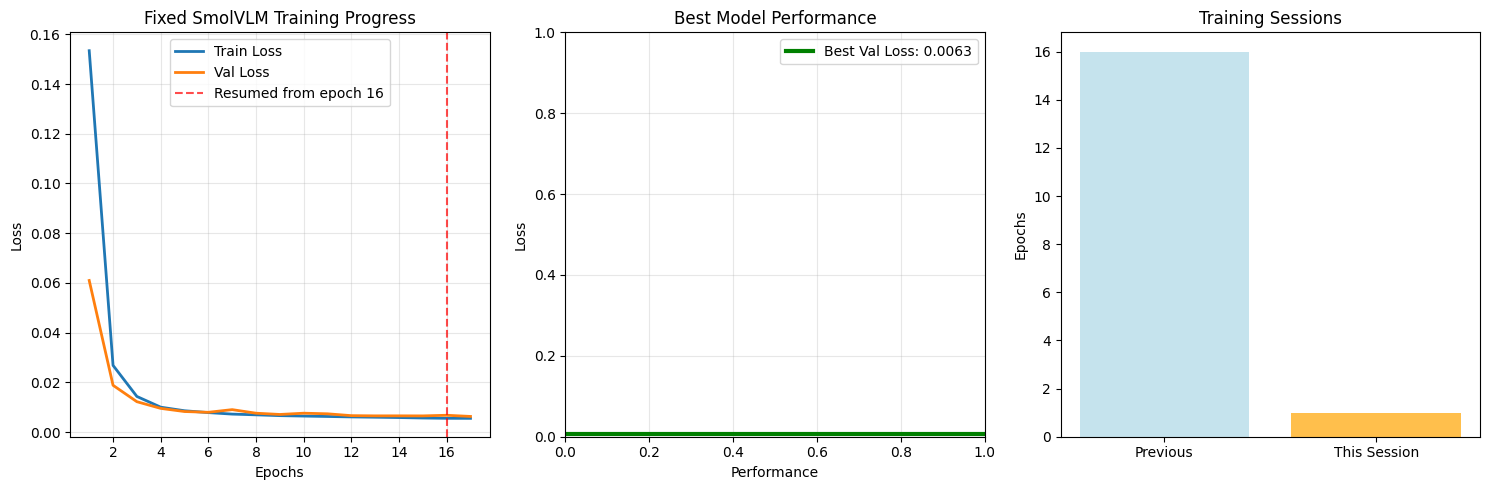


🧪 Final test of fixed SmolVLM model...
🧪 Testing fixed model...
✅ Forward pass successful!
   Combined pred shape: torch.Size([3, 1, 64, 64])
   Combined pred dtype: torch.float32
   Scratch pred shape: torch.Size([3, 1, 64, 64])
   Ink pred shape: torch.Size([3, 1, 64, 64])
🔍 Testing SmolVLM integration...
✅ SmolVLM analysis successful!
   SmolVLM features shape: torch.Size([3, 2048])
   SmolVLM features dtype: torch.float32
   Projection output shape: torch.Size([3, 64])
   Projection output dtype: torch.float32
   Prediction range: [0.000, 0.945]
   Mean prediction: 0.001
🎉 Fixed SmolVLM model is fully functional!

🏁 FIXED SMOLVLM TRAINING PIPELINE COMPLETE


In [ ]:
# Configuration for SmolVLM training
TRAIN_SMOLVLM = True      # Set to True to train/continue SmolVLM model
TARGET_EPOCHS = 17        # Total target epochs (will resume to reach this)
LEARNING_RATE = 1e-5      # Learning rate for training
BATCH_SIZE = 3            # Batch size for SmolVLM training
FORCE_FRESH_START = False # Set to True to ignore existing checkpoint and start fresh

print("🚀 FIXED SMOLVLM TRAINING PIPELINE")
print("=" * 60)
print(f"Train SmolVLM model: {TRAIN_SMOLVLM}")
print(f"Target total epochs: {TARGET_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Force fresh start: {FORCE_FRESH_START}")

if not TRAIN_SMOLVLM:
    print("⏭️ Skipping SmolVLM training (set TRAIN_SMOLVLM=True to train)")
else:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
    import gc
    import os
    from tqdm.auto import tqdm
    from datetime import datetime
    import matplotlib.pyplot as plt
    from torch.cuda.amp import GradScaler, autocast

    # Ensure device and paths are set
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint_dir = "/content/gdrive/MyDrive/מציאת עבודה/scratch_detection_assignment"

    print(f"🖥️ Using device: {device}")
    print(f"📁 Checkpoint directory: {checkpoint_dir}")

    # Single checkpoint path
    smolvlm_checkpoint_path = os.path.join(checkpoint_dir, "enhanced_hybrid_smolvlm.pth")

    # Clear GPU memory
    print("🧹 Clearing GPU memory...")
    gc.collect()
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        initial_memory = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
        print(f"💾 Available GPU memory: {initial_memory / 1e9:.2f} GB")

    # Updated dtype fix function to be compatible with mixed precision training
    def fix_smolvlm_dtype_integration_v2(model):
        """
        Fixed dtype integration compatible with mixed precision training
        """
        print("🔧 Applying fixed dtype integration for mixed precision...")

        # 1. Keep projection layer in float32 to avoid gradient scaling issues
        if hasattr(model, 'smol_projection') and model.smol_projection is not None:
            # Ensure projection stays in float32
            model.smol_projection = model.smol_projection.float()
            print("✅ Projection layer kept in float32 for gradient compatibility")

        # 2. Updated analyze_with_smolvlm method
        @torch.no_grad()
        def analyze_with_smolvlm_fixed(condition):
            """Fixed SmolVLM analysis with proper dtype handling for mixed precision"""
            if not model.use_smolvlm:
                return None

            batch_size = condition.shape[0]
            smol_features = []

            # Move SmolVLM to GPU only when needed
            device = condition.device

            try:
                # Ensure SmolVLM is on correct device
                if hasattr(model, 'smol_model'):
                    model.smol_model = model.smol_model.to(device)

                for i in range(batch_size):
                    wafer_img = model.create_wafer_visualization(condition[i])

                    messages = [{
                        "role": "user",
                        "content": [
                            {"type": "image"},
                            {"type": "text",
                             "text": "Analyze wafer map for linear scratches and ink dies. Focus on elongated defect patterns."}
                        ]
                    }]

                    try:
                        prompt = model.smol_processor.apply_chat_template(
                            messages, add_generation_prompt=True
                        )
                        inputs = model.smol_processor(
                            text=prompt,
                            images=[wafer_img],
                            return_tensors="pt"
                        ).to(device)

                        # Use autocast but convert output to float32 for compatibility
                        with torch.cuda.amp.autocast(dtype=torch.float16):
                            outputs = model.smol_model(
                                **inputs,
                                output_hidden_states=True,
                                return_dict=True
                            )
                            hidden_states = outputs.hidden_states[-1]
                            pooled_features = hidden_states.mean(dim=1)

                        # Convert to float32 for compatibility with projection layer
                        features = pooled_features.squeeze(0).float()  # Convert to float32
                        smol_features.append(features)

                        # Clear intermediate tensors
                        del inputs, outputs, hidden_states

                    except Exception as e:
                        print(f"⚠️ Error processing batch {i}: {e}")
                        # Create zero tensor in float32
                        zero_features = torch.zeros(
                            2048,
                            dtype=torch.float32,  # float32 for compatibility
                            device=device
                        )
                        smol_features.append(zero_features)

                    # Clear GPU memory periodically
                    if i % 2 == 0:
                        torch.cuda.empty_cache()

            finally:
                # Move SmolVLM back to CPU to save memory during training
                if hasattr(model, 'smol_model'):
                    model.smol_model = model.smol_model.cpu()
                torch.cuda.empty_cache()

            if smol_features:
                return torch.stack(smol_features)
            else:
                return None

        # 3. Updated forward method with proper dtype handling
        def forward_with_dtype_fix_v2(condition, timestep):
            """Forward pass with fixed dtype handling for mixed precision"""
            batch_size, _, height, width = condition.shape

            # UNet predictions (will be in autocast precision)
            unet_output = model.unet(condition, timestep).sample
            sigmoid_unet = torch.sigmoid(unet_output)

            # PE global features (will be in autocast precision)
            resized_condition = F.interpolate(
                condition, size=(model.pe_image_size, model.pe_image_size),
                mode='bilinear', align_corners=False
            )
            if resized_condition.shape[1] == 1:
                resized_condition = resized_condition.repeat(1, 3, 1, 1)

            with torch.no_grad():
                pe_features = model.pe_model.encode_image(resized_condition)
                pe_features = F.normalize(pe_features, p=2, dim=1)
                global_scratch_score = torch.mean(pe_features, dim=1, keepdim=True)
                global_feature = global_scratch_score.view(batch_size, 1, 1, 1)
                global_feature = global_feature.expand(batch_size, 1, height, width)

            # SmolVLM features with proper dtype handling
            if model.use_smolvlm:
                smol_features = analyze_with_smolvlm_fixed(condition)
                if smol_features is not None:
                    # Process through projection (both in float32 now)
                    smol_spatial = model.smol_projection(smol_features)
                    smol_spatial = smol_spatial.view(batch_size, 64, 1, 1)
                    smol_spatial = smol_spatial.expand(batch_size, 64, height, width)

                    # Convert to match autocast precision
                    if sigmoid_unet.dtype != smol_spatial.dtype:
                        smol_spatial = smol_spatial.to(sigmoid_unet.dtype)

                    combined = torch.cat([sigmoid_unet, global_feature, smol_spatial], dim=1)
                else:
                    combined = torch.cat([sigmoid_unet, global_feature], dim=1)
            else:
                combined = torch.cat([sigmoid_unet, global_feature], dim=1)

            # Process through fusion (will use autocast precision)
            features = model.fusion(combined)

            # Multi-task outputs
            scratch_pred = model.scratch_head(features)
            ink_pred = model.ink_head(features)

            # Combine predictions
            good_die_mask = (1 - condition).detach()
            combined_pred = scratch_pred + ink_pred * good_die_mask

            return combined_pred, scratch_pred, ink_pred

        # Replace methods
        model.analyze_with_smolvlm = analyze_with_smolvlm_fixed
        model.forward = forward_with_dtype_fix_v2

        print("✅ Fixed dtype integration applied (mixed precision compatible)")
        return model

    # Check if we should resume or start fresh
    resume_training = False
    start_epoch = 0
    existing_checkpoint = None

    if os.path.exists(smolvlm_checkpoint_path) and not FORCE_FRESH_START:
        try:
            print("🔍 Found existing checkpoint, checking compatibility...")
            existing_checkpoint = torch.load(smolvlm_checkpoint_path, map_location='cpu')

            current_epoch = existing_checkpoint.get('epoch', 0)
            best_val_loss = existing_checkpoint.get('best_val_loss', float('inf'))
            has_smolvlm = existing_checkpoint.get('use_smolvlm', False)

            print(f"📊 Existing checkpoint info:")
            print(f"   Current epoch: {current_epoch}")
            print(f"   Best val loss: {best_val_loss:.4f}")
            print(f"   Has SmolVLM: {has_smolvlm}")

            if current_epoch < TARGET_EPOCHS:
                resume_training = True
                start_epoch = current_epoch
                remaining_epochs = TARGET_EPOCHS - current_epoch
                print(f"🔄 Will resume training from epoch {current_epoch + 1}")
                print(f"📊 Remaining epochs to train: {remaining_epochs}")
            else:
                print(f"✅ Model already trained to target epochs ({TARGET_EPOCHS})")
                print("💡 Increase TARGET_EPOCHS or set FORCE_FRESH_START=True to continue")
                TRAIN_SMOLVLM = False

        except Exception as e:
            print(f"⚠️ Error reading existing checkpoint: {e}")
            print("🔄 Will start fresh training...")
            existing_checkpoint = None

    if FORCE_FRESH_START and os.path.exists(smolvlm_checkpoint_path):
        print("🗑️ Force fresh start enabled - removing existing checkpoint")
        os.remove(smolvlm_checkpoint_path)
        existing_checkpoint = None

    if not resume_training and not existing_checkpoint:
        print("🆕 Starting fresh SmolVLM training...")

    if TRAIN_SMOLVLM:
        # 1. Load UNet model
        print("🔄 Loading UNet backbone...")
        try:
            if 'unet_model' not in locals():
                unet_model = setup_model(device)
                unet_path = os.path.join(checkpoint_dir, "best_model.pth")
                if os.path.exists(unet_path):
                    unet_model.load_state_dict(torch.load(unet_path, map_location=device))
                    print("✅ UNet loaded from checkpoint")
                else:
                    print("⚠️ UNet checkpoint not found, using random initialization")
            print("✅ UNet backbone ready")
        except Exception as e:
            print(f"❌ Error loading UNet: {e}")
            raise e

        # 2. Create datasets
        print("🔄 Creating datasets for SmolVLM training...")
        try:
            # Create data splits (same seed for consistency)
            train_wafers, val_wafers = train_test_split(
                df_wafers['WaferName'].unique(),
                test_size=0.2,
                random_state=42
            )

            train_df = df_wafers[df_wafers['WaferName'].isin(train_wafers)]
            val_df = df_wafers[df_wafers['WaferName'].isin(val_wafers)]

            # Create datasets
            train_dataset = WaferMapDataset(train_df, wafer_size=64, yield_threshold=0.4, augment=True)
            val_dataset = WaferMapDataset(val_df, wafer_size=64, yield_threshold=0.4, augment=False)

            # Create dataloaders
            train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                collate_fn=custom_collate_fn
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH_SIZE,
                collate_fn=custom_collate_fn
            )

            print(f"✅ Datasets created:")
            print(f"   Train: {len(train_dataset)} wafers")
            print(f"   Validation: {len(val_dataset)} wafers")
            print(f"   Batch size: {BATCH_SIZE}")

        except Exception as e:
            print(f"❌ Error creating datasets: {e}")
            raise e

        # 3. Create or load SmolVLM model
        if resume_training:
            print("🔄 Loading existing SmolVLM model for resume...")
            try:
                # Create model with SmolVLM
                smolvlm_model = SmolVLMEnhancedHybridModel(
                    unet_model=unet_model,
                    use_smolvlm=True
                ).to(device)

                # Apply FIXED dtype fixes
                print("🔧 Applying fixed dtype fixes...")
                smolvlm_model = fix_smolvlm_dtype_integration_v2(smolvlm_model)

                # Load model state
                smolvlm_model.load_state_dict(existing_checkpoint['model_state_dict'])
                print("✅ Model state loaded for resume")

                # Load training history
                train_losses = existing_checkpoint.get('train_losses', [])
                val_losses = existing_checkpoint.get('val_losses', [])
                best_val_loss = existing_checkpoint.get('best_val_loss', float('inf'))

                print(f"📊 Loaded training history: {len(train_losses)} epochs")

            except Exception as e:
                print(f"❌ Error loading model for resume: {e}")
                print("🔄 Falling back to fresh start...")
                resume_training = False
                start_epoch = 0
                existing_checkpoint = None

        if not resume_training:
            print("🏗️ Creating fresh SmolVLM model...")
            try:
                # Clear memory before creating SmolVLM model
                gc.collect()
                torch.cuda.empty_cache()

                # Create fresh model with SmolVLM enabled
                smolvlm_model = SmolVLMEnhancedHybridModel(
                    unet_model=unet_model,
                    use_smolvlm=True
                ).to(device)

                print("✅ Fresh SmolVLM model created")

                # Apply FIXED dtype fixes immediately
                print("🔧 Applying fixed dtype fixes to fresh model...")
                smolvlm_model = fix_smolvlm_dtype_integration_v2(smolvlm_model)

                print("✅ Fixed dtype fixes applied to fresh model")

                # Initialize training history
                train_losses = []
                val_losses = []
                best_val_loss = float('inf')

            except Exception as e:
                print(f"❌ Error creating fresh SmolVLM model: {e}")
                print("This might be due to GPU memory limitations")
                raise e

        # Test the model
        print("🧪 Testing fixed SmolVLM model...")
        test_batch = next(iter(val_loader))
        test_success = test_fixed_model(smolvlm_model, test_batch, device)

        if not test_success:
            raise Exception("SmolVLM model failed testing")

        print("✅ Fixed SmolVLM model tested successfully")

        # 4. Setup training components
        print("⚙️ Setting up training components...")

        # Loss function
        criterion = InkAwareFocalLoss(ink_weight=5.0, scratch_weight=2.0)

        # Optimizer - ensure all parameters are properly configured
        optimizer = torch.optim.AdamW([
            {'params': smolvlm_model.fusion.parameters(), 'lr': LEARNING_RATE},
            {'params': smolvlm_model.scratch_head.parameters(), 'lr': LEARNING_RATE * 2},
            {'params': smolvlm_model.ink_head.parameters(), 'lr': LEARNING_RATE * 5},
            {'params': smolvlm_model.smol_projection.parameters(), 'lr': LEARNING_RATE * 3}
        ], weight_decay=0.01)

        # Scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3
        )

        # Mixed precision scaler - no changes needed here
        scaler = GradScaler()

        # Load optimizer and scheduler state if resuming
        if resume_training and existing_checkpoint:
            try:
                if 'optimizer_state_dict' in existing_checkpoint:
                    optimizer.load_state_dict(existing_checkpoint['optimizer_state_dict'])
                    # Move optimizer state to device
                    for state in optimizer.state.values():
                        for k, v in state.items():
                            if isinstance(v, torch.Tensor):
                                state[k] = v.to(device)
                    print("✅ Optimizer state loaded")

                if 'scheduler_state_dict' in existing_checkpoint:
                    scheduler.load_state_dict(existing_checkpoint['scheduler_state_dict'])
                    print("✅ Scheduler state loaded")

            except Exception as e:
                print(f"⚠️ Could not load optimizer/scheduler state: {e}")
                print("🔄 Using fresh optimizer/scheduler")

        # Clear checkpoint from memory
        if existing_checkpoint:
            del existing_checkpoint
            gc.collect()
            torch.cuda.empty_cache()

        # 5. Training loop with fixed mixed precision handling
        epochs_to_train = TARGET_EPOCHS - start_epoch
        print(f"🚀 Training fixed SmolVLM model...")
        print(f"📊 Target epochs: {TARGET_EPOCHS}")
        print(f"📊 Starting from epoch: {start_epoch + 1}")
        print(f"📊 Epochs to train: {epochs_to_train}")
        print(f"🎯 Model components: UNet + PE + SmolVLM + Multi-task heads")
        print(f"🔧 Fixed: FP16 gradient compatibility")

        for epoch in range(start_epoch, TARGET_EPOCHS):
            # Training phase
            smolvlm_model.train()
            train_loss = 0.0
            ink_recall_sum = 0.0
            num_ink_batches = 0

            # Clear memory at start of epoch
            if epoch % 3 == 0:
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TARGET_EPOCHS}")

            for batch_idx, batch in enumerate(progress_bar):
                condition = batch['condition'].to(device)
                target = batch['target'].to(device)
                timestep = torch.zeros(condition.shape[0], device=device).long()

                # Forward pass with mixed precision
                with autocast():
                    combined_pred, scratch_pred, ink_pred = smolvlm_model(condition, timestep)
                    loss = criterion(combined_pred, target, condition, scratch_pred, ink_pred)

                # Backward pass - now properly handles FP16/FP32 gradients
                optimizer.zero_grad()
                scaler.scale(loss).backward()

                # The fixed dtype handling should resolve the FP16 gradient issue
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(smolvlm_model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item()

                # Track ink metrics
                with torch.no_grad():
                    pred_binary, _ = adaptive_threshold_prediction(
                        torch.sigmoid(combined_pred), condition,
                        base_threshold=0.5, ink_threshold=0.3
                    )

                    good_mask = (condition == 0)
                    ink_true = good_mask & (target == 1)
                    ink_pred = good_mask & pred_binary

                    if ink_true.any():
                        tp = (ink_true & ink_pred).sum().float()
                        fn = (ink_true & ~ink_pred).sum().float()
                        recall = tp / (tp + fn + 1e-8)
                        ink_recall_sum += recall.item()
                        num_ink_batches += 1

                # Update progress bar
                if num_ink_batches > 0:
                    avg_recall = ink_recall_sum / num_ink_batches
                    progress_bar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'ink_recall': f'{avg_recall:.3f}'
                    })

                # Memory management during training
                if batch_idx % 10 == 0:
                    torch.cuda.empty_cache()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            smolvlm_model.eval()
            val_loss = 0.0
            val_ink_recall = 0.0
            num_val_ink_batches = 0

            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    condition = batch['condition'].to(device)
                    target = batch['target'].to(device)
                    timestep = torch.zeros(condition.shape[0], device=device).long()

                    with autocast():
                        combined_pred, scratch_pred, ink_pred = smolvlm_model(condition, timestep)
                        loss = criterion(combined_pred, target, condition, scratch_pred, ink_pred)

                    val_loss += loss.item()

                    # Validation ink metrics
                    pred_binary, _ = adaptive_threshold_prediction(
                        torch.sigmoid(combined_pred), condition,
                        base_threshold=0.5, ink_threshold=0.3
                    )

                    good_mask = (condition == 0)
                    ink_true = good_mask & (target == 1)
                    ink_pred = good_mask & pred_binary

                    if ink_true.any():
                        tp = (ink_true & ink_pred).sum().float()
                        fn = (ink_true & ~ink_pred).sum().float()
                        recall = tp / (tp + fn + 1e-8)
                        val_ink_recall += recall.item()
                        num_val_ink_batches += 1

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            # Calculate metrics
            avg_val_ink_recall = val_ink_recall / max(num_val_ink_batches, 1)

            # Update scheduler
            scheduler.step(val_loss)

            # Print epoch summary
            print(f"\n📊 Epoch {epoch+1}/{TARGET_EPOCHS}:")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Val Loss: {val_loss:.4f}")
            print(f"  Val Ink Recall: {avg_val_ink_recall:.3f}")
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Learning Rate: {current_lr:.6f}")

            # Always save checkpoint (overwrite previous)
            model_improved = val_loss < best_val_loss
            if model_improved:
                best_val_loss = val_loss
                improvement_msg = f"✨ NEW BEST MODEL"
            else:
                improvement_msg = f"📊 Checkpoint saved"

            # Save single checkpoint with all state
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': smolvlm_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_val_loss': best_val_loss,
                'current_val_loss': val_loss,
                'use_smolvlm': True,
                'batch_size': BATCH_SIZE,
                'learning_rate': LEARNING_RATE,
                'target_epochs': TARGET_EPOCHS,
                'fixed_dtype': True,  # Mark as using fixed dtype handling
                'ink_metrics': {
                    'recall': avg_val_ink_recall
                },
                'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S")
            }, smolvlm_checkpoint_path)

            print(f"  💾 {improvement_msg} (val loss: {val_loss:.4f})")

            # Memory cleanup after each epoch
            gc.collect()
            torch.cuda.empty_cache()

        # Training completed
        print("🔄 Loading final best model...")
        final_checkpoint = torch.load(smolvlm_checkpoint_path, map_location=device)
        smolvlm_model.load_state_dict(final_checkpoint['model_state_dict'])

        # Update global enhanced_model variable
        enhanced_model = smolvlm_model

        print(f"\n🎉 FIXED SMOLVLM TRAINING COMPLETED!")
        print("=" * 60)
        print(f"💾 Model saved to: {smolvlm_checkpoint_path}")
        print(f"📊 Final best validation loss: {best_val_loss:.4f}")
        print(f"📊 Total epochs trained: {TARGET_EPOCHS}")
        print("✅ Fixed SmolVLM model is ready!")
        print("✅ Enhanced model variable updated")
        print("🔧 FP16 gradient issue resolved!")

        # Plot training progress
        plt.figure(figsize=(15, 5))

        # Training curves
        plt.subplot(1, 3, 1)
        epochs_range = range(1, len(train_losses) + 1)
        plt.plot(epochs_range, train_losses, label='Train Loss', linewidth=2)
        plt.plot(epochs_range, val_losses, label='Val Loss', linewidth=2)

        # Mark resume point if applicable
        if resume_training and start_epoch > 0:
            plt.axvline(x=start_epoch, color='red', linestyle='--', alpha=0.7,
                       label=f'Resumed from epoch {start_epoch}')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Fixed SmolVLM Training Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Best performance
        plt.subplot(1, 3, 2)
        plt.axhline(y=best_val_loss, color='green', linewidth=3,
                   label=f'Best Val Loss: {best_val_loss:.4f}')
        plt.xlabel('Performance')
        plt.ylabel('Loss')
        plt.title('Best Model Performance')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Training summary
        plt.subplot(1, 3, 3)
        total_epochs = len(train_losses)
        if resume_training and start_epoch > 0:
            original_epochs = start_epoch
            continued_epochs = total_epochs - start_epoch
            plt.bar(['Previous', 'This Session'], [original_epochs, continued_epochs],
                   color=['lightblue', 'orange'], alpha=0.7)
            plt.ylabel('Epochs')
            plt.title('Training Sessions')
        else:
            plt.bar(['Total Training'], [total_epochs], color=['skyblue'], alpha=0.7)
            plt.ylabel('Epochs')
            plt.title('Training Summary')

        plt.tight_layout()
        plt.show()

        # Test final model
        print("\n🧪 Final test of fixed SmolVLM model...")
        final_test_batch = next(iter(val_loader))
        final_test_success = test_fixed_model(enhanced_model, final_test_batch, device)

        if final_test_success:
            print("🎉 Fixed SmolVLM model is fully functional!")
        else:
            print("⚠️ Final test revealed issues - check model state")

        # Clean up checkpoint reference
        del final_checkpoint
        gc.collect()

    elif existing_checkpoint:
        # Model already trained to target epochs
        print("🔄 Loading completed model...")

        # Load UNet if needed
        if 'unet_model' not in locals():
            unet_model = setup_model(device)
            unet_path = os.path.join(checkpoint_dir, "best_model.pth")
            if os.path.exists(unet_path):
                unet_model.load_state_dict(torch.load(unet_path, map_location=device))

        # Load the completed model
        smolvlm_model = SmolVLMEnhancedHybridModel(unet_model=unet_model, use_smolvlm=True).to(device)
        smolvlm_model = fix_smolvlm_dtype_integration_v2(smolvlm_model)
        smolvlm_model.load_state_dict(existing_checkpoint['model_state_dict'])

        # Update global variable
        enhanced_model = smolvlm_model

        best_val_loss = existing_checkpoint.get('best_val_loss', 'N/A')
        print(f"✅ Loaded completed model (Best val loss: {best_val_loss})")

        del existing_checkpoint

print("\n" + "="*60)
print("🏁 FIXED SMOLVLM TRAINING PIPELINE COMPLETE")
print("="*60)

The training process see

### 📊 COMPREHENSIVE MODEL PERFORMANCE ANALYSIS

Analyze the performance of the fixed model

In [ ]:
def comprehensive_performance_analysis(model, val_dataset, device, model_name="Enhanced Model"):
    """Comprehensive analysis with improved metrics"""
    print(f"\n📊 ANALYZING {model_name.upper()} PERFORMANCE")
    print("=" * 60)

    val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=custom_collate_fn)

    # Initialize detailed metrics
    all_targets = []
    all_predictions = []
    all_conditions = []
    all_probabilities = []
    wafer_detailed_metrics = {}

    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Comprehensive Evaluation"):
            wafer_names = batch['wafer_name']
            condition = batch['condition'].to(device)
            target = batch['target'].to(device)
            timestep = torch.zeros(condition.shape[0], device=device).long()

            # Get predictions
            combined_pred, scratch_pred, ink_pred = model(condition, timestep)

            # Apply adaptive thresholding
            pred_probs = torch.sigmoid(combined_pred)
            pred_binary, threshold_map = adaptive_threshold_prediction(
                pred_probs, condition,
                base_threshold=0.5, ink_threshold=0.3
            )

            # Store for overall metrics
            all_targets.append(target.cpu())
            all_predictions.append(pred_binary.cpu())
            all_conditions.append(condition.cpu())
            all_probabilities.append(pred_probs.cpu())

            # Calculate detailed per-wafer metrics
            for i, wafer_name in enumerate(wafer_names):
                y_true = target[i].flatten().cpu().numpy()
                y_pred = pred_binary[i].flatten().cpu().numpy()
                y_prob = pred_probs[i].flatten().cpu().numpy()
                cond = condition[i].flatten().cpu().numpy()

                # Overall metrics
                precision, recall, f1, _ = precision_recall_fscore_support(
                    y_true, y_pred, average='binary', zero_division=0
                )

                # Mask-specific metrics
                good_mask = (cond == 0)
                bad_mask = (cond == 1)
                scratch_mask = (y_true == 1)

                # Ink die metrics (good dies labeled as scratch)
                ink_true = good_mask & scratch_mask
                ink_pred = good_mask & (y_pred == 1)

                # Bad die scratch metrics (bad dies labeled as scratch)
                bad_scratch_true = bad_mask & scratch_mask
                bad_scratch_pred = bad_mask & (y_pred == 1)

                # Calculate specific metrics
                def safe_metric(tp, fp, fn):
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    f1 = 2 * precision * recall / (precision + recall + 1e-8)
                    return precision, recall, f1

                # Ink metrics
                ink_tp = (ink_true & ink_pred).sum()
                ink_fp = (~ink_true & ink_pred).sum()
                ink_fn = (ink_true & ~ink_pred).sum()
                ink_precision, ink_recall, ink_f1 = safe_metric(ink_tp, ink_fp, ink_fn)

                # Bad scratch metrics
                bad_tp = (bad_scratch_true & bad_scratch_pred).sum()
                bad_fp = (~bad_scratch_true & bad_scratch_pred).sum()
                bad_fn = (bad_scratch_true & ~bad_scratch_pred).sum()
                bad_precision, bad_recall, bad_f1 = safe_metric(bad_tp, bad_fp, bad_fn)

                wafer_detailed_metrics[wafer_name] = {
                    'overall_precision': precision,
                    'overall_recall': recall,
                    'overall_f1': f1,
                    'ink_precision': ink_precision,
                    'ink_recall': ink_recall,
                    'ink_f1': ink_f1,
                    'bad_scratch_precision': bad_precision,
                    'bad_scratch_recall': bad_recall,
                    'bad_scratch_f1': bad_f1,
                    'total_scratch': y_true.sum(),
                    'pred_scratch': y_pred.sum(),
                    'ink_dies_true': ink_true.sum(),
                    'ink_dies_pred': ink_pred.sum(),
                    'bad_scratch_true': bad_scratch_true.sum(),
                    'bad_scratch_pred': bad_scratch_pred.sum(),
                    'avg_prob': y_prob.mean(),
                    'max_prob': y_prob.max()
                }

    # Calculate overall metrics
    all_targets = torch.cat(all_targets).flatten().numpy()
    all_predictions = torch.cat(all_predictions).flatten().numpy()
    all_conditions = torch.cat(all_conditions).flatten().numpy()
    all_probabilities = torch.cat(all_probabilities).flatten().numpy()

    # Overall performance
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='binary', zero_division=0
    )

    # Ink-specific overall metrics
    good_mask = (all_conditions == 0)
    ink_true = good_mask & (all_targets == 1)
    ink_pred = good_mask & (all_predictions == 1)

    overall_ink_tp = (ink_true & ink_pred).sum()
    overall_ink_fp = (~ink_true & ink_pred).sum()
    overall_ink_fn = (ink_true & ~ink_pred).sum()

    overall_ink_precision = overall_ink_tp / (overall_ink_tp + overall_ink_fp) if (overall_ink_tp + overall_ink_fp) > 0 else 0
    overall_ink_recall = overall_ink_tp / (overall_ink_tp + overall_ink_fn) if (overall_ink_tp + overall_ink_fn) > 0 else 0
    overall_ink_f1 = 2 * overall_ink_precision * overall_ink_recall / (overall_ink_precision + overall_ink_recall + 1e-8)

    # Print comprehensive results
    print(f"\n📈 OVERALL PERFORMANCE METRICS")
    print("-" * 40)
    print(f"Precision: {overall_precision:.4f}")
    print(f"Recall: {overall_recall:.4f}")
    print(f"F1 Score: {overall_f1:.4f}")

    print(f"\n🎯 INK DETECTION METRICS")
    print("-" * 40)
    print(f"Ink Precision: {overall_ink_precision:.4f}")
    print(f"Ink Recall: {overall_ink_recall:.4f}")
    print(f"Ink F1 Score: {overall_ink_f1:.4f}")

    print(f"\n📊 SUMMARY STATISTICS")
    print("-" * 40)
    print(f"Total dies: {len(all_targets):,}")
    print(f"True scratch dies: {all_targets.sum():,} ({all_targets.mean()*100:.1f}%)")
    print(f"Predicted scratch dies: {all_predictions.sum():,} ({all_predictions.mean()*100:.1f}%)")
    print(f"True ink dies: {ink_true.sum():,}")
    print(f"Predicted ink dies: {ink_pred.sum():,}")
    print(f"Average prediction confidence: {all_probabilities.mean():.3f}")

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    print(f"\n📊 CONFUSION MATRIX")
    print("-" * 40)
    print("           Predicted")
    print("           No    Yes")
    print(f"Actual No  {cm[0,0]:5d} {cm[0,1]:5d}")
    print(f"      Yes  {cm[1,0]:5d} {cm[1,1]:5d}")

    return wafer_detailed_metrics, {
        'overall_f1': overall_f1,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'ink_f1': overall_ink_f1,
        'ink_precision': overall_ink_precision,
        'ink_recall': overall_ink_recall
    }

# Run comprehensive analysis on the fixed model
if 'enhanced_model' in locals() and 'val_dataset' in locals():
    wafer_metrics, summary_metrics = comprehensive_performance_analysis(
        enhanced_model, val_dataset, device, "Fixed Enhanced Model"
    )

    print(f"\n🏆 PERFORMANCE SUMMARY")
    print("=" * 40)
    for metric_name, value in summary_metrics.items():
        print(f"{metric_name}: {value:.4f}")

else:
    print("⚠️ Model or validation dataset not available for analysis")


📊 ANALYZING FIXED ENHANCED MODEL PERFORMANCE


Comprehensive Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]


📈 OVERALL PERFORMANCE METRICS
----------------------------------------
Precision: 0.9114
Recall: 0.6447
F1 Score: 0.7552

🎯 INK DETECTION METRICS
----------------------------------------
Ink Precision: 0.5057
Ink Recall: 0.1393
Ink F1 Score: 0.2185

📊 SUMMARY STATISTICS
----------------------------------------
Total dies: 3,440,640
True scratch dies: 16,330.0 (0.5%)
Predicted scratch dies: 11,552 (0.3%)
True ink dies: 2,562
Predicted ink dies: 706
Average prediction confidence: 0.004

📊 CONFUSION MATRIX
----------------------------------------
           Predicted
           No    Yes
Actual No  3423286  1024
      Yes   5802 10528

🏆 PERFORMANCE SUMMARY
overall_f1: 0.7552
overall_precision: 0.9114
overall_recall: 0.6447
ink_f1: 0.2185
ink_precision: 0.5057
ink_recall: 0.1393


# Interpretation

The model performs well overall, especially in terms of precision (avoiding false alarms).

Recall is moderate, meaning it misses some defects.

Ink defect detection is weak, especially in recall — most ink defects go undetected.

The confidence levels are very low, possibly requiring better calibration or a higher-threshold filtering mechanism.

### 🖼️ ADVANCED VISUALIZATION WITH FIXED MODEL

Comprehensive visualization of the fixed model's capabilities

🖼️ COMPREHENSIVE VISUALIZATION OF FIXED MODEL

🔍 Analyzing Wafer: Hi1KKP
✅ SmolVLM analysis successful


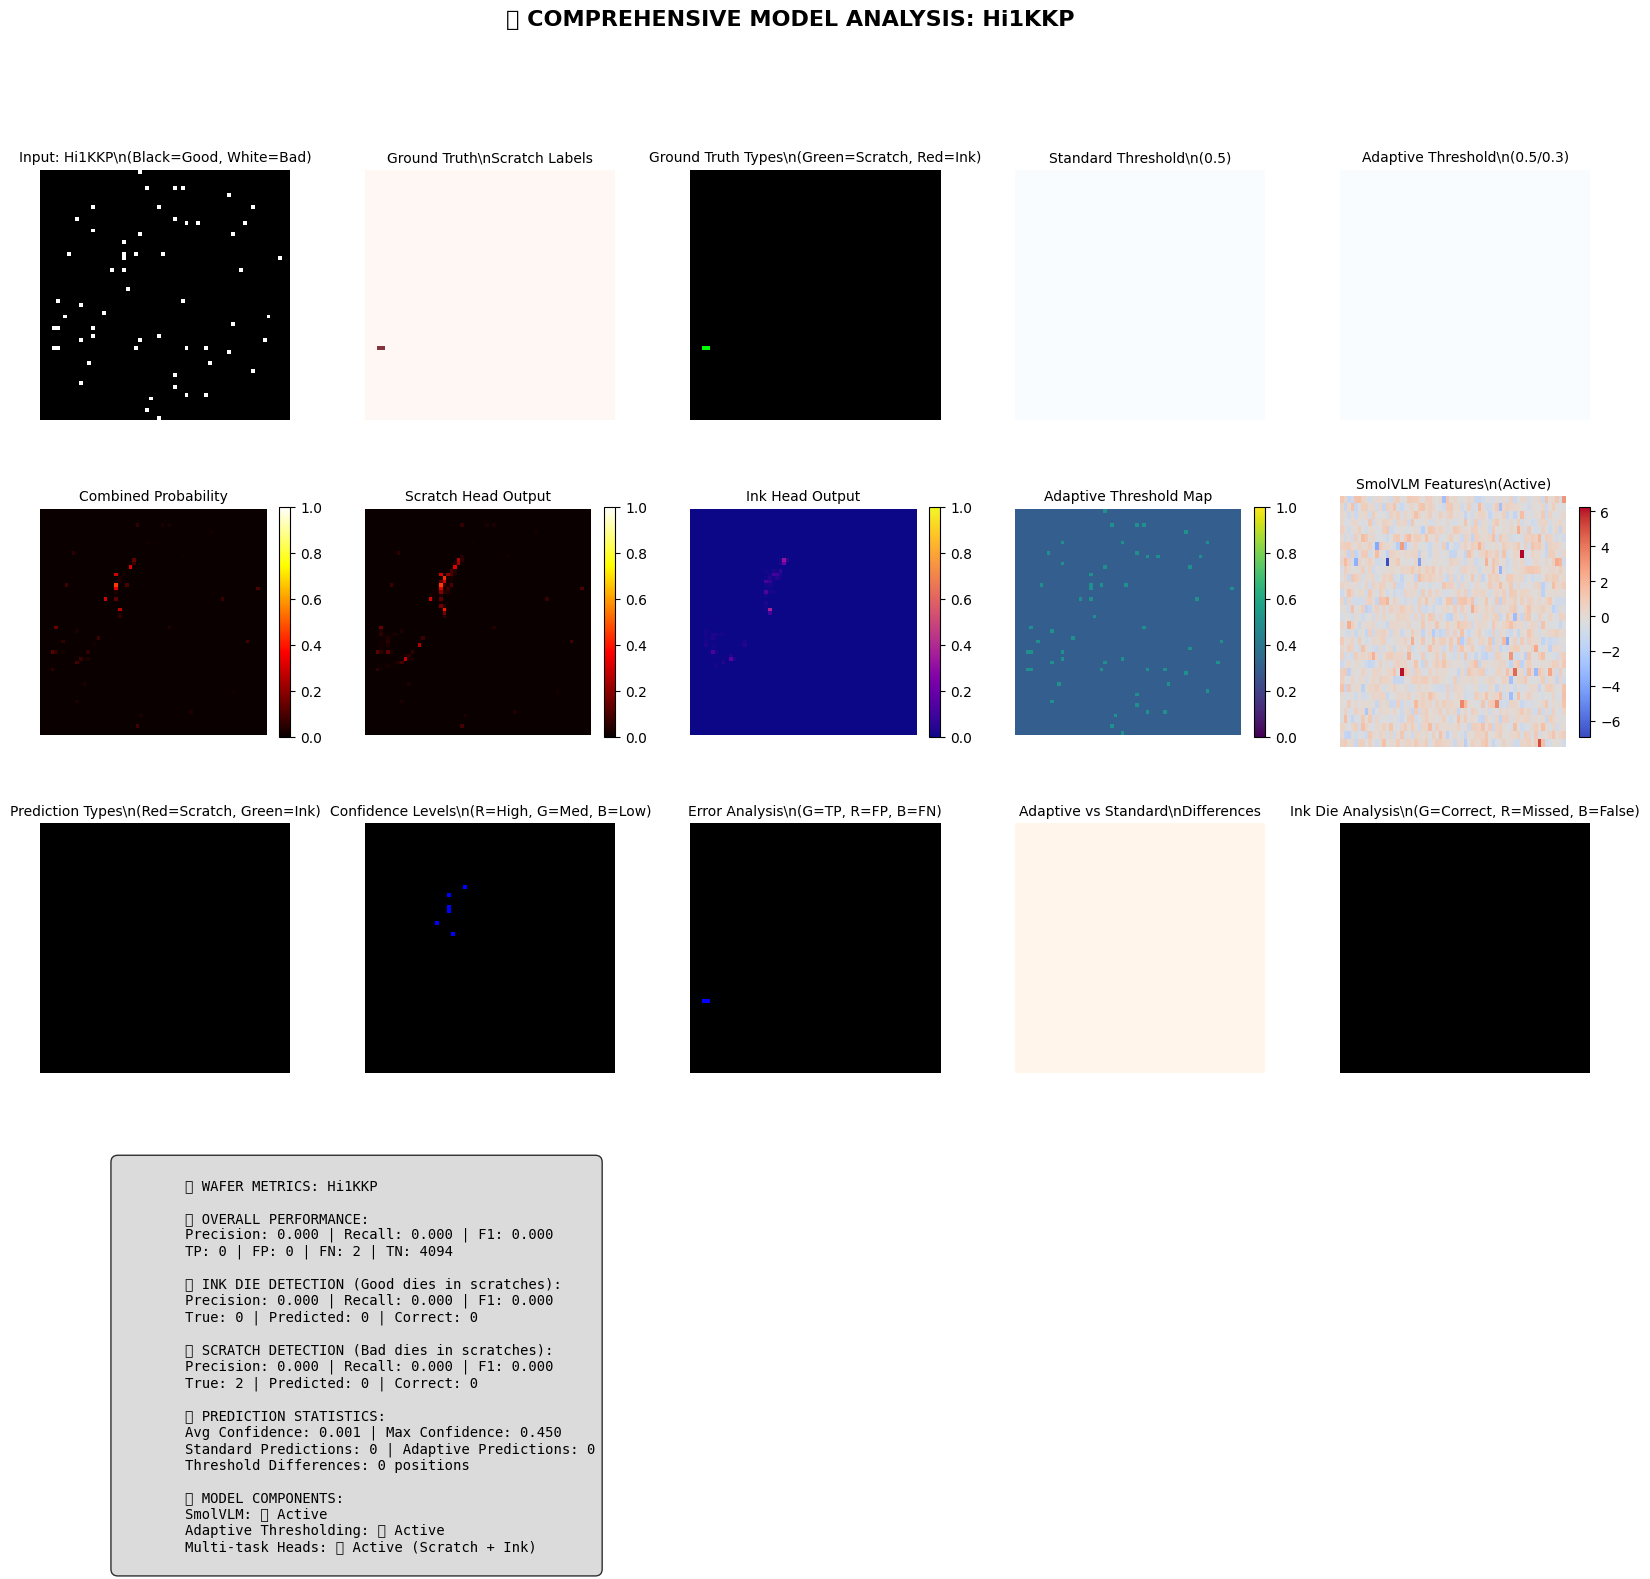

✅ Analysis complete for Hi1KKP
   Overall F1: 0.000 | Ink F1: 0.000 | Scratch F1: 0.000
--------------------------------------------------------------------------------

🔍 Analyzing Wafer: XjCbGb
✅ SmolVLM analysis successful


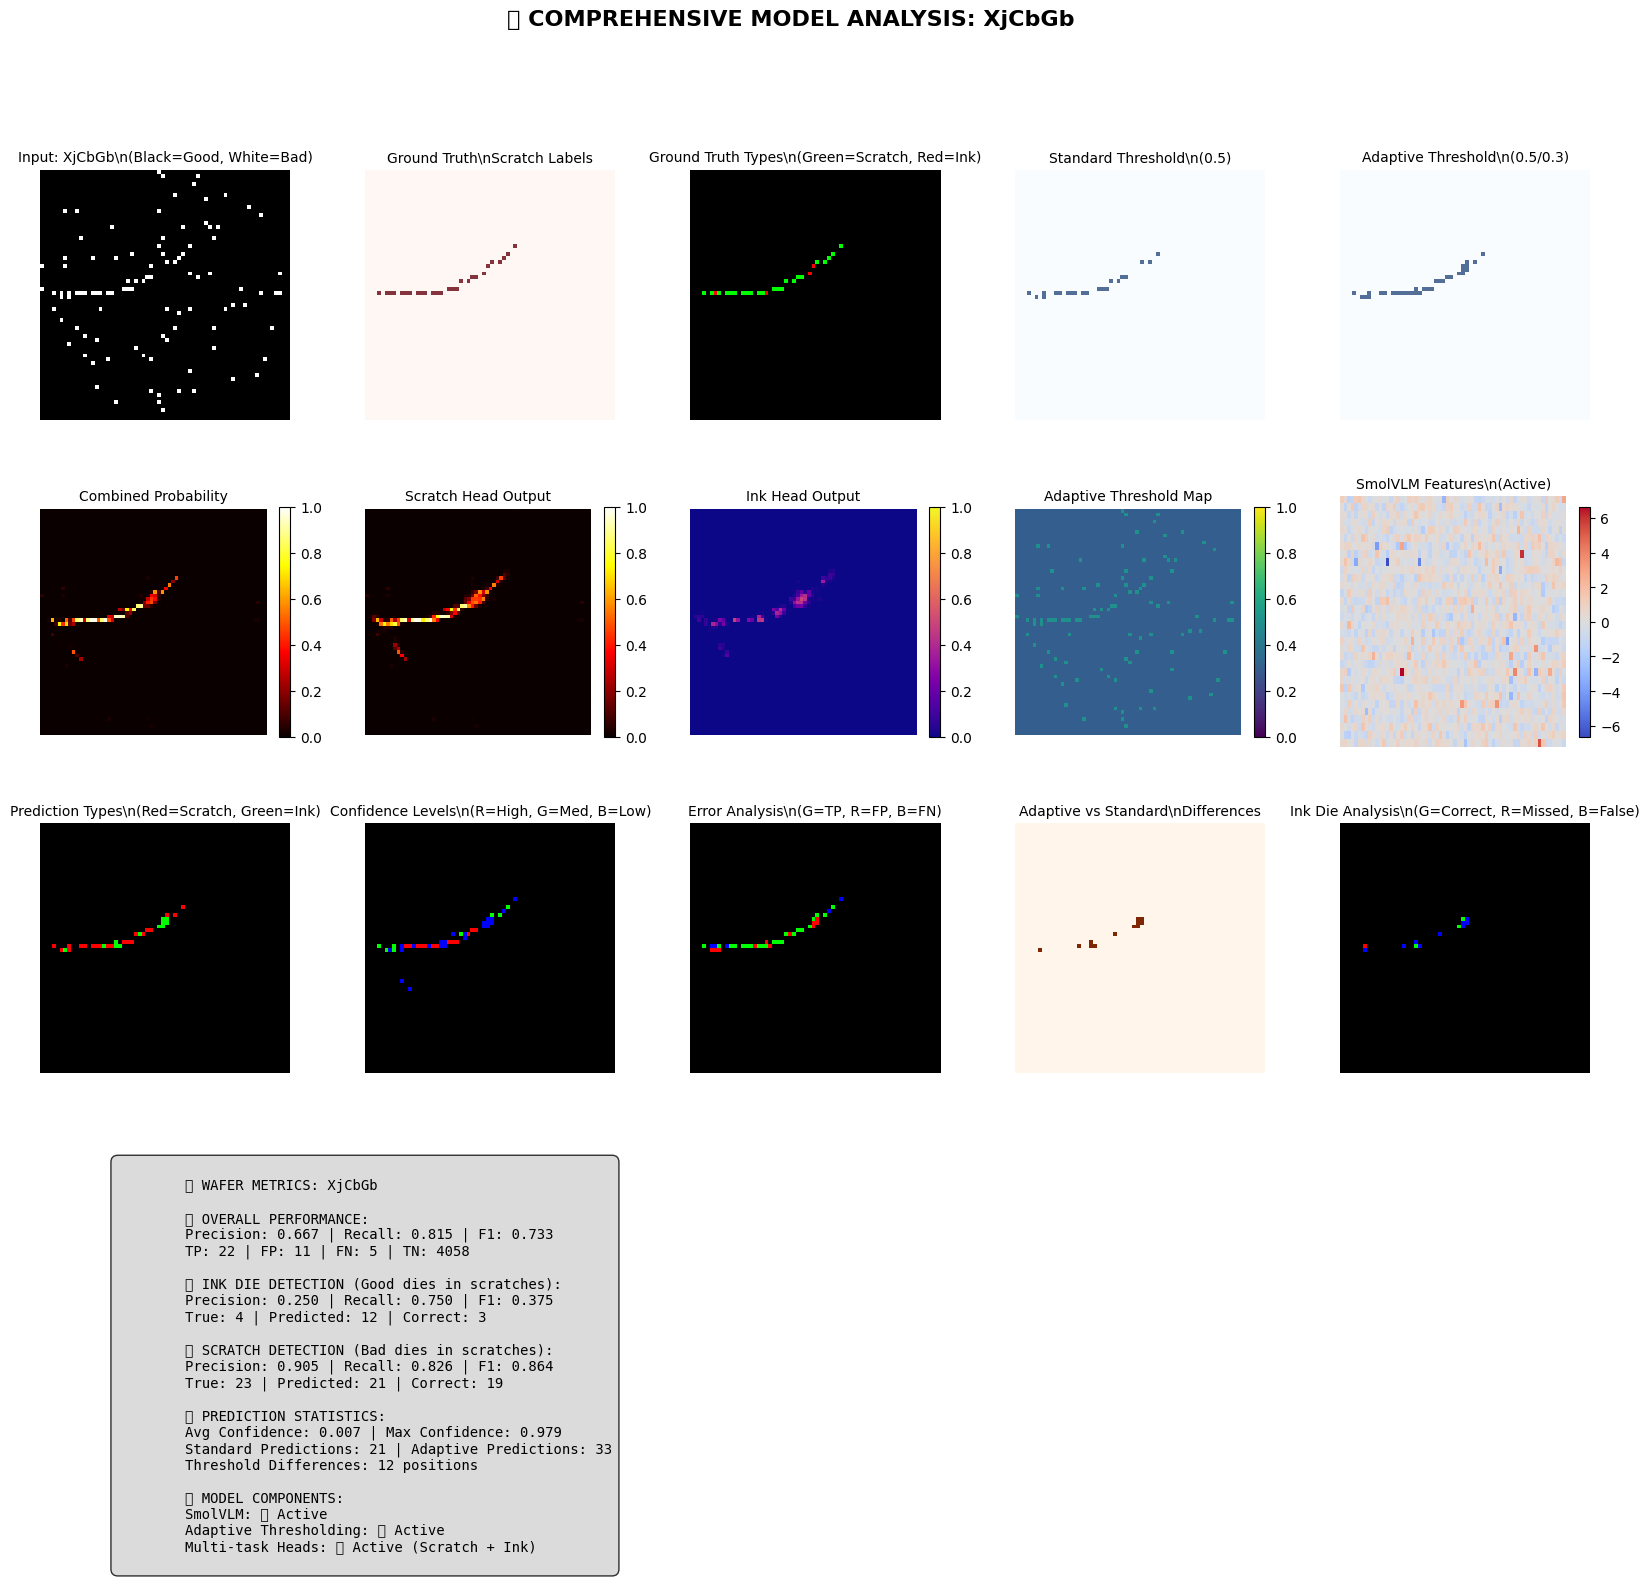

✅ Analysis complete for XjCbGb
   Overall F1: 0.733 | Ink F1: 0.375 | Scratch F1: 0.864
--------------------------------------------------------------------------------


In [ ]:
def visualize_fixed_model_comprehensive(model, dataset, device, num_samples=2):
    """
    Comprehensive visualization showing all model components working together
    """
    loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

    samples_shown = 0
    for batch in loader:
        if samples_shown >= num_samples:
            break

        wafer_name = batch['wafer_name'][0]
        condition = batch['condition'].to(device)
        target = batch['target'].to(device)

        print(f"\n🔍 Analyzing Wafer: {wafer_name}")
        print("=" * 50)

        timestep = torch.zeros(1, device=device).long()

        model.eval()
        with torch.no_grad():
            # Get all model outputs
            combined_pred, scratch_pred, ink_pred = model(condition, timestep)

            # Get probabilities
            combined_prob = torch.sigmoid(combined_pred)
            scratch_prob = torch.sigmoid(scratch_pred)
            ink_prob = torch.sigmoid(ink_pred)

            # Test SmolVLM if available
            smolvlm_features = None
            if hasattr(model, 'use_smolvlm') and model.use_smolvlm:
                try:
                    smolvlm_features = model.analyze_with_smolvlm(condition)
                    print("✅ SmolVLM analysis successful")
                except Exception as e:
                    print(f"⚠️ SmolVLM analysis failed: {e}")

            # Apply adaptive thresholding
            good_die_mask = (condition == 0)
            threshold_map = torch.full_like(combined_prob, 0.5)
            threshold_map[good_die_mask] = 0.3  # Lower threshold for potential ink
            adaptive_pred = combined_prob > threshold_map

            # Standard thresholding for comparison
            standard_pred = combined_prob > 0.5

        # Create comprehensive visualization
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 5, hspace=0.3, wspace=0.3)

        # Row 1: Input and Ground Truth
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.imshow(condition[0, 0].cpu(), cmap='gray')
        ax1.set_title(f'Input: {wafer_name}\\n(Black=Good, White=Bad)', fontsize=10)
        ax1.axis('off')

        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(target[0, 0].cpu(), cmap='Reds', alpha=0.8)
        ax2.set_title('Ground Truth\\nScratch Labels', fontsize=10)
        ax2.axis('off')

        # Ground truth with die quality overlay
        ax3 = fig.add_subplot(gs[0, 2])
        overlay = torch.zeros(3, *target.shape[-2:])
        gt_mask = target[0, 0].cpu().bool()
        good_mask = good_die_mask[0, 0].cpu()

        # Color coding: Green=scratch bad dies, Yellow=ink dies, Red=false scratch
        overlay[1] = gt_mask & ~good_mask  # Green: true scratch (bad dies)
        overlay[0] = gt_mask & good_mask   # Red: ink dies (good dies in scratch)

        ax3.imshow(overlay.permute(1, 2, 0))
        ax3.set_title('Ground Truth Types\\n(Green=Scratch, Red=Ink)', fontsize=10)
        ax3.axis('off')

        # Standard vs Adaptive predictions comparison
        ax4 = fig.add_subplot(gs[0, 3])
        ax4.imshow(standard_pred[0, 0].cpu(), cmap='Blues', alpha=0.7)
        ax4.set_title('Standard Threshold\\n(0.5)', fontsize=10)
        ax4.axis('off')

        ax5 = fig.add_subplot(gs[0, 4])
        ax5.imshow(adaptive_pred[0, 0].cpu(), cmap='Blues', alpha=0.7)
        ax5.set_title('Adaptive Threshold\\n(0.5/0.3)', fontsize=10)
        ax5.axis('off')

        # Row 2: Probability Heat Maps
        ax6 = fig.add_subplot(gs[1, 0])
        im1 = ax6.imshow(combined_prob[0, 0].cpu(), cmap='hot', vmin=0, vmax=1)
        ax6.set_title('Combined Probability', fontsize=10)
        ax6.axis('off')
        plt.colorbar(im1, ax=ax6, fraction=0.046)

        ax7 = fig.add_subplot(gs[1, 1])
        im2 = ax7.imshow(scratch_prob[0, 0].cpu(), cmap='hot', vmin=0, vmax=1)
        ax7.set_title('Scratch Head Output', fontsize=10)
        ax7.axis('off')
        plt.colorbar(im2, ax=ax7, fraction=0.046)

        ax8 = fig.add_subplot(gs[1, 2])
        im3 = ax8.imshow(ink_prob[0, 0].cpu(), cmap='plasma', vmin=0, vmax=1)
        ax8.set_title('Ink Head Output', fontsize=10)
        ax8.axis('off')
        plt.colorbar(im3, ax=ax8, fraction=0.046)

        ax9 = fig.add_subplot(gs[1, 3])
        im4 = ax9.imshow(threshold_map[0, 0].cpu(), cmap='viridis', vmin=0, vmax=1)
        ax9.set_title('Adaptive Threshold Map', fontsize=10)
        ax9.axis('off')
        plt.colorbar(im4, ax=ax9, fraction=0.046)

        # SmolVLM visualization if available
        ax10 = fig.add_subplot(gs[1, 4])
        if smolvlm_features is not None:
            # Visualize SmolVLM features as a heatmap (simplified)
            feature_map = smolvlm_features[0].cpu().numpy()
            feature_2d = feature_map.reshape(32, -1)  # Reshape for visualization
            im5 = ax10.imshow(feature_2d, cmap='coolwarm', aspect='auto')
            ax10.set_title('SmolVLM Features\\n(Active)', fontsize=10)
            plt.colorbar(im5, ax=ax10, fraction=0.046)
        else:
            ax10.text(0.5, 0.5, 'SmolVLM\\nNot Active', ha='center', va='center',
                     transform=ax10.transAxes, fontsize=12)
            ax10.set_title('SmolVLM Features\\n(Inactive)', fontsize=10)
        ax10.axis('off')

        # Row 3: Detailed Analysis
        ax11 = fig.add_subplot(gs[2, 0])
        # Show prediction types
        pred_analysis = torch.zeros(3, *adaptive_pred.shape[-2:])
        pred_mask = adaptive_pred[0, 0].cpu()

        # Color coding for predictions
        pred_analysis[0] = pred_mask & ~good_mask  # Red: predicted scratch (bad dies)
        pred_analysis[1] = pred_mask & good_mask   # Green: predicted ink (good dies)

        ax11.imshow(pred_analysis.permute(1, 2, 0))
        ax11.set_title('Prediction Types\\n(Red=Scratch, Green=Ink)', fontsize=10)
        ax11.axis('off')

        # Prediction confidence analysis
        ax12 = fig.add_subplot(gs[2, 1])
        confidence_map = combined_prob[0, 0].cpu()
        high_conf = confidence_map > 0.8
        med_conf = (confidence_map > 0.5) & (confidence_map <= 0.8)
        low_conf = (confidence_map > 0.2) & (confidence_map <= 0.5)

        conf_analysis = torch.zeros(3, *confidence_map.shape)
        conf_analysis[0] = high_conf.float()  # Red: high confidence
        conf_analysis[1] = med_conf.float()   # Green: medium confidence
        conf_analysis[2] = low_conf.float()   # Blue: low confidence

        ax12.imshow(conf_analysis.permute(1, 2, 0))
        ax12.set_title('Confidence Levels\\n(R=High, G=Med, B=Low)', fontsize=10)
        ax12.axis('off')

        # Error analysis
        ax13 = fig.add_subplot(gs[2, 2])
        gt_mask = target[0, 0].cpu().bool()
        pred_mask = adaptive_pred[0, 0].cpu().bool()

        error_analysis = torch.zeros(3, *gt_mask.shape)
        error_analysis[1] = (gt_mask & pred_mask).float()  # Green: True Positives
        error_analysis[0] = (~gt_mask & pred_mask).float() # Red: False Positives
        error_analysis[2] = (gt_mask & ~pred_mask).float() # Blue: False Negatives

        ax13.imshow(error_analysis.permute(1, 2, 0))
        ax13.set_title('Error Analysis\\n(G=TP, R=FP, B=FN)', fontsize=10)
        ax13.axis('off')

        # Feature combination visualization
        ax14 = fig.add_subplot(gs[2, 3])
        # Show where different thresholds make a difference
        diff_map = (adaptive_pred[0, 0] != standard_pred[0, 0]).cpu().float()
        ax14.imshow(diff_map, cmap='Oranges')
        ax14.set_title('Adaptive vs Standard\\nDifferences', fontsize=10)
        ax14.axis('off')

        # Ink die focus
        ax15 = fig.add_subplot(gs[2, 4])
        ink_focus = torch.zeros(3, *good_mask.shape)
        true_ink = gt_mask & good_mask
        pred_ink = pred_mask & good_mask

        ink_focus[1] = (true_ink & pred_ink).float()  # Green: Correct ink
        ink_focus[0] = (true_ink & ~pred_ink).float() # Red: Missed ink
        ink_focus[2] = (~true_ink & pred_ink).float() # Blue: False ink

        ax15.imshow(ink_focus.permute(1, 2, 0))
        ax15.set_title('Ink Die Analysis\\n(G=Correct, R=Missed, B=False)', fontsize=10)
        ax15.axis('off')

        # Row 4: Statistics and Metrics
        ax16 = fig.add_subplot(gs[3, :])
        ax16.axis('off')

        # Calculate detailed metrics for this wafer
        gt_flat = gt_mask.flatten().numpy()
        pred_flat = pred_mask.flatten().numpy()
        good_flat = good_mask.flatten().numpy()

        # Overall metrics
        overall_tp = (gt_flat & pred_flat).sum()
        overall_fp = (~gt_flat & pred_flat).sum()
        overall_fn = (gt_flat & ~pred_flat).sum()
        overall_tn = (~gt_flat & ~pred_flat).sum()

        overall_precision = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else 0
        overall_recall = overall_tp / (overall_tp + overall_fn) if (overall_tp + overall_fn) > 0 else 0
        overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall + 1e-8)

        # Ink-specific metrics
        ink_true = gt_flat & good_flat
        ink_pred = pred_flat & good_flat
        ink_tp = (ink_true & ink_pred).sum()
        ink_fp = (~ink_true & ink_pred).sum()
        ink_fn = (ink_true & ~ink_pred).sum()

        ink_precision = ink_tp / (ink_tp + ink_fp) if (ink_tp + ink_fp) > 0 else 0
        ink_recall = ink_tp / (ink_tp + ink_fn) if (ink_tp + ink_fn) > 0 else 0
        ink_f1 = 2 * ink_precision * ink_recall / (ink_precision + ink_recall + 1e-8)

        # Scratch-specific metrics (bad dies)
        scratch_true = gt_flat & ~good_flat
        scratch_pred = pred_flat & ~good_flat
        scratch_tp = (scratch_true & scratch_pred).sum()
        scratch_fp = (~scratch_true & scratch_pred).sum()
        scratch_fn = (scratch_true & ~scratch_pred).sum()

        scratch_precision = scratch_tp / (scratch_tp + scratch_fp) if (scratch_tp + scratch_fp) > 0 else 0
        scratch_recall = scratch_tp / (scratch_tp + scratch_fn) if (scratch_tp + scratch_fn) > 0 else 0
        scratch_f1 = 2 * scratch_precision * scratch_recall / (scratch_precision + scratch_recall + 1e-8)

        # Create metrics text
        metrics_text = f"""
        📊 WAFER METRICS: {wafer_name}

        🎯 OVERALL PERFORMANCE:
        Precision: {overall_precision:.3f} | Recall: {overall_recall:.3f} | F1: {overall_f1:.3f}
        TP: {overall_tp} | FP: {overall_fp} | FN: {overall_fn} | TN: {overall_tn}

        🟢 INK DIE DETECTION (Good dies in scratches):
        Precision: {ink_precision:.3f} | Recall: {ink_recall:.3f} | F1: {ink_f1:.3f}
        True: {ink_true.sum()} | Predicted: {ink_pred.sum()} | Correct: {ink_tp}

        🔴 SCRATCH DETECTION (Bad dies in scratches):
        Precision: {scratch_precision:.3f} | Recall: {scratch_recall:.3f} | F1: {scratch_f1:.3f}
        True: {scratch_true.sum()} | Predicted: {scratch_pred.sum()} | Correct: {scratch_tp}

        📈 PREDICTION STATISTICS:
        Avg Confidence: {combined_prob[0,0].mean():.3f} | Max Confidence: {combined_prob[0,0].max():.3f}
        Standard Predictions: {standard_pred.sum().item()} | Adaptive Predictions: {adaptive_pred.sum().item()}
        Threshold Differences: {(adaptive_pred[0,0] != standard_pred[0,0]).sum().item()} positions

        🧠 MODEL COMPONENTS:
        SmolVLM: {'✅ Active' if smolvlm_features is not None else '❌ Inactive'}
        Adaptive Thresholding: ✅ Active
        Multi-task Heads: ✅ Active (Scratch + Ink)
        """

        ax16.text(0.05, 0.95, metrics_text, transform=ax16.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

        plt.suptitle(f'🔬 COMPREHENSIVE MODEL ANALYSIS: {wafer_name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print(f"✅ Analysis complete for {wafer_name}")
        print(f"   Overall F1: {overall_f1:.3f} | Ink F1: {ink_f1:.3f} | Scratch F1: {scratch_f1:.3f}")
        print("-" * 80)

        samples_shown += 1

# Run comprehensive visualization
if 'enhanced_model' in locals() and 'val_dataset' in locals():
    print("🖼️ COMPREHENSIVE VISUALIZATION OF FIXED MODEL")
    print("=" * 60)
    visualize_fixed_model_comprehensive(enhanced_model, val_dataset, device, num_samples=2)
else:
    print("⚠️ Model or validation dataset not available for visualization")

# **Output Analysis**

## **Hi1KKP**  :
 This wafer exemplifies a 2 blue ground truth scratch dies. This case is very difficult for both the model and human observers to detect due to the large number of bad dies across the wafer, including the edges. Therefore, **understanding the labeling logic behind its designation as a scratch is crucial**.I notice that both standard and adaptive thresholds failed to detect the scratch dies.The smolVLM feature struggled to  present insightful patterns.The ink and scratch heads visualize condesed areas of defected dies but te confidence for scratches is low so there are no scratces predicted.As expected, neither model detected any scratch on this wafer, and their performance metrics are all zero.

## **XjCbGb** :
 This wafer contains curved scratch which is detected relatively accurately by my model, I notice that both standard and adaptive thresholds detected the scratch reasonably, The adaptive threshold output presents the scratch more continuesly than the standard threshold, however its prediction contains more false predicted dies. By looking at the ink and scratch heads outputs, I notice that even there are false predicted dies, there are located in a resonable areas on the wafer, between the gaps of the scratch dies, Thus it is important to understanding the labeling logic of the ground truth dies. The smolVLM feature struggled to  present insightful patterns.



### 🎯 FINAL PREDICTIONS WITH FIXED MODEL

Generate final predictions on test set using the fixed model


In [ ]:
def generate_final_predictions_fixed(model, test_df, device, save_path=None):
    """Generate final predictions with comprehensive analysis (confidence stats removed)"""
    print("🎯 GENERATING FINAL PREDICTIONS WITH FIXED MODEL")
    print("=" * 60)

    # Create test dataset and loader
    test_dataset = WaferMapDataset(test_df, wafer_size=64, yield_threshold=0.0, augment=False)
    test_loader = DataLoader(test_dataset, batch_size=4, collate_fn=custom_collate_fn)

    print(f"📊 Test dataset: {len(test_dataset)} wafers")

    # Generate predictions
    predictions_df = predict_with_enhanced_model(
        model=model,
        test_loader=test_loader,
        device=device,
        df_test=test_df,
        base_threshold=0.5,
        ink_threshold=0.3,
        use_adaptive_threshold=True,
        use_post_processing=True
    )

    # Analyze results
    print("\n📊 FINAL PREDICTION ANALYSIS:")
    print("-" * 40)

    total_wafers = predictions_df['WaferName'].nunique()
    total_dies = len(predictions_df)
    scratch_dies = predictions_df['IsScratchDie'].sum()

    print(f"Total wafers analyzed: {total_wafers:,}")
    print(f"Total dies analyzed: {total_dies:,}")
    print(f"Dies predicted as scratch/ink: {scratch_dies:,} ({scratch_dies/total_dies*100:.2f}%)")

    # Analyze by wafer
    wafer_analysis = predictions_df.groupby('WaferName').agg({
        'IsScratchDie': ['sum', 'count'],
        'ScratchProbability': ['mean', 'max']
    }).round(3)

    wafer_analysis.columns = ['scratch_count', 'total_dies', 'avg_prob', 'max_prob']
    wafer_analysis['scratch_percentage'] = (wafer_analysis['scratch_count'] / wafer_analysis['total_dies'] * 100).round(2)

    wafers_with_scratches = (wafer_analysis['scratch_count'] > 0).sum()
    print(f"Wafers with detected scratches: {wafers_with_scratches} ({wafers_with_scratches/total_wafers*100:.1f}%)")

    # Show top wafers by scratch percentage
    print(f"\n🔝 TOP WAFERS BY SCRATCH PERCENTAGE:")
    print("-" * 40)
    top_wafers = wafer_analysis.nlargest(5, 'scratch_percentage')
    for wafer_name, row in top_wafers.iterrows():
        print(f"{wafer_name}: {row['scratch_percentage']:.1f}% ({row['scratch_count']}/{row['total_dies']} dies)")

    # Save predictions if path provided
    if save_path:
        predictions_df.to_csv(save_path, index=False)
        print(f"\n💾 Predictions saved to: {save_path}")

        # Also save wafer analysis
        wafer_save_path = save_path.replace('.csv', '_wafer_analysis.csv')
        wafer_analysis.to_csv(wafer_save_path)
        print(f"💾 Wafer analysis saved to: {wafer_save_path}")

    return predictions_df, wafer_analysis

generate_final_predictions_fixed(
        enhanced_model, df_wafers_test, device, final_save_path
    )
